# Proyecto CAsimulations

## Preliminares

In [1]:
!pip install opencv-python

In [2]:
!pip install opencv-contrib-python

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import string
import pandas as pd
import glob
import random 
from skimage.color import rgb2gray
import seaborn as sns
import scipy.integrate as spi
import math 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import sklearn

In [4]:
def spline3(A):     #spline cubico para la lista de coordenadas A 
    n = len(A) 
    a = []; h = []; x = []; y = []*(n-1); C = [0]*n
    alpha = []
    l = [1]
    B = [0] 
    g = [0]; gn = 0
    spline = []
    for i in range(n):
        a.append(A[i][1])
    for i in range(n-1):
        xh = A[i+1][0]-A[i][0]
        h.append(xh)
    for i in range(1, n-1):
        xa = (3/h[i])*(a[i+1]-a[i])-(3/h[i-1])*(a[i]-a[i-1])
        alpha.append(xa)
    for i in range(1, n-1):
        xl = 2*(A[i+1][0]-A[i-1][0])-h[i-1]*B[i-1]
        l.append(xl)
        xb = h[i]/l[i]
        B.append(xb)
        xg = (alpha[i-1]-h[i-1]*g[i-1])/l[i]
        g.append(xg)
    l.append(1)
    g.append(0)
    for i in range(n-1):
        j = (n-1)-(i+1)
        xC = g[j]-B[j]*C[j+1]
        C[j] = xC
        xy = ((a[j+1]-a[j])/h[j])-(h[j]/3)*(C[j+1]+2*C[j])
        y.append(xy)
        xx = (C[j+1]-C[j])/(3*h[j])
        x.append(xx)
    for i in range(n-1):
        j=(n-1)-(i+1)
        S3 = [a[i],y[j],C[i],x[j]]
        spline.append(S3)
    SC=np.array(spline)
    return SC 

In [5]:
def graficas(variables, etiquetas, colores, title, limit=True):
    if len(etiquetas) != len(variables):
        print("La cantidad de etiquetas debe ser igual a la cantidad de \n
        variables")
    elif len(colores) != len(variables):
        print("La cantidad de colores debe ser igual a la cantidad de \n
        variables")
    else:
        for j in range(len(variables)):
            A = variables[j]       
            funcion = []
            SP = spline3(A)
            cond = []
            funcion = []
            x = []
            y = []
            for i in range(len(spline3(A))):
                xa = np.linspace(A[i,0],A[i+1,0] - 0.0001,11)
                x = np.concatenate((x,xa))
                ya = SP[i,0] + SP[i,1]*(xa-A[i,0]) + SP[i,2]*(xa-A[i,0])**2 + 
                SP[i,3]*(xa-A[i,0])**3
                y = np.concatenate((y,ya))
            plt.plot(x,y,c = colores[j],label = etiquetas[j])
    if limit == True:
        plt.plot(x, x**0, 'k--')
        plt.ylim(0,1.05)
    plt.title(title)
    plt.xlabel("Time")
    plt.legend(loc=0)
    plt.show()

In [6]:
def color(system):                 
    """
    Transformación que permite visualizar el sistema a color
    """
    n,m = system.shape  #dim(A) = nm
    systemCopy = np.zeros((n,m))         
    # Se realizará una copia de A para evitar problemas de apuntadores
    for i in range(n):          
        for j in range(m):
            systemCopy[i][j] = system[i][j]
    for i in range(n):
        for j in range(m):
            if systemCopy[i][j] == 0:    
                # individuos susceptibles == color amarillo
                systemCopy[i][j] = 190   
            if systemCopy[i][j] == 1:    
                # individuos infectados == color rojo
                systemCopy[i][j] = 240
            if systemCopy[i][j] == 2:    
                # individuos recuperados == color verde
                systemCopy[i][j] = 115
            if systemCopy[i][j] == -1:   
                # espacios vacios == color negro
                systemCopy[i][j] = 0
            if systemCopy[i][j] == 3:
                systemCopy[i][j] = 256
    increasedSystem = np.zeros((n+2,m+2)) 
    for i in range(n):                              
        for j in range(m):
            increasedSystem[i+1][j+1]=systemCopy[i][j]
    # Polos de color para poder ajustar la escala de manera adecuada
    increasedSystem[0][0] = 0
    increasedSystem[n+1][m+1] = 256  
    return increasedSystem

## Introducción

## Autómatas celulares

Los autómatas celulares son un modelo matemático capaz de describir el comportamiento de diferentes sistemas dinámicos, están compuestos por un conjunto de agentes (también llamados celdas, células, individuos o píxeles) que toman algún valor o "estado".

El estado de cada agente es alterado en mediciones discretas de tiempo, usualmente esta alteración del estado del agente depende del comportamiento sus individuos cercanos también llamados vecinos, la regla que describe la relación entre el conjunto de estados, el agente y sus vecinos está determinada por una expresión matemática la cual se conoce la regla de evolución local.

A continuación definiremos de una manera más formal los elementos básicos que posee un autómata celular:

**Definición 2.1.** Definimos al espacio n-dimensional finito de evolución $\mathbb{S}$ como el sistema $\mathbb{S}$. Cada división homogénea del sistema será conocido como un agente o individuo del sistema.

**Definición 2.2.** Denotaremos como $\sum$ al conjunto de estados que un agente puede tomar, observe que necesariamente $\sum$ es finito.

***Observación.*** Debido a que cada agente toma un único valor de $\sum$, podemos interpretar a $\sum$ como una partición de $\mathbb{S}$, los elementos de $\sum$ estarían dados por conjuntos de agentes con un estado especifico. Note que al tratarse de un sistema dinámico, las particiones de $\mathbb{S}$ también cambian por cada unidad de tiempo.

**Definición 2.3.** Definimos la vecindad de un agente $x$ como el conjunto de individuos cercanos a $x$.

**Definición 2.4.** La regla de evolución local que asigna a cada agente un elemento de $\sum$ en base a su vecindad es conocida como una función local.

***Observación.*** Es importante resaltar la complejidad que puede llegar a tener un autómata celular, esto debido al comportamiento en cada vecindad y a su estructura topológica (característica que será estudiada más adelante). 

Para optimizar los procesos con autómatas celulares resulta bastante útil implementar *reglas totalísticas* y *reglas semi-totalísticas*, las cuales definiremos a continuación:

**Definición 2.5.** Definimos una regla totalística como una regla de evolución que asigna un elemento de $\sum$ a la suma de los valores de los elementos que forman la vecindad, estos valores determinan el comportamiento de todas las vecindades cuya suma de valores de sus elementos corresponda a un mismo valor.

**Definición 2.6.** Una regla semi-totalística es similar a una regla totalística, la diferencia radica en que la célula central es considerada únicamente para determinar en que condición debe evaluarse la suma de los valores de sus vecinos, el valor de la célula central no se considera al realizar dicha suma.

En el caso de sistemas 2-dimensionales encontramos una gran cantidad de vecindades, entre las mas conocidas encontramos la vecindad de Von Neumann la cual considera a la célula central y a los individuos ubicados a la izquierda, derecha, arriba y abajo y la vecindad de Moore la cual añade los individuos diagonales a la vecindad de Von Neumann. Para los intereses del proyecto, se decidió trabajar con vecindades de Moore. 

In [7]:
def Moore(system,i,j):
    """
    Definición de la vecindad de Moore
    """
    vicinityOf_ij = np.zeros((3,3))      
    vicinityOf_ij[0][0] = system[i-1][j-1]
    vicinityOf_ij[0][1] = system[i-1][j]
    vicinityOf_ij[0][2] = system[i-1][j+1]    
    vicinityOf_ij[1][0] = system[i][j-1]
    vicinityOf_ij[1][1] = system[i][j]
    vicinityOf_ij[1][2] = system[i][j+1]      
    vicinityOf_ij[2][0] = system[i+1][j-1]
    vicinityOf_ij[2][1] = system[i+1][j]
    vicinityOf_ij[2][2] = system[i+1][j+1]    
    # Los valores en su vecindad, junto con la coordenada de la célula
    # principal
    return [vicinityOf_ij,[1,1]]   

def Von_Neumann(system,i,j):
    """
    Definición de la vecindad de Von Neumann
    """
    vicinityOf_ij = -np.ones((3,3))              
    vicinityOf_ij[0][1] = system[i-1][j]
    vicinityOf_ij[1][0] = system[i][j-1]
    vicinityOf_ij[1][1] = system[i][j]
    vicinityOf_ij[1][2] = system[i][j+1]      
    vicinityOf_ij[2][1] = system[i+1][j]      
    # Los valores en su vecindad, junto con la coordenada de la célula 
    # principal
    return [vicinityOf_ij,[1,1]]  

def identificador(neighborhoodType,system,i,j):
    """
    Reconoce a function como la vecindad del agente en la posición ij en el 
    sistema
    """
    vicinityOf_ij = neighborhoodType(system,i,j)[0]
    masterCell = [neighborhoodType(system,i,j)[1]]
    # Los valores en su vecindad, junto con la coordenada de la célula 
    # principal
    return (vicinityOf_ij, masterCell)  

In [8]:
# Vecindad_Moore = np.zeros((3,3))
# Vecindad_Moore[1,1] = 2
# Vecindad_Von_Neumann = np.ones((3,3))
# Vecindad_Von_Neumann[0:,1] = 0
# Vecindad_Von_Neumann[1,0:]=0
# Vecindad_Von_Neumann[1,1]=2

# plt.subplot(1,2,1)
# plt.title("Vecindad de Von Neumann")
# plt.imshow(color(Von_Neumann(Vecindad_Von_Neumann,1,1)[0]),
#            cmap="nipy_spectral", interpolation='nearest')

# plt.subplot(1,2,2)
# plt.title("Vecindad de Moore")
# plt.imshow(color(Moore(Vecindad_Moore,1,1)[0]), cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.show()

## Modelo $SIS$ en autómatas y una comparación con el modelo clásico

Antes de profundizar en la implementación de un modelo $SIS$ en autómatas celulares debemos entender el comportamiento de los modelos clásicos de este tipo.

### Modelo $SIS$ en EDO's

Los diversos estados del modelo serán:

$$\begin{array}{ccccc}
    & \small{\beta SI} & & \small{\alpha I} & \\
    S & \longrightarrow & I & \longrightarrow & S
\end{array}$$

Para formular el modelo epidemiológico usaremos las derivadas para expresar los cambios en los estados del modelo, así el sistema de ecuaciones es precisamente 

\begin{align*}
    S'&=-\beta SI+\alpha SI\\
    I'&=\beta SI-\alpha SI
\end{align*}

Suponemos que se cumplen las condiciones iniciales:
$$\begin{array}{ccc}
    S(0)=S_0\geq0 & I(0)=I_0\geq0 & S(t)+I(t)=1
\end{array}$$

Para este modelo, como se vio en la sección anterior, $b(a)=\beta$ y además $F(a)=e^{-\alpha\beta}$ ya que $p(a)=\alpha$ (tasa de recuperación), por lo tanto de la formulación de $R_0$ tenemos que

$$R_0=\frac{\beta}{\alpha}$$

Como se vio en [2], si $R_0<1$ la enfermedad acaba desapareciendo y si por otro lado $R_0>1$ la enfermedad puede ser endémica; al resolver por el método de Euler el sistema de ecuaciones tenemos que

\begin{align}
S_{n+1}&=S_n+h\cdot(-\beta S_n I_n+\alpha I_n)\\
I_{n+1}&=I_n+h\cdot(\beta S_n\cdot I_n-\alpha I_n)
\end{align}

In [9]:
# N = 1
# '''time step'''
# TS = 1.0 
# ND = 40.0 #tiempo de analisis de la enfermedad (en meses)
# S0 = 0.9
# I0 = 0.1
# mu = 1/75
# INPUT = (S0, I0)

# def SIS_modelEquations(INP,t):  
#     Y = np.zeros((2))
#     V = INP
#     '''Las ecuaciones diferenciales'''
#     Y[0] = -b*V[0]*V[1]+a*V[1]+mu-mu*V[0]
#     Y[1] = b*V[0]*V[1]-a*V[1]-mu*V[1]
#     return Y 

# def SIS_plot(ND,TS,INP):
#     t_start = 0.0; t_end = ND; t_inc = TS
#     t_range = np.arange(t_start, t_end+t_inc, t_inc)
#     RES1 = spi.odeint(SIS_modelEquations,INPUT,t_range)
#     x=np.arange(0,t_end,0.01)
#     plt.plot(x, x**0, 'k--')
#     plt.plot(RES1[:,0]*N, '-y', label='Susceptible')
#     plt.plot(RES1[:,1]*N, '-r', label='Infected')
#     plt.legend(loc=0)
#     plt.xlabel('Time')
#     plt.ylim(0, 1.05)
#     plt.savefig('sirpy')

#----Ejemplos-----

# a=0.2; b=0.5
# plt.subplot(1,2,1)
# plt.title("a=0.2, b=0.5")
# SIS_plot(ND,TS,INPUT)

# a=0.2; b=0.05
# plt.subplot(1,2,2)
# plt.title("a=0.2, b=0.05")
# SIS_plot(ND,TS,INPUT)

# plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vTtQV8RDaO5UVoU0w2wMHYv-gdVBGMieCxN4FD0Ji68dK0fi7bN6z4dQBfMgW6Dth4emoMDapRucCqT/pub?w=739&h=271)

### La regla base de evolución y una implementación del modelo $SIS$ en autómatas celulares

Para conseguir una correcta definición de nuestra regla de evolución local debemos considerar unos casos particulares basándonos en reglas del tipo semi-totalístico.

*Notación.* Al tratarse de un sistema 2-dimensional finito, es posible realizar una enumeración sobre los individuos del sistema con respecto a la fila y la columna donde se encuentran, con lo cual denotaremos por $x_{ij}^t$ al valor del agente en la fila $i$ y columna $j$ en el tiempo $t$.

Denotaremos además a la cantidad de individuos en la vecindad de $x_{ij}$ con algún estado particular $X$ en un tiempo $t$ como $N_{ij}^t(X)$, dicho de otra manera, $N_{ij}^t(X)$ es el cardinal del elemento $X$ de la partición $\sum$ sobre $\mathbb{S}$ en el tiempo $t$.

* Si un agente es susceptible a adquirir la enfermedad y la probabilidad de infectarse es mayor que la probabilidad de mantenerse sano, es decir $\beta>\alpha$, entonces la regla de evolución local esta dada por

$$\textrm{"Si }x_{ij}^t\in S\textrm{, }N_{ij}^t(I)>N_{ij}^t(S)\textrm{ y }\rho>\frac{\beta}{\alpha}\cdot\frac{N_{ij}^t(I)}{8}\textrm{, entonces }x_{ij}^{t+1}\in I\textrm{"}$$

Donde $\rho$ es un valor aleatorio entre $0$ y $1$.
* Si un agente esta infectado y la probabilidad de seguir enfermo es mayor a la probabilidad de curarse, es decir $\beta>\alpha$, entonces la regla de evolución estará dada por

$$\textrm{"Si }x_{ij}^t\in I\textrm{ y }\rho<\frac{\beta}{\alpha}\cdot\frac{N_{ij}^t(I)}{8}\textrm{, entonces }x_{ij}^{t+1}\in I\textrm{"}$$
* Si un individuo tiene la cualidad de ser susceptible y la probabilidad de mantenerse sano es mayor a la probabilidad de enfermarse, es decir $\alpha>\beta$, nuestra regla de evolución será

$$\textrm{"Si }x_{ij}^t\in S\textrm{ y }\rho\geq\frac{\beta}{\alpha}\cdot\frac{N_{ij}^t(I)}{8}\textrm{, entonces }x_{ij}^{t+1}\in S\textrm{"}$$
* Si un individuo pertenece al conjunto de infectados y la probabilidad de curarse es mayor que la probabilidad de seguir enfermo, es decir $\alpha>\beta$, entonces
$$\textrm{"Si }x_{ij}^t\in I\textrm{, }N_{ij}^t(I)< N_{ij}^t(S)\textrm{ y }\rho\leq\frac{\beta}{\alpha}\cdot\frac{N_{ij}^t(I)}{8}\textrm{, entonces }x_{ij}^{t+1}\in S\textrm{"}$$

Es posible reunir cada uno de los eventos anteriores en una sola regla de evolución local, dicha regla será conocida como la regla base de interacción local.

**Definición 3.1.** Dadas las tasas de recuperación $\alpha$ e infección $\beta$, con $N_{ij}(I)$ igual a la cantidad de agentes infectados en la vecindad, la regla de evolución para el agente $x_{ij}^{t+1}$ será:

\begin{equation}
    \phi_{ij}^t(\alpha,\beta)=\left\{
    \begin{array}{cc}
    x_{ij}^{t+1}\in S & \textrm{si }\rho\leq\frac{\beta}{\alpha}\cdot\frac{N_{ij}^t(I)}{8}\\
    x_{ij}^{t+1}\in I & \textrm{en otro caso}
    \end{array}
    \right.
\end{equation}

donde $\rho$ es un valor aleatorio entre $0$ y $1$. Si esta regla se aplica a cada uno de los individuos del sistema $\mathbb{S}$, la regla se aplicaría de manera "global", con lo cual definimos a $\Phi^t(\mathbb{S})$ a dicha aplicación sobre el sistema $\mathbb{S}$.

*Observación.* Note que en la ecuación anterior, los individuos susceptibles pueden adquirir el estado de infección bajo cierta probabilidad $\hat{\beta}$, mientras que los individuos infectados pueden adquirir la cualidad de susceptibilidad bajo una probabilidad $\hat{\alpha}$, con lo cual nos encontramos ante un comportamiento del tipo $SIS$, de esta manera, la regla que describe el modelo $SIS$ en autómatas celulares estará dado por la definición 3.1.

In [10]:
# Identificación de los estados
# 0 --> Susceptible; 1 --> Infectado; 2 --> Recuperados
# -1 --> Espacios vacios

#-----Funciones de contadoras-------

#---Vecindad---

def susceptibleInTheNeighborhood(neighborhood,i,j):
    """Cantidad de individuos susceptibles en la vecindad"""
    numberOfSusceptible = 0
    n,m = neighborhood.shape
    for row in range(n):
        for column in range(m):
            # Se verifica si es susceptible
            if neighborhood[row][column] == 0:    
                numberOfSusceptible += 1
    #La célula central no se considera en el conteo
    if neighborhood[i][j] == 0:              
        numberOfSusceptible -= 1
    return numberOfSusceptible

def infectedInTheNeighborhood(neighborhood,i,j):
    """Cantidad de individuos infectados en la vecindad"""
    numberOfInfected = 0
    n,m = neighborhood.shape
    for row in range(n):
        for column in range(m):
            # Se verifica si es infectado
            if neighborhood[row][column] == 1:    
                numberOfInfected += 1
    #La célula central no se considera en el conteo
    if neighborhood[i][j] == 1:              
        numberOfInfected -= 1
    return numberOfInfected

def recoveredInTheNeighborhood(neighborhood,i,j):
    """Cantidad de individuos infectados en la vecindad"""
    numberOfRecovered = 0
    n,m = neighborhood.shape
    for row in range(n):
        for column in range(m):
            # Se verifica si esta recuperado
            if neighborhood[row][column] == 2:    
                numberOfRecovered += 1
    #La célula central no se considera en el conteo
    if neighborhood[i][j] == 2:
        numberOfRecovered -= 1
    return numberOfRecovered

def holesInTheNeighborhood(neighborhood,i,j):
    """
    Cantidad de espacios vacios en la vecindad
    """
    numberOfHoles = 0
    n,m = neighborhood.shape
    for row in range(n):
        for column in range(m):
            # Se verifica si no hay nada en esa posición
            if neighborhood[row][column] == -1:    
                numberOfHoles += 1
    #La célula central no se considera en el conteo
    if neighborhood[i][j] == -1:
        numberOfHoles -= 1
    return numberOfHoles

In [11]:
# system = np.array([[0,1,0],[1,-1,2],[1,3,2]])

# print("S =",susceptibleInTheNeighborhood(system,1,1),", I =",
#       infectedInTheNeighborhood(system,1,1),"; R =",
#       recoveredInTheNeighborhood(system,1,1),", D =",
#       holesInTheNeighborhood(system,1,1))

In [70]:
#---Sistema----

def susceptibleInTheSystem(system):
    """Cantidad de individuos susceptibles en el sistema"""
    n,m = system.shape  # Dim(A) = n*m
    numberOfSusceptible = 0
    for i in range(n):    
        for j in range(m): 
            if system[i][j] == 0:
                numberOfSusceptible += 1
    return int(numberOfSusceptible)

def infectedInTheSystem(system):
    """Cantidad de individuos infectados en el sistema"""
    n,m = system.shape  # Dim(A) = n*m
    numberOfInfected = 0
    for i in range(n):    
        for j in range(m): 
            if system[i][j] == 1:
                numberOfInfected += 1
    return int(numberOfInfected)

def recoveredInTheSystem(system):
    """Cantidad de individuos recuperados en el sistema"""
    n,m = system.shape  # Dim(A) = n*m
    numberOfRecovered = 0
    for i in range(n):    
        for j in range(m): 
            if system[i][j] == 2:
                numberOfRecovered += 1
    return int(numberOfRecovered)

def deadInTheSystem(system):
    """Cantidad de individuos fallecidos en el sistema
    Revisar significado del 'estado D'"""
    n,m = system.shape  # Dim(A) = n*m
    numberOfDead = 0
    for i in range(n):    
        for j in range(m): 
            if system[i][j] == 3:
                numberOfDead += 1
    return int(numberOfDead)

def numberOfIndividuals(system):
    """Cantidad de individuos que interactuan en el sistema"""
    numberOfSusceptible = susceptibleInTheSystem(system)
    numberOfInfected = infectedInTheSystem(system)
    numberOfRecovered = recoveredInTheSystem(system)
    numberOfDead = deadInTheSystem(system)
    total = numberOfSusceptible+numberOfInfected+numberOfRecovered+numberOfDead 
    return total

In [72]:
# system = np.array([[0,1,0],[1,-1,2],[1,3,2]])

# print("S =",susceptibleInTheSystem(system),", I =",infectedInTheSystem(system),
#      ", R =",recoveredInTheSystem(system),", D =",deadInTheSystem(system),
#      ", NI =",numberOfIndividuals(system))

In [14]:
#-----Funciones de normalización------

def susceptiblePercentage(system):
    """Porcentaje de susceptibles en el sistema"""
    return susceptibleInTheSystem(system)/numberOfIndividuals(system)

def infectedPercentage(system):
    """Porcentaje de infectados en el sistema"""
    return infectedInTheSystem(system)/numberOfIndividuals(system)

def recoveredPercentage(system):
    """Porcentaje de recuperados en el sistema"""
    return recoveredInTheSystem(system)/numberOfIndividuals(system)

def deadPercentage(system):
    """Porcentaje de fallecidos en el sistema"""
    return deadInTheSystem(system)/numberOfIndividuals(system)

In [15]:
# system = np.array([[0,1,0],[1,-1,2],[1,3,2]])

# print("S =",susceptiblePercentage(system),", I =",infectedPercentage(system),
#      ", R =",recoveredPercentage(system),", D =",deadPercentage(system))

In [16]:
def baseRuleEvolution(alpha,beta,neighborhood,i,j):
    """Regla totalística que describe el cambio entre los estados S e I de 
    manera local"""
    n,m = neighborhood.shape
    # Se realiza un conteo de infectados, susceptibles y espacios vacios en 
    # la vecindad de ij
    numberOfSusceptible = susceptibleInTheNeighborhood(neighborhood,i,j)
    numberOfInfected = infectedInTheNeighborhood(neighborhood,i,j)
    numberOfHoles = holesInTheNeighborhood(neighborhood,i,j)
    # Se sobreescribe sobre una copia de la vecindad
    neighborhoodCopy = np.zeros((n,m))
    rho = random.random()
    for row in range(n):
        for column in range(m):
            neighborhoodCopy[row][column] = neighborhood[row][column]
    # Se consideran unicamente los espacios no vacios ya que la tranformación 
    # de un espacio vacio es vacio
    if neighborhood[1][1] != -1 and neighborhood[1][1] != 3:
        # Si no hay infectados en la vecindad, no hay propagación de la 
        # enfermedad en la vecindad
        if numberOfInfected > 0:
            # Condición para transición al estado S 
            localInfectionRate = (beta/alpha)*(numberOfInfected/((n*m-1)
                                                                 -numberOfHoles))
            if numberOfInfected <= numberOfSusceptible and rho >= localInfectionRate: 
                neighborhoodCopy[i][j] = 0  # Pasa al estado S
            else:
                neighborhoodCopy[i][j] = 1  # Pasa al estado I
        else:
            neighborhoodCopy[i][j] = neighborhood[i][j]
    elif neighborhood[1][1] == -1:  # Si la célula es vacia se mantiene vacia
        neighborhoodCopy[i][j] = -1
    else:
        neighborhoodCopy[i][j] = 3
    return neighborhoodCopy[i][j]

In [17]:
# system = np.array([[0,1,0],[1,0,2],[1,3,2]])

# baseRuleEvolution(0.5,0.5,system,1,1)

In [18]:
#-----Modelo SIS----

def SIS_Rule(alpha,beta,system,extraRows,extraColumns,neighborhoodType):
    """Regla base de evolucion aplicada en el sistema"""
    n,m = system.shape  # dim(system) = n*m
    # Se extiende el sistema tanto como indiquen extraRows y extraColumns
    extendedSystem = np.zeros((n+(extraRows*2),m+(extraColumns*2)))
    for i in range(n):                              
        for j in range(m):
            # Se escriben los datos del sistema sobre extendedSystem
            extendedSystem[i+extraRows][j+extraColumns] = system[i][j]
    # Se aplicará la regla siempre y cuando existan individuos infectados
    numberOfInfected = infectedInTheSystem(system) 
    if numberOfInfected > 0:
        systemUpdate = np.zeros((n,m))
        for i in range(n):
            for j in range(m):
                vecinityOf_ij, masterCell = identificador(neighborhoodType,
                                                          extendedSystem,
                                                          i+extraRows,
                                                          j+extraColumns)
                # Aplica la regla base de evolución local y guarda los valores 
                # en systemUpdate
                systemUpdate[i][j] = baseRuleEvolution(alpha,beta,
                                                       vecinityOf_ij,
                                                       masterCell[0][0],
                                                       masterCell[0][1])
        return systemUpdate
    else: 
        return system

def SIS_Applied(alpha,beta,n_iterations,system,extraRows,extraColumns,neighborhoodType):
    """Aplica el modelo SIS una cantidad n de veces"""
    systemChanges = [system] 
    # El primer elemento del conjunto es la configuracióón inicial
    i = 0
    while i <= n_iterations:
        i += 1
        systemChanges.append(SIS_Rule(alpha,beta,systemChanges[i-1],
                                      extraRows,extraColumns,neighborhoodType))
    return systemChanges

def SIS_Model(alpha,beta,n_iterations,system,extraRows,extraColumns,neighborhoodType):
    """Reporta los datos luego de aplicar el modelo SIS n veces"""
    percentageOfSusceptible = []; susceptibleData = np.zeros((n_iterations,2))
    percentageOfInfected = []; infectedData = np.zeros((n_iterations,2))
    # Se aplica el modelo SIS n veces
    evolutions = SIS_Applied(alpha,beta,n_iterations,system,extraRows,
                             extraColumns,neighborhoodType)
    # Se reportan los datos de cada actualización
    for iteration in range(n_iterations):
        update = evolutions[iteration]
        percentageOfSusceptible.append(susceptiblePercentage(update))
        percentageOfInfected.append(infectedPercentage(update))
    # Se guardan los datos de cada actualización
    for iteration in range(n_iterations):
        susceptibleData[iteration][0] = iteration
        susceptibleData[iteration][1] = percentageOfSusceptible[iteration]
        infectedData[iteration][0] = iteration
        infectedData[iteration][1] = percentageOfInfected[iteration]
    return [susceptibleData,infectedData,percentageOfSusceptible,
            percentageOfInfected,evolutions]

In [19]:
# system = np.array([[0,1,0],[1,0,2],[1,3,2]])

# SIS_Rule(0.5,0.5,system,1,1,Moore)
# SIS_Applied(0.5,0.5,10,system,1,1,Moore)
# ex = SIS_Model(0.5,0.5,10,system,1,1,Moore)

# plt.plot(ex[2],c="y")
# plt.plot(ex[3],c="r")
# plt.show()

In [20]:
#-----Condición inicial------

def stateCoordinates(system, stateIndicator):
    """
    Enlista los agentes que tengan un estado especifico
    stateIndicator : 
    0 -> Susceptibles; 1 -> Infectados; 2 -> Recuperados; 
    -1 -> Espacios vacios; 3 -> Fallecidos
    """
    n,m = system.shape 
    coordinates = []
    for i in range(n):
        for j in range(m):
            if system[i,j] == stateIndicator:  
                coordinates.append([i,j])
    return coordinates

def infectedPercentageInSpace(a,b):               
    """Porcentaje de infectados en el espacio (a de cada b están infectados)"""
    # Generamos una b-tupla, la vemos como un arreglo para facilitar la 
    # manipulación 
    space = np.zeros((1,b))
    # lista cuyos elementos son a de b infectados
    percentageInSpace = [] 
    # a individuos recibirán la cualidad de infectados 
    for j in range(a):
        # La posición de los individuos infectados será aleatoria en el sistema
        i = random.randint(1,b-1) 
        # El individuo en la posición i adquiere el estado de infección 
        space[0][i] = 1
    for m in range(1,b):
        percentageInSpace.append(int(space[0][m]))  
    return percentageInSpace

def initialCondition(initialPercentageInfected,system):
    """Condición inicial aplicada al sistema"""
    susceptibleCoordinates = stateCoordinates(system,0)
    n,m = system.shape  # dim(A) = n*m
    # Se toma la función techo para redondear a un entero la cantidad inicial 
    # de infectados 
    initialInfectedNumber = math.ceil(len(susceptibleCoordinates)*
                                      initialPercentageInfected)
    # Lista de posiciones de los idividuos que se infectaron y de los que se 
    # mantuvieron sanos al aplicar la condicion inicial
    percentageInSpace = infectedPercentageInSpace(initialInfectedNumber,
                                                  len(susceptibleCoordinates)+1)
    systemCopy = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            systemCopy[i][j] = system[i][j]
    for i in range(len(percentageInSpace)):
        #Los vectores en las posiciones descritas en la lista 
        # percentageInSpace adquieren el estado de infección
        systemCopy[susceptibleCoordinates[i][0]][susceptibleCoordinates[i][1]] = percentageInSpace[i]
    return systemCopy

In [21]:
# system1 = np.array([[0,1,0],[1,0,2],[1,3,2]])
# stateCoordinates(system,-1)
# infectedPercentageInSpace(2,8)

# system2 = np.zeros((3,3))
# initialCondition(0.9,system2)

### Comparación entre el modelo clásico y la implementación en autómatas celulares

*   **La enfermedad A:** Cuenta con una tasa de recuperación $\alpha$ del $20\%$, mientras que su tasa de infección $\beta$ es del $5\%$.

Se analizó en un periodo de 30 días (si tomáramos como unidad de tiempo base a los días) tanto en el modelo clásico, como en la implementación del modelo $SIS$ en autómatas celulares, tomando una población inicial de individuos infectados del $10\%$. 

De acuerdo con lo descrito en [5], la enfermedad tenderá a desaparecer de la población debido a que el indicador $R_0=\frac{\beta}{\alpha}=0.25< 1$, los resultados obtenidos en ambos modelos se describen en la siguiente figura:

In [22]:
# a=0.2; b=0.05  #alpha y beta

# plt.subplot(2,2,1)
# plt.title("ODE's model")
# grafsis(ND,TS,INPUT)

# system = np.zeros((30,30))
# system = initialCondition(0.1, system)
# plt.subplot(2,2,2)
# SM = SIS_Model(a, b, 40, system, 1, 1, Moore)
# var = [SM[0],SM[1]]; col = ["y","r"]; eti = ["susceptible", "infected"]
# graficas(var, eti, col, "CA implementation - Moore")

# plt.subplot(2,2,3)
# SVN = SIS_Model(a, b, 40, system, 1, 1, Von_Neumann)
# var = [SVN[0],SVN[1]]; col = ["y","r"]; eti = ["susceptibles", "infectados"]
# graficas(var, eti, col, "Modelo SIS - Von Neumann")

# plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vQfs6GNzJyFyUJ1dqiWLnbSLHW9exyAKCXkkfCR5MIuZBSm5SmSa7IkaULhd2YvkHzY8Q9Cey32KuFe/pub?w=713&h=526)

Para el caso de la implementación en autómatas celulares se tomo una población de 900 individuos (sistema $30\times30$) y se observaron diferentes evoluciones basados en diferentes condiciones iniciales, tomemos por ejemplo una enfermedad cuyas tasas de infección y recuperación estén dadas por $\beta=0.3$ y $\alpha=0.2$ respectivamente, dentro de las posibles configuraciones de condición inicial de ubicación de infectados encontramos los siguientes comportamientos:

In [23]:
# La ubicación inicial de infectados como factor clave en la velocidad de 
# convergencia

def initialLocation(n,m,initialPercentageInfected,position = "random"):
    """
    ubicación inicial de infectados
    
    position : random
               northwest  north   northeast
               west       center  east
               southwest  south   southeast
    """
    if position == "random":
        return initialCondition(initialPercentageInfected,np.zeros((n,m)))
    else: 
        # Se divide la zona rectángular en 9 bloques
        a = int(n/3); b = int(m/3)
        system = initialCondition(initialPercentageInfected*0.0005,
                                  np.zeros((n,m)))
        infectedBlock = initialCondition(0.9995 - initialPercentageInfected,
                                         np.zeros((a,b)))
        if position == "northwest":
            for i in range(a):
                for j in range(b):
                    system[i][j] = infectedBlock[i][j]
        elif position == "north":
            for i in range(a):
                for j in range(b,2*b):
                    system[i][j] = infectedBlock[i][j-b]
        elif position == "northeast":
            for i in range(a):
                for j in range(2*b,3*b):
                    system[i][j] = infectedBlock[i][j-2*b]
        elif position == "west":
            for i in range(a,a*2):
                for j in range(b):
                    system[i][j] = infectedBlock[i-a][j]
        elif position == "center":
            for i in range(a,a*2):
                for j in range(b,2*b):
                    system[i][j] = infectedBlock[i-a][j-b]
        elif position == "east":
            for i in range(a,a*2):
                for j in range(2*b,3*b):
                    system[i][j]=infectedBlock[i-a][j-2*b]
        elif position == "southwest":
            for i in range(2*a,3*a):
                for j in range(b):
                    system[i][j] = infectedBlock[i-2*a][j]
        elif position == "south":
            for i in range(2*a,3*a):
                for j in range(b,2*b):
                    system[i][j] = infectedBlock[i-2*a][j-b]
        elif position == "southeast":
            for i in range(2*a,3*a):
                for j in range(2*b,3*b):
                    system[i][j] = infectedBlock[i-2*a][j-2*b]
        return system

In [24]:
# initialLocation(9,9,0.9,"random")
# initialLocation(15,15,0.999,"northwest")
# initialLocation(15,15,0.999,"north")
# initialLocation(15,15,0.999,"northeast")
# initialLocation(15,15,0.999,"west")
# initialLocation(15,15,0.999,"center")
# initialLocation(15,15,0.999,"east")
# initialLocation(15,15,0.999,"southwest")
# initialLocation(15,15,0.999,"south")
# initialLocation(15,15,0.999,"southeast")

In [27]:
# system1 = initialLocation(30,30,0.1,"random")
# evolution1 = SIS_Model(0.2, 0.3, 30, system1,1,1,Moore)
# system2 = initialLocation(30,30,0.1,"center")
# evolution2 = SIS_Model(0.2, 0.3, 30, system2,1,1,Moore)
# system3 = initialLocation(30,30,0.1,"southeast")
# evolution3 = SIS_Model(0.2, 0.3, 30, system3,1,1,Moore)

# plt.subplot(3,3,1)
# plt.title("t = 0")
# plt.imshow(color(evolution1[4][0]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,2)
# plt.title("t = 5")
# plt.imshow(color(evolution1[4][5]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,3)
# plt.title("t = 10")
# plt.imshow(color(evolution1[4][10]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,4)
# plt.imshow(color(evolution2[4][0]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,5)
# plt.imshow(color(evolution2[4][5]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,6)
# plt.imshow(color(evolution2[4][10]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,7)
# plt.imshow(color(evolution3[4][0]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,8)
# plt.imshow(color(evolution3[4][5]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,9)
# plt.imshow(color(evolution3[4][10]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vSJ1-tBPX7piJe6Jl8-nMrAJCebVx21NxoN8uWnIucbVODVHpH4sctN9FjrbwThRtLVtlgvVMkcVx1g/pub?w=717&h=700)

En la figura anterior podemos observar claramente que de acuerdo a la condición inicial de ubicación de infectados, el comportamiento de la enfermedad puede cambiar, esto en el sentido de la velocidad de convergencia de las soluciones. A continuación podemos visualizar la manera en la que la ubicación inicial de la población inicial (con respecto a los puntos cardinales) afecta la velocidad de convergencia para ambos estados:

In [169]:
# SIS1 = SIS_Model(0.2, 0.5, 10, initialLocation(30,30,0.1,"northwest"), 
#                  1, 1, Moore)
# SIS2 = SIS_Model(0.2, 0.5, 10, initialLocation(30,30,0.1,"north"), 
#                  1, 1, Moore)
# SIS3 = SIS_Model(0.2, 0.5, 10, initialLocation(30,30,0.1,"northeast"), 
#                  1, 1, Moore)
# SIS4 = SIS_Model(0.2, 0.5, 10, initialLocation(30,30,0.1,"west"), 
#                  1, 1, Moore)
# SIS5 = SIS_Model(0.2, 0.5, 10, initialLocation(30,30,0.1,"center"), 
#                  1, 1, Moore)
# SIS6 = SIS_Model(0.2, 0.5, 10, initialLocation(30,30,0.1,"east"), 
#                  1, 1, Moore)
# SIS7 = SIS_Model(0.2, 0.5, 10, initialLocation(30,30,0.1,"southwest"), 
#                  1, 1, Moore)
# SIS8 = SIS_Model(0.2, 0.5, 10, initialLocation(30,30,0.1,"south"), 
#                  1, 1, Moore)
# SIS9 = SIS_Model(0.2, 0.5, 10, initialLocation(30,30,0.1,"southeast"), 
#                  1, 1, Moore)
# SIS10 = SIS_Model(0.2, 0.5, 10, initialLocation(30,30,0.1,"random"), 
#                   1, 1, Moore)

# var_s = [SIS1[0], SIS2[0], SIS3[0], SIS4[0], SIS5[0], SIS6[0], SIS7[0], 
#          SIS8[0], SIS9[0], SIS10[0]]
# var_i = [SIS1[1], SIS2[1], SIS3[1], SIS4[1], SIS5[1], SIS6[1], SIS7[1], 
#          SIS8[1], SIS9[1], SIS10[1]]
# col_dis = ["g","gold","peru","c","magenta","darkorange","royalblue",
#            "mediumorchid","r","lime"]
# eti_dis = ["northwest", "north", "northeast", "west", "central", "east", 
#            "southwest", "south", "southeast", "random"]

# plt.subplot(1,2,1)
# graficas(var_s, eti_dis, col_dis,"Initial condition - State S")

# plt.subplot(1,2,2)
# graficas(var_i, eti_dis, col_dis,"Initial condition - State I")

# plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vTasFeDMLg49KgWFqpmLGRIJwtClpbXDHTVTEg15H6HyA6eDRFXKXtH9tw93zf-K4udHDNyg6kGWwvj/pub?w=709&h=275)

La cualidad de ubicar de una manera diferente a los individuos infectados no es posible en el modelo clásico, resultando en una limitación de dicho modelo para el análisis de fenómenos epidemiológicos del tipo $SIS$.

Por otro lado, por la manera en la que se describió la regla base de evolución, podemos observar un cambio importante en el indicador $R_0$. En el modelo clásico este indicador depende únicamente de las tasas de infección y recuperación, mientras que en la implementación en AC, vemos que claramente este depende no solo de las tasas de infección y recuperación, sino que incluye una alteración en la probabilidad de infectarse (o de mantenerse infectado) de acuerdo con el comportamiento de sus células vecinas.

Es importante mencionar que las soluciones generadas por el modelo clásico y la implementación en AC no siempre convergen al mismo valor, esto se debe a la alteración en la evolución del agente generada por el comportamiento de su vecindad. 

Consideremos por ejemplo, una enfermedad en la que su tasa de infección sea $\beta=0.5$ y su tasa de recuperación este dada por $\alpha=0.2$, en el modelo clásico tenemos un indicador $R_0=2.5>1$ lo cual implica que la enfermedad podría llegar ser endémica [5]. Esta conclusión no se ve afectada en la implementación en autómatas celulares, sin embargo, podemos encontrar una diferencia en los valores a los cuales convergen las soluciones:

In [170]:
# a=0.2; b=0.5  #alpha y beta

# plt.subplot(2,2,1)
# plt.title("EDO's model")
# grafsis(ND,TS,INPUT)

# system = np.zeros((30,30))
# system = initial_condition(0.1, system)
# plt.subplot(2,2,2)
# sm = SIS_model(a, b, 40, system,1,1,Moore)
# var_m = [sm[0],sm[1]]
# graficas(var_m,eti,col,"CA implementation - Moore")

# plt.subplot(2,2,3)
# svn = SIS_model(a, b, 40, system,1,1,Von_Neumann)
# var_vn = [svn[0],svn[1]]
# graficas(var_vn,eti,col,"Modelo SIS - Von Neumann")

# plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vRGN8BjfWWAXRlWp16j-de_bOM_MeR-qsp4KVkkOfn0836wrnBmujYow1So8paD01AbClC-oWQ-d6fy/pub?w=714&h=500)

Una cualidad que resulta bastante interesante en la implementación en autómatas celulares es la posibilidad de definir zonas de riesgo a partir de mapas de calor del sistema hasta un periodo de tiempo arbitrario; este atributo no se encuentra en el modelo clásico debido a que no se define de manera concreta la estructura del sistema.

In [171]:
#----Mapa de calor/Modelo SIS-----

def SIS_Heatmap(evolutionOfSystem):                          
    '''Mapa de calor de la enfermedad dados los datos luego de aplicar el 
    modelo SIS n veces sobre un sistema'''
    average = 1/len(evolutionOfSystem)*np.sum(evolutionOfSystem,axis=0)
    sns.heatmap(average, center=0, cmap='viridis',  fmt='.3f')

In [173]:
# system_hm = initialLocation(30,30,0.1,"northwest")
# SIS_info_system_hm_Moore = SIS_Model(0.2,0.5,30,system_hm,1,1,Moore)
# SIS_info_system_hm_Von_Neumann = SIS_Model(0.2,0.5,30,system_hm,1,1,
#                                            Von_Neumann)

# #---Mapas de calor de la enfermedad en 30 tics----

# plt.subplot(1,2,1)
# plt.title("Vecindad de Moore") 
# SIS_Heatmap(SIS_info_system_hm_Moore[4])

# plt.subplot(1,2,2)
# plt.title("Vecindad de Von Neumann")
# SIS_Heatmap(SIS_info_system_hm_Von_Neumann[4])

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vR5kOPAjexc79AAPx-ESYHST9NjXwQzzoHkMF-TUori4GMJjaQ9uOwzR8JM2GpB2YhSOLO0bohjJSoa/pub?w=674&h=259)

En la figura anterior, podemos identificar las zonas de alto riesgo por el color amarillo, estas zonas representan los espacios en los cuales los individuos estuvieron infectados por un mayor tiempo, mientras que por otro lado tenemos las zonas verdes o zonas de bajo riesgo, en estas ubicaciones la enfermedad pudo no haber estado presente por mucho tiempo o simplemente pudo no haberlas alcanzado.

## Modelo $SIR$ en autómatas celulares y una comparación con el modelo clásico

Antes de poder describir las reglas que se implementaron para describir el comportamiento del modelo $SIR$ en autómatas celulares, es de vital importancia que conozcamos el funcionamiento de un modelo $SIR$.

### Modelo $SIR$ en EDO’s

Las ecuaciones (1) describen el cambio en las poblaciones, identificando los estados susceptibles, infectados y recuperados con $S$, $I$ y $R$ respectivamente, la fecha de recuperación de los parámetros $\alpha$, tasa de infección $\beta$ y tasa de mortalidad por enfermedad $\theta$ están determinados por la enfermedad, por otro lado, la tasa de natalidad / mortalidad $\mu$ Es estimado por la población.

\begin{equation}
\left\{
\begin{array}{ccc}
    S' & = & -\beta SI+\mu(1-S)\\
    I' & = & \beta SI-\mu I-\alpha I\\
    R' & = & (1-\theta)\alpha I-\mu R
\end{array}\right.
\end{equation}

Usando python podemos describir las soluciones de este modelo, a continuación hay dos enfermedades que simulan condiciones diferenciales para $R_0$ [1], en ambas simulaciones fue considerado $\mu=1/(75∗12)$, lo que significa que la tasa de natalidad individual es de 75 años



*   **Disease A** has infection and recovery rate $\beta = 0.05$, $\alpha= 0.2$ by month, respectively. It was considerate that $40\%$ the population infected, death by disease.
*   **Disease B** has the same disease conditions A but, changing the infection rate to $\beta = 0.5$.



Como en [1], estudiamos ambas enfermedades en un período de 150 años, con condiciones iniciales $S(0)=0.4$, $I(0)=0.1$ y $R(0)=0$.

Como se define en [1], el indicador $R_0=\frac{\beta}{\alpha+\mu}$ para la enfermedad A es $0,2486<1$ y para la enfermedad B es $2,4862>1$, esto implica que la enfermedad A desaparecerá y, por otro lado, el comportamiento de la enfermedad B es "estable" con el tiempo.

In [28]:
# N=1
# '''time step'''
# TS=1.0 
# ND=40.0 #tiempo de analisis de la enfermedad (en meses)
# S0=0.9
# I0=0.1
# mu=0
# theta=0
# INPUT = (S0, I0, 0.0)

# def SIR_modelEquations(INP,t):  
#     Y=np.zeros((3))
#     V = INP
#     '''Las ecuaciones diferenciales'''
#     Y[0] = -b*V[0]*V[1]+mu*(1-V[0])
#     Y[1] = b*V[0]*V[1]-mu*V[1]-a*V[1]
#     Y[2] = (1-theta)*a*V[1]-mu*V[2]
#     return Y 

# def SIR_plot(ND,TS,INP):
#     t_start = 0.0; t_end = ND; t_inc = TS
#     t_range = np.arange(t_start, t_end+t_inc, t_inc)
#     RES1 = spi.odeint(diff_SIR,INPUT,t_range)
#     x=np.arange(0,t_end,0.01)
#     plt.plot(x, x**0, 'k--')
#     plt.plot(RES1[:,0]*N, '-y', label='Susceptible')
#     plt.plot(RES1[:,1]*N, '-r', label='Infected')
#     plt.plot(RES1[:,2]*N, '-g', label='Recovered')
#     plt.legend(loc=0)
#     plt.xlabel('Time')
#     plt.ylim(0, 1.05)

#---Ejemplos-----

#a=0.2; b=0.5
#plt.subplot(1,2,1)
#plt.title("a=0.2, b=0.5")
#SIR_plot(ND,TS,INPUT)

#a=0.2; b=0.05
#plt.subplot(1,2,2)
#plt.title("a=0.2, b=0.05")
#SIR_plot(ND,TS,INPUT)

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vTw4iaiCJtPk7wicuBFXo11yn97vs2M9OvAbzOSaSW4uzv67_757Fzr1tJG9H2KRldIauw2prHViC28/pub?w=720&h=271)

### Las reglas de evolución entre estados y una implementación del modelo $SIR$ en autómatas celulares

Debido a la naturaleza del modelo $SIR$, se decidió implementar reglas de evolución de acuerdo con RBE (la regla base de evolución), es decir, los agentes susceptibles podrán adquirir el estado de infección o bien mantenerse susceptibles, los individuos infectados podrán curarse de la enfermedad o mantenerse infectados (a diferencia del modelo $SIS$, los individuos que se infecten no podrán adquirir el estado de $S$) y finalmente, los individuos recuperados solo tienen la posibilidad de mantenerse recuperados, una vez dicho esto, es momento de definir las reglas de evolución para la implementación del modelo en AC.

#### La regla de interacción $SI$

Al tratarse de una regla que actúa únicamente sobre los individuos susceptibles, debemos considerar solo dos de los cuatro casos descritos en la regla base de evolución (casos 1 y 3). De este modo, podemos definir a la regla de evolución $SI$ como una restricción de la regla base de evolución que actúa exclusivamente sobre los agentes susceptibles.

**Definición 4.1.** Conoceremos como regla de interacción $SI$ a la restricción de la regla base de evolución sobre el conjunto de individuos susceptibles, dicho de otra forma, 
\begin{equation}
    \psi_{ij}^t(\alpha,\beta) := \left\{
    \begin{array}{cl}
        \phi_{ij}^t(\alpha, \beta) & \textrm{si }x_{ij}^t\in S\\
        x_{ij}^t & \textrm{en caso contrario}
    \end{array}
    \right.
\end{equation}
Donde $\varphi_{ij}^t$ denota la regla de interacción $SI$ sobre el agente en la posición $ij$ en el tiempo $t$. De manera similar a como se definió la regla base de evolución global se define la regla de interacción $SI$ global, denotada por $\Psi^t$.

*Observación.* Note que la función $\Psi^t$ actúa como la función identidad sobre los individuos que no son susceptibles, dejándolos con el mismo valor de su iteración anterior.

In [59]:
def SI_rule(alpha,beta,system,extraRows,extraColumns,neighborhoodType): 
    """Regla de interacción del estado S"""
    numberOfRow,numberOfColumns = system.shape  # dim(system) = n*m
    extendedSystem = np.zeros((numberOfRow+(extraRows*2),numberOfColumns+
                               (extraColumns*2)))
    systemCopy = np.zeros((numberOfRow,numberOfColumns))
    for row in range(numberOfRow):
        for column in range(numberOfColumns):
            extendedSystem[row+extraRows][column+extraColumns] = system[row][column]           
    for row in range(numberOfRow):
        for column in range(numberOfColumns): 
            vecinityOf_ij, masterCell = identificador(neighborhoodType, 
                                                      extendedSystem, 
                                                      row+extraRows,
                                                      column+extraColumns)
            if system[row][column] == 0:
                # Si el estado de la célula es susceptible aplique la regla 
                # base de interaccion local
                systemCopy[row][column] = baseRuleEvolution(alpha,beta,
                                                            vecinityOf_ij,
                                                            masterCell[0][0],
                                                            masterCell[0][1])
            else:
                systemCopy[row][column] = system[row][column]
    return systemCopy  

In [40]:
# system = np.zeros((3,3))
# system[0,2] = 1; system[2,1] = 1

# SI_rule(0.2,0.5,system,1,1,Moore)

#### La regla de interacción $IR$

Usualmente la tasa de recuperación $\alpha$ se toma como una probabilidad individual, es decir, cada individuo tiene una probabilidad $\alpha$ de recuperarse de una enfermedad. En nuestra implementación, la tasa de recuperación se toma en el sentido global, esto implica que si por ejemplo tenemos un sistema de 1000 individuos y una enfermedad con tasa de recuperación $\alpha=0.2$, el $20\%$ de los individuos infectados se recuperarán de dicha enfermedad sin importar su ubicación o el tiempo en el que se mantuvieron enfermos.

**Definición 4.2.** Definimos la regla de interacción $IR$ como una aplicación de $I$ en $I\cup R$, tal que para un parámetro $\alpha$ dado, $1-\alpha$ individuos de $I$ se mantendrán en el estado $I$ y el $\alpha\%$ restante adoptará la condición de inmunidad o recuperación. 

Una vez descritas las reglas de interacción que gobiernan el comportamiento de los agentes, es tiempo de definir nuestra regla de evolución para el modelo $SIR$ en AC, está se define como una combinación de las definiciones 4.1 y 4.2. 

In [44]:
# Interacción IR

def recoveredPercentageInSpace(a,b):           
    """Porcentaje de recuperados en el espacio (a de cada b están curados)"""
    # Generamos una b-tupla, la vemos como un arreglo para facilitar la 
    # manipulación 
    space = np.ones((1,b))
    # lista cuyos elementos son a recuperados de b infectados
    percentageInSpace = [] 
    # a individuos recibirán la cualidad de recuperados 
    for j in range(a):
        # La posición de los individuos recuperados será aleatoria en el 
        # sistema
        i = random.randint(1,b-1) 
        # El individuo en la posición i adquiere el estado de inmunidad 
        space[0][i] = 2
    for m in range(1,b):
        percentageInSpace.append(int(space[0][m]))  
    return percentageInSpace

def IR_rule(alpha,system):      
    """Regla de interacción del estado I"""
    infectedCoordinates = stateCoordinates(system,1)
    n,m = system.shape # dim(system) = n*m
    # alpha de los infectados se curará
    initialRecoveredNumber = math.ceil(len(infectedCoordinates)*alpha)
    percentageInSpace = recoveredPercentageInSpace(initialRecoveredNumber,
                                                   len(infectedCoordinates)+1)
    systemCopy = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            systemCopy[i][j] = system[i][j]
    for i in range(len(percentageInSpace)):
        # Los individuos que se recuperarón se envian a la posición que 
        # tenian en el estado I  
        systemCopy[infectedCoordinates[i][0]][infectedCoordinates[i][1]]=percentageInSpace[i]
    return systemCopy

In [53]:
# recoveredPercentageInSpace(2,10)

# system = np.zeros((3,3))
# system[0,2] = 1; system[2,1] = 1

# IR_rule(0.2,system)

In [54]:
# Modelo SIR

def SIR_Rule(alpha,beta,system,extraRows,extraColumns,neighborhoodType):   
    """Regla de comportamiento SIR"""
    # Primero se evalua cuales individuos se curarán
    updatedStates_IR = IR_rule(alpha,system)      
    # Los que no se curarón siguen infectando la población susceptible
    updatedStates_SI = SI_rule(alpha,beta,updatedStates_IR,extraRows,
                               extraColumns,neighborhoodType)  
    return updatedStates_SI

def SIR_Applied(alpha,beta,n_iterations,system,extraRows,extraColumns,neighborhoodType):         
    """Lista de evoluciones al aplicar SIR n veces"""
    systemChanges = [system]
    i = 0
    while i <= n_iterations:
        i += 1
        systemChanges.append(SIR_Rule(alpha,beta,systemChanges[i-1],extraRows,
                                      extraColumns,neighborhoodType))
    return systemChanges

def SIR_Model(alpha,beta,n_iterations,system,extraRows,extraColumns,neighborhoodType):       
    """Modelo SIR"""
    percentageOfSusceptible = []; susceptibleData = np.zeros((n_iterations,2))
    percentageOfInfected = []; infectedData = np.zeros((n_iterations,2))
    percentageOfRecovered = []; recoveredData = np.zeros((n_iterations,2))
    # Lista de las n evoluciones del sistema 
    evolutions = SIR_Applied(alpha,beta,n_iterations,system,extraRows,
                             extraColumns,neighborhoodType)
    for iteration in range(n_iterations):
        evolution = evolutions[iteration]
        percentageOfSusceptible.append(susceptiblePercentage(evolution))
        percentageOfInfected.append(infectedPercentage(evolution))
        percentageOfRecovered.append(recoveredPercentage(evolution))
    for iteration in range(n_iterations):
        susceptibleData[iteration][0] = iteration
        susceptibleData[iteration][1] = percentageOfSusceptible[iteration]
        infectedData[iteration][0] = iteration
        infectedData[iteration][1] = percentageOfInfected[iteration]
        recoveredData[iteration][0] = iteration
        recoveredData[iteration][1] = percentageOfRecovered[iteration]
    return [susceptibleData,infectedData,recoveredData,percentageOfSusceptible,
            percentageOfInfected,percentageOfRecovered,evolutions]

### Comparación entre el modelo $SIR$ clásico y la implementación en autómatas celulares

De acuerdo con lo descrito en [1], se consideraron dos posibles casos en los cuales el indicador $R_0$ actúa de manera diferente.

*   **La enfermedad C:** Posee una tasa de infección $\beta$ del $5\%$ y una tasa de recuperación $\alpha=0.2$, esto implica que en promedio la enfermedad dura una media de 5 días ($\alpha=1/5=0.2$), esto si tomamos las tasas por días.
*   **La enfermedad D:** Al igual que la enfermedad C, la enfermedad D posee una tasa de recuperación $\alpha=0.2$, pero su tasa de infección es del $50\%$.

Observe que en el caso de la enfermedad C, de acuerdo con [1] esta cuenta con un indicador $R_0=0.25< 1$, mientras que la enfermedad D cuenta con un indicador $R_0$ de 2.5. Se analizó el comportamiento de ambas enfermedades en un periodo de 100 días tanto en el modelo clásico como en la implementación en autómatas celulares:

*   **Evolución de la enfermedad C:** En ambos modelos se consideró una población inicial de individuos infectados y en el caso de la implementación en autómatas celulares, se considero una ubicación aleatoria inicial de los individuos infectados, obteniendo como resultado:

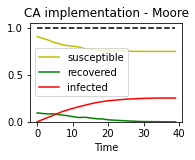

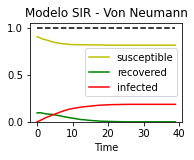

In [62]:
a=0.2; b=0.05  #alpha y beta

# plt.subplot(2,2,1)
# plt.title("EDO's model")
# grafsir(ND,TS,INPUT)

# system = np.zeros((30,30))
# system = initialCondition(0.1, system)

# sm = SIR_Model(a, b, 40, system,1,1,Moore)
# var_m = [sm[0],sm[1],sm[2]]; col = ["y","g","r"]
# eti = ["susceptible", "recovered","infected"] 

# plt.subplot(2,2,2)
# graficas(var_m, eti, col, "CA implementation - Moore")

# svn = SIR_Model(a, b, 40, system,1,1,Von_Neumann)
# var_vn = [svn[0],svn[1],svn[2]]
# plt.subplot(2,2,3)
# graficas(var_vn, eti, col, "Modelo SIR - Von Neumann")

# plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vSyPNhakKc0-9tIEtdIgnFXszS9Nx_JZAI_yUypiJHVeJ505DrQemgrfpnsxjB_aTd7QQ3XtxsW-xhL/pub?w=703&h=511)

*   **Evolución de la enfermedad D:** Al igual que en el caso anterior, se considero una población inicial de individuos infectados del $10\%$ y en la implementación en AC una distribución inicial de infectados del tipo aleatoria.

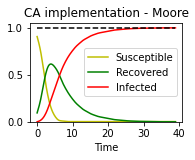

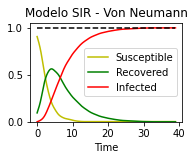

In [63]:
# a=0.2; b=0.5  #alpha y beta

# plt.subplot(2,2,1)
# plt.title("EDO's model")
# grafsir(ND,TS,INPUT)

# system = np.zeros((30,30))
# system = initialCondition(0.1, system)
# sm = SIR_Model(a, b, 40, system,1,1,Moore)
# var_m = [sm[0],sm[1],sm[2]]
# col = ["y","g","r"]
# eti = ["Susceptible","Recovered","Infected"] 

# plt.subplot(2,2,2)
# graficas(var_m, eti, col, "CA implementation - Moore")

# svn = SIR_Model(a, b, 40, system,1,1,Von_Neumann)
# var_vn = [svn[0],svn[1],svn[2]]
# plt.subplot(2,2,3)
# graficas(var_vn, eti, col, "Modelo SIR - Von Neumann")

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vQDhpO2ey-z04B869HAR1WRNCjaaL_6cVq5CJdF_BSw4mhns_utIdZI2TH1IjfssSgZFe7ewdNyQ4fV/pub?w=716&h=518)

Podemos preguntarnos si la manera en la que ubicamos inicialmente a los individuos infectados afecta o no el comportamiento de las soluciones de la implementación en autómatas celulares. Para responder a esto consideremos tres casos puntuales de condición inicial de ubicación para individuos infectados:

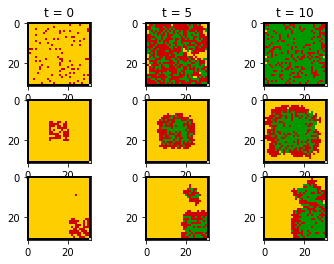

In [64]:
# system1 = initialLocation(30,30,0.1,position = "random")
# system2 = initialLocation(30,30,0.1,position = "center")
# system3 = initialLocation(30,30,0.1,position = "southeast")
# evolution1 = SIR_Model(0.2, 0.5, 30, system1, 1, 1, Moore)
# evolution2 = SIR_Model(0.2, 0.5, 30, system2, 1, 1, Moore)
# evolution3 = SIR_Model(0.2, 0.5, 30, system3, 1, 1, Moore)

# plt.subplot(3,3,1)
# plt.title("t = 0")
# plt.imshow(color(evolution1[6][0]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,2)
# plt.title("t = 5")
# plt.imshow(color(evolution1[6][5]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,3)
# plt.title("t = 10")
# plt.imshow(color(evolution1[6][10]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,4)
# plt.imshow(color(evolution2[6][0]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,5)
# plt.imshow(color(evolution2[6][5]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,6)
# plt.imshow(color(evolution2[6][10]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,7)
# plt.imshow(color(evolution3[6][0]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,8)
# plt.imshow(color(evolution3[6][5]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.subplot(3,3,9)
# plt.imshow(color(evolution3[6][10]),cmap="nipy_spectral", 
#            interpolation='nearest')

# plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vRqXw2azoPK2kDWGkMFSns6Yuia70F3SCXbYT9RbJ-2U1YvaAu_BaV2xcZhXsA3OPi7ZfY9C3x0d86b/pub?w=720&h=714)

De manera que si observamos el comportamiento de una manera mas precisa, se puede apreciar si bien no una diferencia en el comportamiento general de la enfermedad, si en la velocidad con la cual convergen las soluciones de la implementación:

In [66]:
# sm1 = SIR_Model(0.2, 0.5, 100, system1,1,1,Moore)
# sm2 = SIR_Model(0.2, 0.5, 100, system2,1,1,Moore)
# sm3 = SIR_Model(0.2, 0.5, 100, system3,1,1,Moore)
# svn1 = SIR_Model(0.2, 0.5, 100, system1,1,1,Von_Neumann)
# svn2 = SIR_Model(0.2, 0.5, 100, system2,1,1,Von_Neumann)
# svn3 = SIR_Model(0.2, 0.5, 100, system3,1,1,Von_Neumann)

# var_sm1 = [sm1[0],sm1[1],sm1[2]]
# var_sm2 = [sm2[0],sm2[1],sm2[2]]
# var_sm3 = [sm3[0],sm3[1],sm3[2]]
# var_vn1 = [svn1[0],svn1[1],svn1[2]]
# var_vn2 = [svn2[0],svn2[1],svn2[2]]
# var_vn3 = [svn3[0],svn3[1],svn3[2]]

# plt.subplot(2,3,1)
# graficas(var_sm1, eti,col,"Random distribution of infected - M")

# plt.subplot(2,3,2)
# graficas(var_sm1, eti,col,"Center distribution of infected - M")

# plt.subplot(2,3,3)
# graficas(var_sm1, eti,col,"Southeast distribution of infected - M")

# plt.subplot(2,3,4)
# graficas(var_vn1, eti,col,"Random distribution of infected - VN")

# plt.subplot(2,3,5)
# graficas(var_vn1, eti,col,"Center distribution of infected - VN")

# plt.subplot(2,3,6)
# graficas(var_vn1, eti,col,"Southeast distribution of infected - VN")

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vRq1-Di3tXrbXGbPLpwjLvBW6xrpeNkUli0ixLod_MYZFMG0s5Pl7dZeWD4k-8BkdVKqN7FKkZDPYw8/pub?w=992&h=521)

De la misma manera en la que abordamos el análisis de la evolución de la enfermedad con respecto a la condición inicial de población infectada en el modelo $SIS$, si tomamos como punto de partida los puntos cardinales para realizar dicha ubicación podemos observar un comportamiento como el que se describe en la siguiente figura:

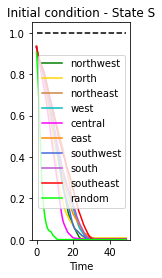

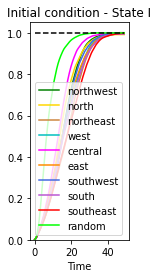

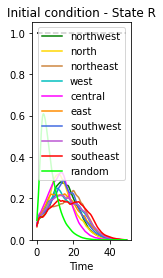

In [68]:
# SIR1_M = SIR_Model(0.2, 0.5, 50, initialLocation(30,30,0.1,"northwest"), 
#                    1, 1, Moore)
# SIR2_M = SIR_Model(0.2, 0.5, 50, initialLocation(30,30,0.1,"north"), 
#                    1, 1, Moore)
# SIR3_M = SIR_Model(0.2, 0.5, 50, initialLocation(30,30,0.1,"northeast"), 
#                    1, 1, Moore)
# SIR4_M = SIR_Model(0.2, 0.5, 50, initialLocation(30,30,0.1,"west"), 
#                    1, 1, Moore)
# SIR5_M = SIR_Model(0.2, 0.5, 50, initialLocation(30,30,0.1,"center"), 
#                    1, 1, Moore)
# SIR6_M = SIR_Model(0.2, 0.5, 50, initialLocation(30,30,0.1,"east"), 
#                    1, 1, Moore)
# SIR7_M = SIR_Model(0.2, 0.5, 50, initialLocation(30,30,0.1,"southwest"), 
#                    1, 1, Moore)
# SIR8_M = SIR_Model(0.2, 0.5, 50, initialLocation(30,30,0.1,"south"), 
#                    1, 1, Moore)
# SIR9_M = SIR_Model(0.2, 0.5, 50, initialLocation(30,30,0.1,"southeast"), 
#                    1, 1, Moore)
# SIR10_M = SIR_Model(0.2, 0.5, 50, initialLocation(30,30,0.1,"random"), 
#                     1, 1, Moore)

# var_sm = [SIR1_M[0], SIR2_M[0], SIR3_M[0], SIR4_M[0], SIR5_M[0], 
#           SIR6_M[0], SIR7_M[0], SIR8_M[0], SIR9_M[0], SIR10_M[0]]
# var_rm = [SIR1_M[1], SIR2_M[1], SIR3_M[1], SIR4_M[1], SIR5_M[1], 
#           SIR6_M[1], SIR7_M[1], SIR8_M[1], SIR9_M[1], SIR10_M[1]]
# var_im = [SIR1_M[2], SIR2_M[2], SIR3_M[2], SIR4_M[2], SIR5_M[2], 
#           SIR6_M[2], SIR7_M[2], SIR8_M[2], SIR9_M[2], SIR10_M[2]]

# col_dis = ["g", "gold", "peru", "c", "magenta", "darkorange", 
#            "royalblue", "mediumorchid", "r", "lime"]
# eti_dis = ["northwest", "north", "northeast", "west", "central", 
#            "east", "southwest", "south", "southeast", "random"]

# plt.subplot(1,3,1)
# graficas(var_sm, eti_dis, col_dis,"Initial condition - State S")

# plt.subplot(1,3,2)
# graficas(var_im, eti_dis, col_dis,"Initial condition - State I")

# plt.subplot(1,3,3)
# graficas(var_rm, eti_dis, col_dis,"Initial condition - State R")

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vQi3il_K9DFSqP12T3iWjUyiaMJ9_t_NYc1aGF0YomK2v4YdONj6T2mMBiQuiMc2PS1w1lNOHLbtJYX/pub?w=1024&h=279)

La posibilidad de modelar diferentes condiciones iniciales de ubicación para individuos infectados es una cualidad presente únicamente en la implementación del modelo $SIR$ en AC. Por otro lado, al igual que en el caso del modelo $SIS$, la implementación nos permite definir zonas de riesgo basándonos en el comportamiento de las poblaciones hasta un determinado tiempo. 

In [41]:
#-----Mapas de calor-----

def SIR_Heatmap_I(evolutionsOfSystem):
    """Mapa de calor para la población infectada"""
    infectedHeatMap = []
    n,m = evolutionsOfSystem[0].shape
    for iteration in range(len(evolutionsOfSystem)):
        infectedMatrix = np.zeros((n,m))
        for row in range(n):
            for column in range(m):
                if evolutionsOfSystem[iteration][row][column] == 1:
                    infectedMatrix[row][column] = 1
        infectedHeatMap.append(infectedMatrix)
    average = 1/len(infectedHeatMap)*np.sum(infectedHeatMap,axis=0)
    sns.heatmap(average, center=0, cmap='viridis',  fmt='.3f')
    
def SIR_Heatmap_R(evolutionsOfSystem):
    """Mapa de calor para la población recuperada"""
    recoveredHeatMap = []
    n,m = evolutionsOfSystem[0].shape
    for iteration in range(len(evolutionsOfSystem)):
        recoveredMatrix = np.zeros((n,m))
        for row in range(n):
            for column in range(m):
                if evolutionsOfSystem[iteration][row][column] == 2:
                    recoveredMatrix[row][column] = 1
        recoveredHeatMap.append(recoveredMatrix)
    average = 1/len(recoveredHeatMap)*np.sum(recoveredHeatMap,axis=0)
    sns.heatmap(average, center=0, cmap='viridis',  fmt='.3f')

In [42]:
#-----Mapas de calor-----

def heatmap_sir_I(alpha,beta,tf,A,p,q,function):
    """SIR_Heatmap_I"""
    a,b=A.shape
    B=SIR_model(alpha,beta,tf,A,p,q,function)[6]
    C=[]
    for i in range(len(B)):
        D=np.zeros((a,b)); F=np.zeros((a,b))
        for j in range(a):
            for k in range(b):
                if B[i][j][k]==1:
                    D[j][k]=1
        C.append(D)
    suma1=1/tf*np.sum(C,axis=0)
    sns.heatmap(suma1, center=0, cmap='viridis',  fmt='.3f')

def heatmap_sir_R(alpha,beta,tf,A,p,q,function):
    """SIR_Heatmap_R"""
    a,b=A.shape
    B=SIR_model(alpha,beta,tf,A,p,q,function)[6]
    C=[]
    for i in range(len(B)):
        D=np.zeros((a,b)); F=np.zeros((a,b))
        for j in range(a):
            for k in range(b):
                if B[i][j][k]==2:
                    D[j][k]=1
        C.append(D)
    suma1=1/tf*np.sum(C,axis=0)
    sns.heatmap(suma1, center=0, cmap='viridis',  fmt='.3f')

Del lado izquierdo de la siguiente figura podemos observar el comportamiento de la población infectada en un periodo de 30 días, este mapa de calor nos permite visualizar que el tiempo promedio de infección corresponde con el descrito por los parámetros que definen a la enfermedad y por otro lado, tenemos el mapa de calor de la población recuperada, este mapa nos permite visualizar las zonas que se recuperaron primero y que por tanto, fueron las primeras en ser alcanzadas por la enfermedad.

In [43]:
#system_hm2 = northwest(30,30,0.1)

#plt.subplot(2,2,1)
#heatmap_sir_I(0.2,0.5,30,system_hm2,1,1,Moore)

#plt.subplot(2,2,2)
#heatmap_sir_R(0.2,0.5,30,system_hm2,1,1,Moore)

#plt.subplot(2,2,3)
#heatmap_sir_I(0.2,0.5,30,system_hm2,1,1,Von_Neumann)

#plt.subplot(2,2,4)
#heatmap_sir_R(0.2,0.5,30,system_hm2,1,1,Von_Neumann)

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vQZNfVumD3AN5ODCNx9VmGNP6M1tfImRQiEoHgvfXpeUc1Nz21Qo7rAOLI4kFO9hRlJ_BPo1cjUV5y8/pub?w=663&h=486)

## Variación en la condición de frontera del sistema y sus implicaciones en el estudio epidemiológico

Hasta este momento hemos analizado únicamente sistemas rectangulares, en esta sección estudiaremos las implicaciones que tiene cambiar la frontera de nuestro sistema en la evolución de la enfermedad.

### Variaciones en la condición de frontera del sistema

Al igual que en las implementaciones anteriores, se consideró una vecindad de Moore la cual considera una vecindad de 8 individuos; sin embargo esto no siempre es así. 

En los sistemas rectangulares por ejemplo, los individuos que se encuentran en los bordes del sistema solo cuentan con 5 vecinos y para el caso de los que están ubicados en las esquinas de dichos sistemas, sus vecindades cuentan con tan solo 3 individuos.

Debido a que dos de las reglas que hemos implementado hasta ahora cuentan con una dependencia implícita del comportamiento de la vecindad, debemos realizar un ajuste en cuanto a la cantidad de vecinos con los que cuenta el agente en cuestión.

**Definición 5.1.** Definimos la regla base de interacción local generalizada como:
\begin{equation}
    \phi_{ij}^t(\alpha,\beta)=\left\{
    \begin{array}{cl}
    x_{ij}^{t+1}\in S & \textrm{si }\rho\leq\frac{\beta}{\alpha}\cdot\frac{N_{ij}^t(I)}{8-N_{ij}^t(V)}\textrm{, con }N_{ij}^t(V)\neq8\\
    x_{ij}^{t+1}\in I & \textrm{en otro caso}
    \end{array}
    \right.
\end{equation}
Donde $N_{ij}^t(V)$ representa a la cantidad de espacios vacíos o ausentes (identificados con el color negro) en la vecindad de Moore del agente en la posición $ij$. De manera análoga se define la regla de interacción $SI$ generalizada.

In [44]:
# Curvas promedio

def SIS_MediumCurves(alpha,beta,n_iterations,n_simulations,initialPercentageInfected,system,extraRows,extraColumns,
                     neighborhoodType):
    """Promedio de n simulaciones para el modelo SIS"""
    averageSusceptibleRate = []; averageInfectedRate = []
    # Listas que permiten promediar la cantidad de individuos para n simulaciones
    susceptibleDataPerSimulation = []; susceptibleData = np.zeros((n_iterations,2))
    infectedDataPerSimulation = []; infectedData = np.zeros((n_iterations,2))
    for simulation in range(n_simulations):
        # ¡¡¡Se puede ajustar la ubicación inicial de infectados!!!
        evolution = SIS_Model(alpha,beta,n_iterations,initialCondition(initialPercentageInfected,system),extraRows,
                              extraColumns,neighborhoodType)
        susceptibleDataPerSimulation.append(evolution[2]); infectedDataPerSimulation.append(evolution[3])               
    for iteration in range(n_iterations):
        # Se promedian las cantidades
        susceptibleRate = 0; infectedRate = 0
        for simulation in range(n_simulations):
            susceptibleRate += susceptibleDataPerSimulation[simulation][iteration]/n_simulations
            infectedRate += infectedDataPerSimulation[simulation][iteration]/n_simulations 
        averageSusceptibleRate.append(susceptibleRate); averageInfectedRate.append(infectedRate)
    for iteration in range(n_iterations):
        susceptibleData[iteration][0] = iteration; susceptibleData[iteration][1] = averageSusceptibleRate[iteration]
        infectedData[iteration][0] = iteration; infectedData[iteration][1] = averageInfectedRate[iteration]
    return [susceptibleData,infectedData,averageSusceptibleRate,averageInfectedRate]

# Modelo SIR 

def SIR_MediumCurves(alpha,beta,n_iterations,n_simulations,initialPercentageInfected,system,extraRows,extraColumns,
                     neighborhoodType):
    """Promedio de n simulaciones para el modelo SIR"""
    averageSusceptibleRate = []; averageInfectedRate = []; averageRecoveredRate = []
    # Listas que permiten promediar la cantidad de individuos para n simulaciones
    susceptibleDataPerSimulation = []; susceptibleData = np.zeros((n_iterations,2))
    infectedDataPerSimulation = []; infectedData = np.zeros((n_iterations,2))
    recoveredDataPerSimulation = []; recoveredData = np.zeros((n_iterations,2)) 
    for simulation in range(n_simulations):
        # ¡¡¡Se puede ajustar la ubicación inicial de infectados!!!
        evolution = SIR_Model(alpha,beta,n_iterations,initialCondition(initialPercentageInfected,system),extraRows,
                          extraColumns,neighborhoodType)
        susceptibleDataPerSimulation.append(evolution[3])
        infectedDataPerSimulation.append(evolution[4])
        recoveredDataPerSimulation.append(evolution[5])
    for iteration in range(n_iterations):
        # Se promedian las cantidades
        susceptibleRate = 0; infectedRate = 0; recoveredRate = 0
        for simulation in range(n_simulations):
            susceptibleRate += susceptibleDataPerSimulation[simulation][iteration]
            infectedRate += infectedDataPerSimulation[simulation][iteration]
            recoveredRate += recoveredDataPerSimulation[simulation][iteration]
        susceptibleRate = susceptibleRate/n_simulations
        infectedRate = infectedRate/n_simulations
        recoveredRate = recoveredRate/n_simulations 
        averageSusceptibleRate.append(susceptibleRate)
        averageInfectedRate.append(infectedRate)
        averageRecoveredRate.append(recoveredRate)
    for iteration in range(n_iterations):
        susceptibleData[iteration][0] = iteration; susceptibleData[iteration][1] = averageSusceptibleRate[iteration]
        infectedData[iteration][0] = iteration; infectedData[iteration][1] = averageInfectedRate[iteration]
        recoveredData[iteration][0] = iteration; recoveredData[iteration][1] = averageRecoveredRate[iteration]
    return [susceptibleData,infectedData,recoveredData,averageSusceptibleRate,averageInfectedRate,averageRecoveredRate]

In [45]:
#-----Curvas promedio---
#---Modelo SIS---

def medium_curves_sis(alpha,beta,tf,csim,I0,A,p,q,function):     #Promedio de csim simulaciones para el modelo SIS
    """SIS_MediumCurves"""
    S=[]; I=[]                                      #S e I guardarán el promedio de las cantidades normalizadas por estados respectivos
    cs=[]; ci=[]                                    #cs y ci serán las listas que permiten promediar la cantidad de individuos para csim simulaciones
    CI=np.zeros((tf,2)); CS=np.zeros((tf,2))        #Hay tf coordenadas
    for i in range(csim):                                          #Para csim simulaciones 
        promsis=SIS_model(alpha,beta,tf,initial_condition(I0,A),p,q,function)   #Aplique un condición inicial de distribución uniforme de infectados 
        cs.append(promsis[2]); ci.append(promsis[3])               #Las listas S e I generadas por cada iteración son enviadas a las listas cs y ci
    for i in range(tf):                                            #Se promedian las cantidades
        k=0; l=0
        for j in range(csim):
            k=k+cs[j][i]/csim; l=l+ci[j][i]/csim 
        S.append(k); I.append(l)                    #Las cantidades promedio son enviadas a las listas S e I
    for i in range(tf):                             #Se crean las listas de coordenadas
        CS[i][0]=i; CS[i][1]=S[i]
        CI[i][0]=i; CI[i][1]=I[i]
    return [CS,CI,S,I]                              #Datos promedio del modelo SIS para csim simulaciones

#---Modelo SIR---

def medium_curves_sir(alpha,beta,tf,csim,I0,A,p,q,function):                   #Promedio de csim simulaciones para el modelo SIR
    """SIR_MediumCurves"""
    S=[]; I=[]; R=[]                                              #S,I y R guardarán el promedio de las cantidades normalizadas por estados respectivos
    cs=[]; ci=[]; cr=[]                                           #cs,ci y cr serán las listas que permiten promediar la cantidad de individuos para csim simulaciones
    CI=np.zeros((tf,2)); CS=np.zeros((tf,2)); CR=np.zeros((tf,2)) #Hay tf coordenadas
    for i in range(csim):                                                   #Para csim simulaciones
        promsir=SIR_model(alpha,beta,tf,initial_condition(I0,A),p,q,function)            #Aplique un condición inicial de distribución uniforme de infectados 
        cs.append(promsir[3]); ci.append(promsir[4]); cr.append(promsir[5]) #Las listas S, I y R generadas por cada iteración son enviadas a las listas cs, ci y cr
    for i in range(tf):                                                     #Se promedian las cantidades
        k=0; l=0; p=0
        for j in range(csim):
            k=k+cs[j][i]; l=l+ci[j][i]; p=p+cr[j][i]
        k=k/csim; l=l/csim; p=p/csim 
        S.append(k); I.append(l); R.append(p)                      #Las cantidades promedio son enviadas a las listas S, I y R
    for i in range(tf):                                            #Se crean las listas de coordenadas
        CS[i][0]=i; CS[i][1]=S[i]
        CI[i][0]=i; CI[i][1]=I[i]
        CR[i][0]=i; CR[i][1]=R[i]
    return [CS,CR,CI,S,I,R]                                        #Datos promedio del modelo SIR para csim simulaciones

In [46]:
# Condición de frontera

def boundaryDefinition(boundaryConditions,nRows,mColumns):
    """Definición de la estructura del sistema dadas las condiciones de frontera
    
    boundaryConditions : Lista con las posiciones con individuos dentro del sistema
    """
    system = -np.ones((nRows,mColumns))
    for condition in range(len(boundaryConditions)):
        # Cambie la posición respectiva del sistema por cero
        system[boundaryConditions[condition][0],boundaryConditions[condition][1]] = 0  
    return system

def rectangularBoundary(rectangleRows,rectangleColumns,rowPosition,columnPosition,nRowsSystem,nColumnsSystem):
    """Ubica una matriz nula de tamaño rectangleRows*rectangleColumns en la posición a,b de M"""
    boundaryConditions = []
    for row in range(rectangleRows):      
        for column in range(rectangleColumns):
            boundaryConditions.append((rowPosition+row,columnPosition+column)) 
    return boundaryDefinition(boundaryConditions,nRowsSystem,nColumnsSystem)

In [47]:
# Condición de frontera

def boundary(L,M):            #La lista L posee las coordenadas que definen las posiciones nulas en el sistema M 
    """boundaryDefinition"""
    n,m=M.shape
    K=np.ones((n,m))
    for i in range(n):
        for j in range(m):
            K[i][j]=M[i][j]
    for i in range(len(L)):   #Para cada coordenada
        K[L[i][0],L[i][1]]=0  #Cambie la posición respectiva de la matriz M por cero
    return K                  #Retorne el sistema M

def domain_definition(n,m,a,b,M):   #Ubica una matriz nula de tamaño nxm en la posición a,b de M
    """rectangularBoundary"""
    L=[]                            #Lista de coordenadas que se anularán 
    for i in range(n):      
        for j in range(m):
            L.append((a+i,b+j))     #Ingrese a la lista L las coordenadas de las posiciones de la submatriz nula
    return boundary(L,M)            #Reemplace las nxm posiciones de M por ceros en las posiciones a,b

A continuación mostramos una serie de ejemplos que verifican el correcto funcionamiento de la definición 5.1, en cada uno se consideró tanto para el caso del modelo $SIS$ como el caso del modelo $SIR$, una enfermedad con parámetros $\alpha=0.2$ y $\beta=0.5$ en un periodo de 100 días, una ubicación inicial de individuos infectados del tipo aleatorio y una población infectada inicial del $10\%$ con respecto al tamaño de cada sistema, con lo cual obtuvimos los siguientes resultados promedio para 100 simulaciones:

*  **Modelos epidemiológicos sobre una linea:** Se considero un sistema lineal con 10 individuos.
    
En la siguiente figura podemos observar un cambio importante con respecto a la trayectoria de las soluciones, estos cambios se deben a la naturaleza de las vecindades en un sistema de este tipo.

In [48]:
#L=-np.ones((9,10))
#L=domain_definition(1,10,4,0,L)

#msl = medium_curves_sis(0.2,0.5,30,100,0.1,L,1,1,Moore)
#var_sis = [msl[0],msl[1]]; eti_sis = ["Susceptible", "Infected"]; col_sis = ["y", "r"] 
#msil = medium_curves_sir(0.2,0.5,30,100,0.1,L,1,1,Moore)
#var_sir = [msil[0],msil[1],msil[2]]; eti_sir = ["Susceptible","Recovered", "Infected"]; col_sir = ["y","g","r"] 

#plt.subplot(1,3,1)
#plt.imshow(color(initial_condition(0.1,L)),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(1,3,2)
#graficas(var_sis,eti_sis,col_sis,"Medium curves - SIS")

#plt.subplot(1,3,3)
#graficas(var_sir,eti_sir,col_sir,"Medium curves - SIR")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vTNxzf2g1J38UicYaTHifeU_4Z2xyzWEmUAkYo0P25xOUCpt9oRr2lT4t4kTwOrbSKG45fg392PdK9U/pub?w=947&h=277)

*   **Modelos epidemiológicos sobre un cuadrado:** Se consideró un sistema de $10\times10$.

In [49]:
#C=-np.zeros((10,10))

#msc=medium_curves_sis(0.2,0.5,30,100,0.1,C,1,1,Moore)
#var_sis = [msc[0], msc[1]]
#msic=medium_curves_sir(0.2,0.5,30,100,0.1,C,1,1,Moore)
#var_sir = [msic[0], msic[1], msic[2]]

#plt.subplot(1,3,1)
#plt.imshow(color(initial_condition(0.1,C)),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(1,3,2)
#graficas(var_sis,eti_sis,col_sis,"Medium curves - SIS")

#plt.subplot(1,3,3)
#graficas(var_sir,eti_sir,col_sir,"Medium curves - SIR")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vR29BHWiDU_IA1Cuwd55ciri-2bJ9VmFuEMLNaBA8SfUr6Jqcc19N-vGKrHG1St_kf2yJ9UKoSKMRXJ/pub?w=917&h=272)

*   **Modelos epidemiológicos sobre una región rectangular:** En este caso se tomo un sistema $5\times10$.

In [50]:
#R1=-np.ones((10,10))
#R1=domain_definition(5,10,3,0,R1)

#msr1=medium_curves_sis(0.2,0.5,30,100,0.1,R1,1,1,Moore)
#var_sis = [msr1[0],msr1[1]]
#msir1=medium_curves_sir(0.2,0.5,30,100,0.1,R1,1,1,Moore)
#var_sir = [msir1[0],msir1[1],msir1[2]]

#plt.subplot(1,3,1)
#plt.imshow(color(initial_condition(0.1,R1)),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(1,3,2)
#graficas(var_sis,eti_sis,col_sis,"Curvas medias - SIS")

#plt.subplot(1,3,3)
#graficas(var_sir,eti_sir,col_sir,"Curvas medias - SIR")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vRqrBothaRE6SPgLoqBQkaUn6jb6IcGB3aT61rBL6RLX6_7lPpLw6j1-kFoHAm624fucqfZiHfw3a0G/pub?w=925&h=267)

*   **Modelos epidemiológicos sobre una región tipo rombo:** Para nuestro cuarto ejemplo tomamos una población de 46 individuos en un sistema tipo rombo.

In [51]:
def rombo(a,b,c,d,M):           
    L=[M]
    i=0
    while c>1:
        a=a+2; b=b-4; c=c-1; d=d+2; i=i+1
        L.append(domain_definition(a,b,c,d,L[i-1]))
    return L[i]

# R2=-np.ones((14,14))
# R2=rombo(1,14,7,0,R2)

# eti_sis = ["Susceptible", "Infected"]; col_sis = ["y", "r"]

# msr2=SIS_MediumCurves(0.2,0.5,30,10,0.1,R2,1,1,Moore)
# var_sis = [msr2[0],msr2[1]]
# msir2=SIR_MediumCurves(0.2,0.5,30,10,0.1,R2,1,1,Moore)
# var_sir = [msir2[0],msir2[1],msir2[2]]

# plt.subplot(1,3,1)
# plt.imshow(color(initial_condition(0.1,R2)),cmap="nipy_spectral", interpolation='nearest')

# plt.subplot(1,3,2)
# graficas(var_sis,eti_sis,col_sis,"Medium curves - SIS")

# plt.subplot(1,3,3)
# graficas(var_sir,eti_sir,col_sir,"Medium curves - SIR")

# plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vT6n-zhmAd5h68v0M2IcutPJZgVyWkmxkDQh6YxieAImLHR7XLVFwnTMPThyvpSKp2JI7i19yDc2j6e/pub?w=921&h=269)

*   **Modelos epidemiológicos en una región triangular:** Se consideró una región triangular con un total de 56 individuos.

In [52]:
def triangulo(n,m,a,b,M):
    L=[M]
    i=0
    while m>=1:
        i=i+1
        L.append(domain_definition(n,m,a,b,L[i-1]))
        m=m-2; a=a-1; b=b+1
    return L[i]

#T=-np.ones((14,14))
#T=triangulo(1,14,9,0,T)

#mst=medium_curves_sis(0.2,0.5,30,100,0.1,T,1,1,Moore)
#var_sis = [mst[0],mst[1]]
#msit=medium_curves_sir(0.2,0.5,30,100,0.1,T,1,1,Moore)
#var_sir = [msit[0],msit[1],msit[2]]

#plt.subplot(1,3,1)
#plt.imshow(color(initial_condition(0.1,T)),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(1,3,2)
#graficas(var_sis,eti_sis,col_sis,"Medium curves - SIS")

#plt.subplot(1,3,3)
#graficas(var_sir,eti_sir,col_sir,"Medium curves - SIR")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vSMRIiByLXHesrvzziMB9b7m9B9HLPs43eherv2IjGUbcI3BqwhVv0BR51_SsgXtQFbAOKFAgu1yrda/pub?w=925&h=275)

*   **Modelos epidemiológicos en una región tipo anillo: (caso $\#1$)** Se tomo una población de 48 individuos. Observe que en el caso del modelo $SIR$, la población susceptible no converge a cero como en los ejemplos anteriores, esto se debe a la dificultada que puede tener la propagación de la enfermedad por la manera en la que se definió el sistema.

In [53]:
#C1 = -np.ones((8,8))
#C1 = domain_definition(2,8,0,0,C1)
#C1 = domain_definition(8,2,0,0,C1)
#C1 = domain_definition(8,2,0,6,C1)
#C1 = domain_definition(2,8,6,0,C1)

#msc1=medium_curves_sis(0.2,0.5,30,100,0.1,C1,1,1,Moore)
#var_sis = [msc1[0],msc1[1]]
#msic1=medium_curves_sir(0.2,0.5,30,100,0.1,C1,1,1,Moore)
#var_sir = [msic1[0],msic1[1],msic1[2]]

#plt.subplot(1,3,1)
#plt.imshow(color(initial_condition(0.1,C1)),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(1,3,2)
#graficas(var_sis,eti_sis,col_sis,"Medium curves - SIS")

#plt.subplot(1,3,3)
#graficas(var_sir,eti_sir,col_sir,"Medium curves - SIR")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vRmtUe2gGaZcje6vOiiVJNNVm6a6L54g4BPhkjC0ci4AKBdxiLuenlX-qSiGcjFADpo6YuLQ-ebIJdl/pub?w=917&h=277)

*   **Modelos epidemiológicos en un sistema con población alejada: (caso $\#2$)** Supongamos que tenemos un sistema en el cual cierto grupo de la población no tiene contacto con el resto de los individuos (figura a), este sistema cuenta con una población de 52 individuos. Observe que en ambos modelos, la curva que describe el comportamiento no tiende a cero como en los casos anteriores; esto implica que la enfermedad no alcanza a todos los individuos del sistema, esto debido al distanciamiento con el que cuentan los individuos en el bloque central del sistema.

In [54]:
#C2=domain_definition(2,2,3,3,C1)

#msc2=medium_curves_sis(0.2,0.5,30,100,0.1,C2,1,1,Moore)
#var_sis = [msc2[0],msc2[1]]
#msic2=medium_curves_sir(0.2,0.5,30,100,0.1,C2,1,1,Moore)
#var_sir = [msic2[0],msic2[1],msic2[2]]

#plt.subplot(1,3,1)
#plt.imshow(color(initial_condition(0.1,C2)),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(1,3,2)
#graficas(var_sis,eti_sis,col_sis,"Medium curves - SIS")

#plt.subplot(1,3,3)
#graficas(var_sir,eti_sir,col_sir,"Medium curves - SIR")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vShSEQEY0kbA6pMwGIZScan3FnycAUl46vN1q0SgRD8JgZTAKPU7TBzTvhUfU2z1zMuD_hwmCKTFSkp/pub?w=917&h=275)

*Observación:* A diferencia del caso lineal, podemos observar una similitud en cuando al comportamiento de la población infectada en el tiempo. Esto nos sugiere que la manera en la que definimos la condición de frontera del sistema, afecta no solo la velocidad de convergencia sino los valores a los cuales convergen las curvas que describen el comportamiento de las poblaciones en el tiempo.

In [55]:
#SISL  = medium_curves_sis(0.2, 0.5, 30, 100, 0.1, L, 1, 1, Moore)
#SISC  = medium_curves_sis(0.2, 0.5, 30, 100, 0.1, C, 1, 1 ,Moore)
#SISR1 = medium_curves_sis(0.2, 0.5, 30, 100, 0.1, R1, 1, 1, Moore)
#SISR2 = medium_curves_sis(0.2, 0.5, 30, 100, 0.1, R2, 1, 1, Moore)
#SIST  = medium_curves_sis(0.2, 0.5, 30, 100, 0.1, T, 1, 1, Moore)
#SISC1 = medium_curves_sis(0.2, 0.5, 30, 100, 0.1, C1, 1, 1, Moore)
#SISC2 = medium_curves_sis(0.2, 0.5, 30, 100, 0.1, C2, 1, 1, Moore)

#var_sis = [SISL[1], SISC[1], SISR1[1], SISR2[1], SIST[1], SISC1[1],
#           SISC2[1]]
#col = ["purple", "steelblue", "darkorange", "firebrick", "seagreen",
#       "cyan", "orangered"]
#eti = ["Line", "Square", "Rectangle", "Rhombus", "Triangle", "Case # 1", 
#       "Case # 2"]
#graficas(var_sis,eti,col,"System comparison - SIS Model")

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vS2fIUw7wYiZVyMW-ubCbKgVRSqzX3OOHgNnvjZHWZXUkV_S8lcf5mxNTL3bGeDN-ySlq6u3jGuBgaV/pub?w=376&h=272)

In [56]:
#SIRL  = medium_curves_sir(0.2, 0.5, 30, 100, 0.1, L, 1, 1, Moore)
#SIRC  = medium_curves_sir(0.2, 0.5, 30, 100, 0.1, C, 1, 1, Moore)
#SIRR1 = medium_curves_sir(0.2, 0.5, 30, 100, 0.1, R1, 1, 1, Moore)
#SIRR2 = medium_curves_sir(0.2, 0.5, 30, 100, 0.1, R2, 1, 1, Moore)
#SIRT  = medium_curves_sir(0.2, 0.5, 30, 100, 0.1, T, 1, 1, Moore)
#SIRC1 = medium_curves_sir(0.2, 0.5, 30, 100, 0.1, C1, 1, 1, Moore)
#SIRC2 = medium_curves_sir(0.2, 0.5, 30, 100, 0.1, C2, 1, 1, Moore)

#var_sir=[SIRL[2], SIRC[2], SIRR1[2], SIRR2[2], SIRT[2], SIRC1[2],
#         SIRC2[2]]
#graficas(var_sir,eti,col,"System comparison - SIR Model")

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vTP_rfV4s41DIpbJhyM0SkdSsLQT8OeNqo8JD9gGJXYT7nhL-wtMfAo5TkRbgl2VPc8rtNNsrSL93Q3/pub?w=386&h=279)

### Variaciones en la escala del sistema

Es importante preguntarnos si cambiar la escala de un sistema altera de alguna manera la evolución del sistema. Al igual que en el análisis en la variación de condiciones de frontera, consideraremos una serie de ejemplos para visualizar si existe o no, una variación en la evolución de la enfermedad.

In [57]:
def variationsBetweenScales(scale1,scale2):
    '''Genera una lista con las diferencias entre escalas'''
    variationsArray = np.zeros((len(scale1),2))
    for data in range(len(scale1)):
        variationsArray[data][0] = data
        variationsArray[data][1] = abs(scale1[data]-scale2[data])
    return variationsArray

In [58]:
def scale_differences(L1,L2):
    '''variationsBetweenScales'''
    L=np.zeros((len(L1),2))
    for i in range(len(L1)):
        L[i][0]=i; L[i][1]=abs(L1[i]-L2[i])
    return L

En cada uno de los siguientes ejemplos se realizaron 4 cambios de escala sobre el tipo de sistema en cuestión, posteriormente se aplicaron las implementaciones de los modelos $SIS$ y $SIR$ tomando como punto de partida una enfermedad con parámetros $\alpha=0.2$ y $\beta=0.5$, una población infectada inicial del $10\%$ con una ubicación inicial del tipo aleatoria.

*   **Cambios de escala sobre la linea:** Se considero un sistema inicial de 100 individuos y se realizaron 4 cambios de escala de modo que las cantidades de individuos fueran 200, 300, 400 y 500 individuos por cada cambio respectivamente.

In [59]:
#L1 = np.zeros((1,100))
#L2 = np.zeros((1,200))
#L3 = np.zeros((1,300))
#L4 = np.zeros((1,400))
#L5 = np.zeros((1,500))

#plt.subplot(5,1,1)
#plt.imshow(color(L1),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(5,1,2)
#plt.imshow(color(L2),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(5,1,3)
#plt.imshow(color(L3),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(5,1,4)
#plt.imshow(color(L4),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(5,1,5)
#plt.imshow(color(L5),cmap="nipy_spectral", interpolation='nearest')

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vSTTlQwQIW9HM9wq-4PoTQmV27tXGyhQwCa1oHi1NbHrmTWbU1aVHWmrR59KhgYjnLwPyXslePKs3Jv/pub?w=387&h=234)

In [60]:
#SISL1=medium_curves_sis(0.2,0.5,30,100,0.1,L1,1,1,Moore)
#SIRL1=medium_curves_sir(0.2,0.5,30,100,0.1,L1,1,1,Moore)

#SISL2=medium_curves_sis(0.2,0.5,30,100,0.1,L2,1,1,Moore)
#SIRL2=medium_curves_sir(0.2,0.5,30,100,0.1,L2,1,1,Moore)

#SISL3=medium_curves_sis(0.2,0.5,30,100,0.1,L3,1,1,Moore)
#SIRL3=medium_curves_sir(0.2,0.5,30,100,0.1,L3,1,1,Moore)

#SISL4=medium_curves_sis(0.2,0.5,30,100,0.1,L4,1,1,Moore)
#SIRL4=medium_curves_sir(0.2,0.5,30,100,0.1,L4,1,1,Moore)

#SISL5=medium_curves_sis(0.2,0.5,30,100,0.1,L5,1,1,Moore)
#SIRL5=medium_curves_sir(0.2,0.5,30,100,0.1,L5,1,1,Moore)

#var_sis=[SISL1[1],SISL2[1],SISL3[1],SISL4[1],SISL5[1]]
#var_sir=[SIRL1[2],SIRL2[2],SIRL3[2],SIRL4[2],SIRL5[2]]

#col_esc=["purple", "steelblue", "darkorange", "firebrick", "seagreen"]
#eti_esc = ["es1", "es2", "es3", "es4", "es5"]
#col_dif = ["purple", "steelblue", "darkorange", "firebrick"]
#eti_dif = ["E5-E1", "E5-E2", "E5-E3", "E5-E4"]

#plt.subplot(1,2,1)
#graficas(var_sis,eti_esc,col_esc,"SIS en una linea")

#plt.subplot(1,2,2)
#graficas(var_sir,eti_esc,col_esc,"SIR en una linea")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vTmMDbVdn0yeJDdB08RJgut2A80Tz4Ri5NPqo3g9SDEmEHShVn0gSyIoSmJdmu--cx0e9E9kEENH7tF/pub?w=723&h=282)

Si graficamos las diferencias presentes entre cada escala y la escala mayor (es este caso la escala de 500 individuos) obtenemos:

In [61]:
#var_difs = [scale_differences(SISL1[3], SISL5[3]), scale_differences(SISL2[3], SISL5[3]), 
#            scale_differences(SISL3[3], SISL5[3]), scale_differences(SISL4[3], SISL5[3])]
#var_difsi = [scale_differences(SIRL1[3], SIRL5[3]), scale_differences(SIRL2[3], SIRL5[3]), 
#             scale_differences(SIRL3[3], SIRL5[3]), scale_differences(SIRL4[3], SIRL5[3])]

#plt.subplot(1,2,1)
#graficas(var_difs,eti_dif,col_dif,"Estado I - SIS en la linea", limit=False)

#plt.subplot(1,2,2)
#graficas(var_difsi,eti_dif,col_dif,"Estado I - SIR en la linea", limit=False)

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vRtWEbWIS_U3M0EcZtTfLbwLwNlVzsB9hsYz7ah8-QOFkWwDochQp4ARNVoU9C1ESFivKREb2Xfj20x/pub?w=731&h=279)

*   **Cambios de escala sobre el cuadrado:** En este caso se tomo un sistema cuadrado inicial de 100 individuos, los 4 cambios de escala analizados representan poblaciones de 625, 2500, 5625 y 10000 individuos respectivamente.

In [62]:
#C1 = np.zeros((10, 10))
#C2 = np.zeros((25, 25))
#C3 = np.zeros((50, 50))
#C4 = np.zeros((75, 75))
#C5 = np.zeros((100, 100))

#plt.subplot(2,3,1)
#plt.imshow(color(C1),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,2)
#plt.imshow(color(C2),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,3)
#plt.imshow(color(C3),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,4)
#plt.imshow(color(C4),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,5)
#plt.imshow(color(C5),cmap="nipy_spectral", interpolation='nearest')

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vRr1ToMA_UH1SsY1Y-re-aqMETUCtmjxHuH787FRmDJkZdGS1rxwGh1te_jPWYtRi-9bi_1F4RGPmNz/pub?w=687&h=490)

In [63]:
#SISC1=medium_curves_sis(0.2,0.5,30,100,0.1,C1,1,1,Moore)
#SIRC1=medium_curves_sir(0.2,0.5,30,100,0.1,C1,1,1,Moore)

#SISC2=medium_curves_sis(0.2,0.5,30,100,0.1,C2,1,1,Moore)
#SIRC2=medium_curves_sir(0.2,0.5,30,100,0.1,C2,1,1,Moore)

#SISC3=medium_curves_sis(0.2,0.5,30,100,0.1,C3,1,1,Moore)
#SIRC3=medium_curves_sir(0.2,0.5,30,100,0.1,C3,1,1,Moore)

#SISC4=medium_curves_sis(0.2,0.5,30,100,0.1,C4,1,1,Moore)
#SIRC4=medium_curves_sir(0.2,0.5,30,100,0.1,C4,1,1,Moore)

#SISC5=medium_curves_sis(0.2,0.5,30,100,0.1,C5,1,1,Moore)
#SIRC5=medium_curves_sir(0.2,0.5,30,100,0.1,C5,1,1,Moore)

#var_sis=[SISC1[1],SISC2[1],SISC3[1],SISC4[1],SISC5[1]]
#var_sir=[SIRC1[2],SIRC2[2],SIRC3[2],SIRC4[2],SIRC5[2]]

#plt.subplot(1,2,1)
#graficas(var_sis,eti_esc,col_esc,"SIS en un cuadrado")

#plt.subplot(1,2,2)
#graficas(var_sir,eti_esc,col_esc,"SIR en un cuadrado")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vSkSVWOjj9nZAxPGXZblPnjIN5m4mqbCHIkekoPNY9BaXOcW_cFJBfKZ3tuuuo6pKYtbZNRRdgNqemS/pub?w=713&h=278)

Al igual que en el ejemplo anterior, graficaremos las diferencias encontradas al realizar los cambios de escala tomando como escala de comparación a la que cuenta con 10000 individuos.

In [64]:
#plt.subplot(1,2,1)
#var_difs = [scale_differences(SISC1[3], SISC5[3]), scale_differences(SISC2[3], SISC5[3]), 
#            scale_differences(SISC3[3], SISC5[3]), scale_differences(SISC4[3], SISC5[3])]
#graficas(var_difs,eti_dif,col_dif,"Estado I - SIS en el cuadrado",limit=False)

#plt.subplot(1,2,2)
#var_difsi = [scale_differences(SIRC1[3], SIRC5[3]), scale_differences(SIRC2[3], SIRC5[3]), 
#             scale_differences(SIRC3[3], SIRC5[3]), scale_differences(SIRC4[3], SIRC5[3])]
#graficas(var_difsi,eti_dif,col_dif,"Estado I - SIR en el cuadrado", limit=False)

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vSrBu-q1AEneAsaSI-olSD4HxcB0XnvznZPvV0sQZ6u6yBtLtmU0umJRHeBeVprsXtVyguldW3S_tEI/pub?w=720&h=274)

En los ejemplos posteriores se tomaron escalas de manera que el tamaño del sistema o su cantidad de individuos en cada escala, coincidiera con los planteados en el ejemplo de cambios de escala en el cuadrado.

*   **Cambios de escala sobre una región rectangular:** Para este ejercicio se consideraron cambios de escala de tal manera que sus tamaños coincidieran con las escalas tomadas en el caso del cuadrado, obteniendo así:

In [65]:
#Re1 = np.zeros((5,20))
#Re2 = np.zeros((13,52))
#Re3 = np.zeros((25,100))
#Re4 = np.zeros((38,152))
#Re5 = np.zeros((50,200))

#plt.subplot(2,3,1)
#plt.imshow(color(Re1),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,2)
#plt.imshow(color(Re2),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,3)
#plt.imshow(color(Re3),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,4)
#plt.imshow(color(Re4),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,5)
#plt.imshow(color(Re5),cmap="nipy_spectral", interpolation='nearest')

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vS1PySpv-uiBthEcMvZNzutZuVlf1BYwxaaqAP-KgrCCxRjLQUza6-azgmYTGSuOdypDVu2-QZWT7nk/pub?w=1036&h=249)

In [66]:
#SISRe1=medium_curves_sis(0.2,0.5,30,100,0.1,Re1,1,1,Moore)
#SIRRe1=medium_curves_sir(0.2,0.5,30,100,0.1,Re1,1,1,Moore)

#SISRe2=medium_curves_sis(0.2,0.5,30,100,0.1,Re2,1,1,Moore)
#SIRRe2=medium_curves_sir(0.2,0.5,30,100,0.1,Re2,1,1,Moore)

#SISRe3=medium_curves_sis(0.2,0.5,30,100,0.1,Re3,1,1,Moore)
#SIRRe3=medium_curves_sir(0.2,0.5,30,100,0.1,Re3,1,1,Moore)

#SISRe4=medium_curves_sis(0.2,0.5,30,100,0.1,Re4,1,1,Moore)
#SIRRe4=medium_curves_sir(0.2,0.5,30,100,0.1,Re4,1,1,Moore)

#SISRe5=medium_curves_sis(0.2,0.5,30,100,0.1,Re5,1,1,Moore)
#SIRRe5=medium_curves_sir(0.2,0.5,30,100,0.1,Re5,1,1,Moore)

#plt.subplot(1,2,1)
#var_sis=[SISRe1[1],SISRe2[1],SISRe3[1],SISRe4[1],SISRe5[1]]
#graficas(var_sis,eti_esc,col_esc,"SIS en un rectangulo")

#plt.subplot(1,2,2)
#var_sir=[SIRRe1[2],SIRRe2[2],SIRRe3[2],SIRRe4[2],SIRRe5[2]]
#graficas(var_sir,eti_esc,col_esc,"SIR en un rectangulo")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vSYQ5MRbANTUx17utWHqbwqGPXkvYSPBuTGW2D_ZOy_Bfrrty7f5d4ds54hylWh4abW7ImKGqGoORXg/pub?w=710&h=268)

Si graficamos las diferencias entre escalas de manera análoga a como ocurría en los ejemplos anteriores obtenemos:

In [67]:
#plt.subplot(1,2,1)
#var_difs=[scale_differences(SISRe1[3],SISRe5[3]),scale_differences(SISRe2[3],SISRe5[3]),scale_differences(SISRe3[3],SISRe5[3]),scale_differences(SISRe4[3],SISRe5[3])]
#graficas(var_difs,eti_dif,col_dif,"Estado I - SIS en el rectangulo", limit=False)

#plt.subplot(1,2,2)
#var_difsi=[scale_differences(SIRRe1[3],SIRRe5[3]),scale_differences(SIRRe2[3],SIRRe5[3]),scale_differences(SIRRe3[3],SIRRe5[3]),scale_differences(SIRRe4[3],SIRRe5[3])]
#graficas(var_difsi,eti_dif,col_dif,"Estado I - SIR en el rectangulo")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vR5GV6ufxzhGE8m-KW0tzInzQ-IoQgcFk7tyy-k6Vj_bs830OzfzttAk-4x8xrMLoIltBp2L9IVfjGE/pub?w=724&h=265)

*   **Cambios de escala en una región tipo rombo:**

In [68]:
#Ro1=-np.ones((11,20));   Ro1=rombo(1,20,5,0,Ro1)
#Ro2=-np.ones((32,50));   Ro2=rombo(1,50,16,0,Ro2)
#Ro3=-np.ones((60,100));  Ro3=rombo(1,100,30,1,Ro3)
#Ro4=-np.ones((80,150));  Ro4=rombo(1,150,40,0,Ro4)
#Ro5=-np.ones((110,200)); Ro5=rombo(1,200,55,0,Ro5)

#plt.subplot(2,3,1)
#plt.imshow(color(Ro1),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,2)
#plt.imshow(color(Ro2),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,3)
#plt.imshow(color(Ro3),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,4)
#plt.imshow(color(Ro4),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,5)
#plt.imshow(color(Ro5),cmap="nipy_spectral", interpolation='nearest')

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vRDvpQUScGAZf9d1enD_QJg9DDDVI9oUZalGktMcx5nRHb57XazfnAm_LnujUYF5sMvo9SBP_AwJHJz/pub?w=942&h=443)

In [69]:
#SISRo1=medium_curves_sis(0.2,0.5,30,100,0.1,Ro1,1,1,Moore)
#SIRRo1=medium_curves_sir(0.2,0.5,30,100,0.1,Ro1,1,1,Moore)

#SISRo2=medium_curves_sis(0.2,0.5,30,100,0.1,Ro2,1,1,Moore)
#SIRRo2=medium_curves_sir(0.2,0.5,30,100,0.1,Ro2,1,1,Moore)

#SISRo3=medium_curves_sis(0.2,0.5,30,100,0.1,Ro3,1,1,Moore)
#SIRRo3=medium_curves_sir(0.2,0.5,30,100,0.1,Ro3,1,1,Moore)

#SISRo4=medium_curves_sis(0.2,0.5,30,100,0.1,Ro4,1,1,Moore)
#SIRRo4=medium_curves_sir(0.2,0.5,30,100,0.1,Ro4,1,1,Moore)

#SISRo5=medium_curves_sis(0.2,0.5,30,100,0.1,Ro5,1,1,Moore)
#SIRRo5=medium_curves_sir(0.2,0.5,30,100,0.1,Ro5,1,1,Moore)

#plt.subplot(1,2,1)
#var_sis=[SISRo1[1],SISRo2[1],SISRo3[1],SISRo4[1],SISRo5[1]]
#graficas(var_sis,eti_esc,col_esc,"SIS en un rombo")

#plt.subplot(1,2,2)
#var_sir=[SIRRo1[2],SIRRo2[2],SIRRo3[2],SIRRo4[2],SIRRo5[2]]
#graficas(var_sir,eti_esc,col_esc,"SIR en un rombo")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vT6mJ52PCadYjRkshhc53-tePyC7sw2fuGGZTf1HwQe1RESUZAkfyIP6SWZtpFV6ow2Oa_tFAiSTmSE/pub?w=703&h=269)

Podemos apreciar las diferencias presentes al realizar los cambios de escala mediante las siguiente gráficas:

In [70]:
#plt.subplot(1,2,1)
#var_difs=[scale_differences(SISRo1[3],SISRo5[3]),scale_differences(SISRo2[3],SISRo5[3]),scale_differences(SISRo3[3],SISRo5[3]),scale_differences(SISRo4[3],SISRo5[3])]
#graficas(var_difs,eti_dif,col_dif,"Estado I - SIS en el rombo", limit=False)

#plt.subplot(1,2,2)
#var_difsi=[scale_differences(SIRRo1[3],SIRRo5[3]),scale_differences(SIRRo2[3],SIRRo5[3]),scale_differences(SIRRo3[3],SIRRo5[3]),scale_differences(SIRRo4[3],SIRRo5[3])]
#graficas(var_difsi,eti_dif,col_dif,"Estado I - SIR en el rombo", limit=False)

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vRDkQhLzMvOtvBSK6nrphKV07M66ru2hX8MHKfKKTiVI5-mWj3nS-dY3GlTEUAKoRYyKqccWnQuOlX3/pub?w=714&h=282)

*   **Cambios de escala en una región triangular:**

In [71]:
#T1=-np.ones((10,19)); T1=triangulo(1,19,9,0,T1)
#T2=-np.ones((25,49)); T2=triangulo(1,49,24,0,T2)
#T3=-np.ones((50,99)); T3=triangulo(1,99,49,0,T3)
#T4=-np.ones((75,149)); T4=triangulo(1,149,74,0,T4)
#T5=-np.ones((100,199)); T5=triangulo(1,199,99,0,T5)

#plt.subplot(2,3,1)
#plt.imshow(color(T1),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,2)
#plt.imshow(color(T2),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,3)
#plt.imshow(color(T3),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,4)
#plt.imshow(color(T4),cmap="nipy_spectral", interpolation='nearest')

#plt.subplot(2,3,5)
#plt.imshow(color(T5),cmap="nipy_spectral", interpolation='nearest')

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vTaevA-ddNLlGx9WKtMhpBBtZaL_pbq3YqV5hyeFgKqbKhXu0kY8J4jJIRsBgLbVarf8Qc9LghIz0hh/pub?w=988&h=428)

In [72]:
#SIST1=medium_curves_sis(0.2,0.5,30,100,0.1,T1,1,1,Moore)
#SIRT1=medium_curves_sir(0.2,0.5,30,100,0.1,T1,1,1,Moore)

#SIST2=medium_curves_sis(0.2,0.5,30,100,0.1,T2,1,1,Moore)
#SIRT2=medium_curves_sir(0.2,0.5,30,100,0.1,T2,1,1,Moore)

#SIST3=medium_curves_sis(0.2,0.5,30,100,0.1,T3,1,1,Moore)
#SIRT3=medium_curves_sir(0.2,0.5,30,100,0.1,T3,1,1,Moore)

#SIST4=medium_curves_sis(0.2,0.5,30,100,0.1,T4,1,1,Moore)
#SIRT4=medium_curves_sir(0.2,0.5,30,100,0.1,T4,1,1,Moore)

#SIST5=medium_curves_sis(0.2,0.5,30,100,0.1,T5,1,1,Moore)
#SIRT5=medium_curves_sir(0.2,0.5,30,100,0.1,T5,1,1,Moore)

#plt.subplot(1,2,1)
#var_sis=[SIST1[1],SIST2[1],SIST3[1],SIST4[1],SIST5[1]]
#graficas(var_sis,eti_esc,col_esc,"SIS en un triangulo")

#plt.subplot(1,2,2)
#var_sir=[SIRT1[2],SIRT2[2],SIRT3[2],SIRT4[2],SIRT5[2]]
#graficas(var_sir,eti_esc,col_esc,"SIR en un triangulo")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vTNzTvrrnPcCr5CSSfvwugeswQwXUCYh189DSQ7ua_j5NmPMvWWC1-fdvQcv8j7AQ32qTotE911X-3b/pub?w=713&h=274)

Al igual que en los ejemplos anteriores, realizamos una comparación con respecto a la escala de 10000 individuos, dicha comparación se puede visualizar mediante la siguiente gráfica:

In [73]:
#plt.subplot(1,2,1)
#var_difs=[scale_differences(SIST1[3],SIST5[3]),scale_differences(SIST2[3],SIST5[3]),scale_differences(SIST3[3],SIST5[3]),scale_differences(SIST4[3],SIST5[3])]
#graficas(var_difs,eti_dif,col_dif,"Estado I - SIS en el triangulo",limit=False)

#plt.subplot(1,2,2)
#var_difsi=[scale_differences(SIRT1[3],SIRT5[3]),scale_differences(SIRT2[3],SIRT5[3]),scale_differences(SIRT3[3],SIRT5[3]),scale_differences(SIRT4[3],SIRT5[3])]
#graficas(var_difsi,eti_dif,col_dif,"Estado I - SIR en el triangulo")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vSzN5I6zwrD9MDNjVYOJQ9cPT_Hkt4e7bjuKgqNk7iWoPtPPIilrhKvdJ2Mpdw_pwxadpmPjnL3NsCY/pub?w=720&h=274)

En cada uno de los ejemplos anteriores, podemos observar que a medida que aumentaos la escala del sistema, la evolución de la enfermedad no presenta cambios significativos, esto nos indica que la evolución de la enfermedad (tanto en el modelo $SIS$ como en el modelo $SIR$) no posee una fuerte dependencia con respecto a los cambios de escala. 

Si tomamos las escalas con mayor numero de individuos  y las comparamos, podremos observar que todos los sistemas omitiendo el caso lineal se comportan de manera equivalente. Esto se debe a que al considerar un gran número de agentes estamos considerando implícitamente un gran número de vecindades, donde la mayoría de estás son del tipo Moore implicando así, un comportamiento similar justificado por cantidades similares de vecindades de Moore.

In [74]:
#var_1 = [SISL5[1],SISC5[1],SISRe5[1],SISRo5[1],SIST5[1]]
#eti = ["Linea", "Cuadrado", "Rectangulo", "Rombo", "triangulo"]
#col = ["purple", "steelblue", "darkorange", "firebrick", "seagreen"]
#eti = ["linea", "cuadrado", "rectangulo", "rombo", "triangulo"]
#graficas(var_1,eti,col,"Escalas en el modelo SIS")

#plt.subplot(1,2,2)
#var_2 = [SIRL5[2],SIRC5[2],SIRRe5[2],SIRRo5[2],SIRT5[2]]
#graficas(var_2,eti,col,"Escalas en el modelo SIR")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vRu3NtaDYyJ0pUfZUrYIGlbcE6SVhyiElK3LiWlztW9AsDP1gi5_hDRXlmajQ8PpBg_1SySKlj9bjLJ/pub?w=711&h=271)

## Modelos $SIS$ y $SIR$ con natalidad y mortalidad

Al igual que en los modelos anteriores, antes de describir las reglas de evolución que implementamos debemos conocer la manera en la que se modelan las tasas de natalidad y mortalidad en los modelos $SIS$ y $SIR$ clásicos.

### El modelo $SIS$ con natalidad y mortalidad

Para este modelo consideraremos un nuevo "estado", el estado $D$, con el cual identificaremos los agentes que mueren y a los agentes que pueden entrar (nacer) en el sistema, es decir, un individuo que pasa a poseer la cualidad $D$ será considerado como un individuo que murió (tomando una tasa de mortalidad $\mu_2$). Por otro lado, si para un tiempo $t$ el estado de un agente es $D$, el agente tendrá únicamente dos posibilidades, mantenerse en el estado $D$ o cambiar al estado $S$.

El estado $D$ funciona como un estado de "espera o receso" de la interacción entre susceptibles e infectados, con la condición de que los individuos que salgan de tal "receso" pasen a poseer únicamente el estado $S$. La implementación del estado $D$ nos permitirá simular la muerte y el nacimiento de un individuo.

Para poder implementar esta noción de mortalidad y natalidad debemos incluir mas parámetros para la evolución de los agentes:

*   **La edad:** Para poder implementar la idea de esperanza de vida de un agente debemos añadir un contador que corresponda con la edad del agente. Al definir la condición inicial del sistema se incluyo un valor entero a cada píxel que corresponderá con la edad del agente a los individuos que les sea asignado el valor cero los identificaremos con el estado $D$. De acuerdo con la medida de tiempo que estemos usando, podremos ajustar el contador de edad.
*   **Tasas de mortalidad por grupo de edad:** Para nuestra implementación incluimos probabilidades de muerte por grupos de edad, esto nos permitirá realizar análisis mas detallados sobre una enfermedad especifica. Estas probabilidades se aplicarán a todos los individuos que cuenten con un estado distinto de $D$ y $V$ (el estado identificado con el color negro). Cada individuo que "muera" pasará a adquirir el estado $D$ independientemente del estado previo a su "muerte".
*   **Tasa de natalidad:** Esta tasa se aplicará únicamente sobre los píxeles con el estado $D$, el uso de este parámetro será exclusivamente para simular el paso del estado $D$ al estado $S$ (podemos interpretar esta interacción como un nacimiento de un agente). Si se realiza tal transición, la edad del píxel será 1.

La manera en la que implementamos cada uno de los conceptos anteriormente definidos, se describe mediante el siguiente diagrama:

In [75]:
def agesMatrix(ranges, system):
    '''Arreglo de edades aleatorias'''
    numberOfRows, numberOfColumns = system.shape
    amoungIndividuals = numberOfIndividuals(system)   
    agesDivisions = []
    for Range in ranges:
        agesDivisions.append([0]*math.ceil(Range[2]*amoungIndividuals))
    for divition in range(len(agesDivisions)):
        for individualPerGroup in range(len(agesDivisions[divition])):
            agesDivisions[divition][individualPerGroup] = random.randint(ranges[divition][0], 
                                                                         ranges[divition][1]) 
    concatenatedAgeList = agesDivisions[0]
    for i in range(1,len(agesDivisions)):
        concatenatedAgeList = concatenatedAgeList + agesDivisions[i]
    matrixOfAges = -np.ones((numberOfRows,numberOfColumns))
    for row in range(numberOfRows):
        for column in range(numberOfColumns):
            #Si el píxel no es un espacio vacío o un agente muerto se le asigna una edad
            if system[row,column] != -1 and system[row,column] != 3:
                randomAge = random.choice(concatenatedAgeList)
                matrixOfAges[row,column] = randomAge
            elif system[row,column] == 3:
                matrixOfAges[row,column] = 0
    return matrixOfAges

def ageGroupPositions(minAge, maxAge, systemAges):   
    '''Genera las posiciones de los individuos que tienen entre minAge y maxAge años en el sistema'''
    numberOfRows, numberOfColumns = systemAges.shape
    groupPositions = []
    for row in range(numberOfRows):
        for column in range(numberOfColumns):
            if minAge < systemAges[row][column] and systemAges[row][column] < maxAge:
                groupPositions.append([row,column])
    return groupPositions

def newYear(birthRate,probabilityOfDyingByAgeGroup, systemAges, timeUnit, annualUnit):
    '''Nuevo año para los agentes'''
    numberOfRows, numberOfColumns = systemAges.shape
    newYearMatrix = np.zeros((numberOfRows, numberOfColumns))
    for row in range(numberOfRows):
        for column in range(numberOfColumns):
            # Si se cumple la condición, los individuos "cumplirán un año"
            if systemAges[row][column] != 0 and systemAges[row][column] != -1 and timeUnit%annualUnit == 0:   
                newYearMatrix[row][column] = systemAges[row][column] + 1
            # Los individuos muertos tienen una probabilidad birthRate de reaparecer
            elif systemAges[row,column] == 0:
                rate = random.randint(0,100)
                if rate < birthRate:       
                    newYearMatrix[row][column] = 1
            elif systemAges[row,column] == -1:
                newYearMatrix[row,column] = -1
            else:
                newYearMatrix[row,column] = systemAges[row,column]
    agePositions = []
    mortalityApplicationGroups=[]
    for group in range(len(probabilityOfDyingByAgeGroup)):   
        # Se separan los grupos de edades para aplicar las tasas de mortalidad de probabilityOfDyingByAgeGroup
        agePositions.append(ageGroupPositions(probabilityOfDyingByAgeGroup[group][0],
                                              probabilityOfDyingByAgeGroup[group][1],systemAges))
        mortalityApplicationGroups.append(
            math.ceil(len(agePositions[group])*probabilityOfDyingByAgeGroup[group][2])-1)
    deadPositions = []
    for group in range(len(mortalityApplicationGroups)):
        for age in range(mortalityApplicationGroups[group]):
            numberOfDead = random.randint(0, len(agePositions[group]) - 1)
            deadPositions.append(agePositions[group][numberOfDead])
    for position in range(len(deadPositions)):
        newYearMatrix[deadPositions[position][0]][deadPositions[position][1]] = 0
    return newYearMatrix

In [76]:
#-----Edades----

def ages(ranges, A):   #Genera la matriz de edades para A basada en los datos de rangos
    '''agesMatrix'''
    n,m=A.shape          #dimensión de A
    Ci=num_individuals(A)   
    L=[]
    for i in range(len(ranges)):   #Cantidad de rangos de edad
        L.append([0]*math.ceil(ranges[i][2]*Ci))   #Lista nula tomando el porcentaje de cada rango de edad en la cantidad de individuos
    for i in range(len(L)):   #Cantidad de divisiones del espacio por grupos de edad
        for j in range(len(L[i])):   #Cantidad de individuos por cada grupo de edad
            L[i][j]=random.randint(ranges[i][0],ranges[i][1])   #A cada individuo se le asigna una edad en el rango definido por las dos primeras componentes de rangos
    print("L",L)
    Ed=L[0]
    for i in range(1,len(L)):
        Ed=Ed+L[i]   #Se unen todas las listas con las edades
    print("Ed",Ed)
    E=-np.ones((n,m))  #Se crea el arreglo sobre el cual se distribuiran las edades de manera aleatoria
    for i in range(n):
        for j in range(m):
            if A[i,j]!=-1 and A[i,j]!=3:   #Si el píxel no es un espacio vacío o un agente muerto se le asigna una edad
                p=random.choice(Ed)
                E[i,j]=p
            elif A[i,j]==3:
                E[i,j]=0
    return E

def age_group(a,b,A):   #Genera las posiciones de los individuos que tienen entre a y b años en A
    '''ageGroupPositions'''
    n,m=A.shape
    E=[]
    for i in range(n):
        for j in range(m):
            if a<A[i][j] and A[i][j]<b:
                E.append([i,j])
    return E

def evolution_ages(br,mr,E,time_unit,year):   #Evolución por año de los agentes
    '''newYear'''
    n,m=E.shape
    E1=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if E[i][j]!=0 and E[i][j]!=-1 and time_unit%year==0:   #Si se cumple la condición, los individuos "cumplirán un año"
                E1[i][j]=E[i][j]+1
            elif E[i,j]==0:   #Los individuos muertos tienen una probabilidad br de reaparecer
                p=random.randint(0,100)
                if p<br:       
                    E1[i][j]=1
            elif E[i,j]==-1:
                E1[i,j]=-1
            else:
                E1[i,j]=E[i,j]
    N=[]; a=[]
    for i in range(len(mr)):   #Se separan los grupos de edades para aplicar las tasas de mortalidad de mr
        N.append(age_group(mr[i][0],mr[i][1],E))
        a.append(math.ceil(len(N[i])*mr[i][2])-1)
    v=[]
    for i in range(len(a)):
        for j in range(a[i]):
            b=random.randint(0,len(N[i])-1)
            v.append(N[i][b])
    for i in range(len(v)):
        E1[v[i][0]][v[i][1]]=0
    return E1

# system1 = np.zeros((10,10))
# ranges = [[1,25,0.4],[25,64,0.4],[65,90,0.2]]
# ages_sys1 = ages(ranges,system1)
# ages_sys1

In [77]:
def SIS_Rule_birthAndMortavility(alpha,beta,birthRate,probabilityOfDyingByAgeGroup,system,systemAges,
                                 timeUnit,annualUnit,extraRows,extraColumns,neighborhoodType):
    '''Regla de evolución del modelo SIS con natalidad y mortalidad'''
    newYearMatrix = newYear(birthRate,probabilityOfDyingByAgeGroup,systemAges,timeUnit,annualUnit)
    SISMatrix = SIS_Rule(alpha,beta,system,extraRows,extraColumns,neighborhoodType)
    numberOfRows, numberOfColumns = systemAges.shape
    SISWithBirthAndMortavilityMatrix = np.zeros((numberOfRows,numberOfColumns))
    for row in range(numberOfRows):
        for column in range(numberOfColumns):
            if newYearMatrix[row,column] == 0:   
                #Si en la evolución de edades, la edad de un agente es 0 el agente se representará como muerto
                SISWithBirthAndMortavilityMatrix[row,column] = 3
            elif newYearMatrix[row,column] == 1:   
                #Si en la evolución de edades, la edad de un agente es 1 el agente es susceptible
                SISWithBirthAndMortavilityMatrix[row,column] = 0
            else:
                SISWithBirthAndMortavilityMatrix[row,column] = SISMatrix[row,column]
    return [SISWithBirthAndMortavilityMatrix, newYearMatrix]

def SIS_Applied_birthAndMortavility(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,system,
                                    systemAges,annualUnit,extraRows,extraColumns,neighborhoodType):  
    '''Aplica el modelo SIS con natalidad y mortalidad n_iterations veces sobre el sistema'''
    systemEvolutions = [system]
    systemAgesEvolutions = [systemAges]
    iteration = 0                                 
    while iteration <= n_iterations:                        
        iteration = iteration + 1     
        birthAndMortavility_applied = SIS_Rule_birthAndMortavility(alpha,beta,birthRate,probabilityOfDyingByAgeGroup,
                                                                       systemEvolutions[iteration-1],
                                                                       systemAgesEvolutions[iteration-1],iteration,
                                                                       annualUnit,extraRows,extraColumns,neighborhoodType)
        systemEvolutions.append(birthAndMortavility_applied[0])
        systemAgesEvolutions.append(birthAndMortavility_applied[1])
    return systemEvolutions

def SIS_Model_birthAndMortavility(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,system,systemAges,
                                  annualUnit,extraRows,extraColumns,neighborhoodType):                       
    '''Reporta los datos luego de aplicar el modelo SIS con natalidad y mortalidad n veces'''
    percentageOfSusceptible = []; susceptibleData = np.zeros((n_iterations,2))
    percentageOfInfected = []; infectedData = np.zeros((n_iterations,2))
    percentageOfDeaths = []; deathData = np.zeros((n_iterations,2))       
    evolutions = SIS_Applied_birthAndMortavility(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,
                                                 system,systemAges,annualUnit,extraRows,extraColumns,neighborhoodType)                  
    for iteration in range(n_iterations):                           
        update = evolutions[iteration]                                    
        percentageOfSusceptible.append(susceptiblePercentage(update))                       
        percentageOfInfected.append(infectedPercentage(update))  
        percentageOfDeaths.append(deadPercentage(update))
    for iteration in range(n_iterations):                           
        susceptibleData[iteration][0] = iteration; susceptibleData[iteration][1] = percentageOfSusceptible[iteration]               
        infectedData[iteration][0] = iteration; infectedData[iteration][1] = percentageOfInfected[iteration] 
        deathData[iteration][0] = iteration; deathData[iteration][1] = percentageOfDeaths[iteration]  
    return [susceptibleData,infectedData,deathData,percentageOfSusceptible,percentageOfInfected,percentageOfDeaths,evolutions]  

In [78]:
#----Modelo SIS con natalidad y mortalidad-----

def evolution_sis_bm(alpha,beta,br,mr,A,E,time_unit,year,p,q,function):   #Regla de evolución del modelo SIS con natalidad y mortalidad
    '''SIS_rule_birthAndMortavility'''
    Ed=evolution_ages(br,mr,E,time_unit,year)   #Evolución de las edades
    B=evolution_sis(alpha,beta,A,p,q,function)   #Se aplica el modelo SIS usual
    n,m=A.shape
    C=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if Ed[i,j]==0:   #Si en la evolución de edades, la edad de un agente es 0 el agente se representará como muerto
                C[i,j]=3
            elif Ed[i,j]==1:   #Si en la evolución de edades, la edad de un agente es 1 el agente es susceptible
                C[i,j]=0
            else:
                C[i,j]=B[i,j]
    return [C,Ed]

def evolution_SIS_bm(alpha,beta,tf,br,mr,A,E,year,p,q,function):   #Aplica el modelo SIS con natalidad y mortalidad tf veces sobre el sistema A
    '''SIS_Applied_birthAndMortavility'''
    L=[A]
    Ed=[E]
    i = 0                                 
    while i <= tf:                        
        i = i + 1     
        A=evolution_sis_bm(alpha,beta,br,mr,L[i-1],Ed[i-1],i,year,p,q,function)
        L.append(A[0])
        Ed.append(A[1])
    return L

def SIS_bm_model(alpha,beta,tf,br,mr,A,E,year,p,q,function):   #Modelo SIS con natalidad y mortalidad                      
    '''SIS_Model_birthAndMortavility'''
    S = []; I = []; D = []                               
    CI = np.zeros((tf,2)); CS = np.zeros((tf,2)); CD = np.zeros((tf,2))   
    B = evolution_SIS_bm(alpha,beta,tf,br,mr,A,E,year,p,q,function)                  
    for j in range(tf):                           
        M = B[j]                                    
        S.append(count_s(M))                       
        I.append(count_i(M))  
        D.append(count_d(M))
    for i in range(tf):                           
        CS[i][0] = i; CS[i][1] = S[i]               
        CI[i][0] = i; CI[i][1] = I[i] 
        CD[i][0] = i; CD[i][1] = D[i]  
    return [CS,CI,CD,S,I,D,B]  

Consideraremos ahora un sistema no lineal con 100 individuos, de los cuales el $40\%$ es menor de 25 años, el $40\%$ tiene ente 25 y 64 años y el $20\%$ es mayor de 65 años. Por otro lado, suponemos que los individuos menores de 15 años tienen una probabilidad del $0.05\%$ de morir, los que tienen entre 15 y 69 años del $2\%$ y los mayores de 70 del $15\%$.

*   **La enfermedad E:** Cuenta con una tasa de recuperación del $20\%$ y una tasa de infección del $5\%$. 
*   **La enfermedad F:** Posee una tasa de infección del $50\%$ y al igual que la enfermedad E, cuenta con una tasa de recuperación del $20\%$.

Se consideró una población inicial infectada del $10\%$, además por cada individuo en promedio "nacen" 2 agentes. Una vez dicho esto, analizamos la evolución de la enfermedad en un periodo de 200 días.

In [79]:
#system1 = np.zeros((10,10))
#system1 = initial_condition(0.1,system1)

#ranges = [[1,25,0.4],[25,64,0.4],[65,90,0.2]]
#mr = [[1,14,0.0005],[15,69,0.02],[70,100,0.15]]
#br = 2
#ages_sys1 = ages(ranges,system1)

#sm_1 = SIS_bm_model(0.2,0.05,200,br,mr,system1,ages_sys1,365,1,1,Moore)
#svn_1 = SIS_bm_model(0.2,0.05,200,br,mr,system1,ages_sys1,365,1,1,Von_Neumann)
#sm_2 = SIS_bm_model(0.2,0.5,200,br,mr,system1,ages_sys1,365,1,1,Moore)
#svn_2 = SIS_bm_model(0.2,0.5,200,br,mr,system1,ages_sys1,365,1,1,Von_Neumann)

#plt.subplot(2,2,1)
#var_m1 = [sm_1[0],sm_1[1],sm_1[2]]
#col = ["y","r","b"]
#eti = ["susceptible", "infectado", "muertos"]
#graficas(var_m1,eti,col,"SIS con natalidad y mortalidad - Moore")

#plt.subplot(2,2,2)
#var_vn1 = [svn_1[0],svn_1[1],svn_1[2]]
#graficas(var_m1,eti,col,"SIS con natalidad y mortalidad - Von Neumann")

#plt.subplot(2,2,1)
#var_m2 = [sm_2[0],sm_2[1],sm_2[2]]
#graficas(var_m2,eti,col,"SIS con natalidad y mortalidad - Moore")

#plt.subplot(2,2,2)
#var_vn2 = [svn_2[0],svn_2[1],svn_2[2]]
#graficas(var_m2,eti,col,"SIS con natalidad y mortalidad - Von Neumann")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vS7ICHAzGgiDie9tsl0_laD-fNVN2ROSMcWion5EpqYs_c6qqvxM3QhCi7xKT_naHQRGdzwzAdx_HXr/pub?w=697&h=516)

Observe que la enfermedad B termina desapareciendo, mientras que la enfermedad F se convierte en una endemia. Esto se debe a que los parámetros en el caso de la enfermedad E y en el contexto del modelo $SIS$ clásico, implican que la enfermedad termina desapareciendo mientras que en el caso de la enfermedad F ocurre todo lo contrario.

### El modelo $SIR$ con natalidad y mortalidad

Al igual que en el modelo anterior, implementamos la noción de estado de receso o "muerte", identificaremos este estado de receso con la letra $D$, el siguiente diagrama nos permitirá comprender la manera en la que se construye el modelo $SIR$ con natalidad y mortalidad:

Para poder diseñar las reglas de evolución que gobiernan el comportamiento del modelo $SIR$ con natalidad y mortalidad, implementamos las nociones de edad, tasas de natalidad y mortalidad por grupos de edad descritas anteriormente. Adicionalmente, se tomo en cuenta la regla de evolución para AC con edades (ver el esquema para la evolución de sistemas con edades) para modelar correctamente la evolución de esta característica.

In [80]:
def SIR_Rule_birthAndMortavility(alpha,beta,birthRate,probabilityOfDyingByAgeGroup,system,systemAges,
                                 timeUnit,annualUnit,extraRows,extraColumns,neighborhoodType):
    '''Regla de evolución del modelo SIR con natalidad y mortalidad'''
    newYearMatrix = newYear(birthRate,probabilityOfDyingByAgeGroup,systemAges,timeUnit,annualUnit)
    SIRMatrix = SIR_Rule(alpha,beta,system,extraRows,extraColumns,neighborhoodType)
    numberOfRows, numberOfColumns = systemAges.shape
    SIRWithBirthAndMortavilityMatrix = np.zeros((numberOfRows,numberOfColumns))
    for row in range(numberOfRows):
        for column in range(numberOfColumns):
            if newYearMatrix[row,column] == 0:   
                #Si en la evolución de edades, la edad de un agente es 0 el agente se representará como muerto
                SIRWithBirthAndMortavilityMatrix[row,column] = 3
            elif newYearMatrix[row,column] == 1:   
                #Si en la evolución de edades, la edad de un agente es 1 el agente es susceptible
                SIRWithBirthAndMortavilityMatrix[row,column] = 0
            else:
                SIRWithBirthAndMortavilityMatrix[row,column] = SIRMatrix[row,column]
    return [SIRWithBirthAndMortavilityMatrix, newYearMatrix]

def SIR_Applied_birthAndMortavility(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,system,
                                    systemAges,annualUnit,extraRows,extraColumns,neighborhoodType):  
    '''Aplica el modelo SIR con natalidad y mortalidad n_iterations veces sobre el sistema'''
    systemEvolutions = [system]
    systemAgesEvolutions = [systemAges]
    iteration = 0                                 
    while iteration <= n_iterations:                        
        iteration = iteration + 1     
        birthAndMortavility_applied = SIR_Rule_birthAndMortavility(alpha,beta,birthRate,probabilityOfDyingByAgeGroup,
                                                                       systemEvolutions[iteration-1],
                                                                       systemAgesEvolutions[iteration-1],iteration,
                                                                       annualUnit,extraRows,extraColumns,neighborhoodType)
        systemEvolutions.append(birthAndMortavility_applied[0])
        systemAgesEvolutions.append(birthAndMortavility_applied[1])
    return systemEvolutions

def SIR_Model_birthAndMortavility(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,system,systemAges,
                                  annualUnit,extraRows,extraColumns,neighborhoodType):                       
    '''Reporta los datos luego de aplicar el modelo SIR con natalidad y mortalidad n veces'''
    percentageOfSusceptible = []; susceptibleData = np.zeros((n_iterations,2))
    percentageOfInfected = []; infectedData = np.zeros((n_iterations,2))
    percentageOfRecovered = []; recoveredData = np.zeros((n_iterations,2))
    percentageOfDeaths = []; deathData = np.zeros((n_iterations,2))       
    evolutions = SIR_Applied_birthAndMortavility(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,
                                                 system,systemAges,annualUnit,extraRows,extraColumns,neighborhoodType)   
    for iteration in range(n_iterations):                           
        update = evolutions[iteration]                                    
        percentageOfSusceptible.append(susceptiblePercentage(update))                       
        percentageOfInfected.append(infectedPercentage(update)) 
        percentageOfRecovered.append(recoveredPercentage(update)) 
        percentageOfDeaths.append(deadPercentage(update))
    for iteration in range(n_iterations):                           
        susceptibleData[iteration][0] = iteration; susceptibleData[iteration][1] = percentageOfSusceptible[iteration]               
        infectedData[iteration][0] = iteration; infectedData[iteration][1] = percentageOfInfected[iteration] 
        recoveredData[iteration][0] = iteration; recoveredData[iteration][1] = percentageOfRecovered[iteration] 
        deathData[iteration][0] = iteration; deathData[iteration][1] = percentageOfDeaths[iteration]  
    return [susceptibleData,infectedData,recoveredData,deathData,percentageOfSusceptible,percentageOfInfected,
            percentageOfRecovered,percentageOfDeaths,evolutions]

In [81]:
#----Modelo SIR con natalidad y mortalidad-----

def evolution_sir_bm(alpha,beta,br,mr,A,E,time_unit,year,p,q,function):   #Regla de evolución del modelo SIR con natalidad y mortalidad
    '''SIR_Rule_birthAndMortavility'''
    Ed=evolution_ages(br,mr,E,time_unit,year)   #Evolución de las edades
    B=evolution_sir(alpha,beta,A,p,q,function)   #Se aplica el modelo SIR usual
    n,m=A.shape
    C=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if Ed[i,j]==0:   #Si en la evolución de edades, la edad de un agente es 0 el agente se representará como muerto
                C[i,j]=3
            elif Ed[i,j]==1:   #Si en la evolución de edades, la edad de un agente es 1 el agente es susceptible
                C[i,j]=0
            else:
                C[i,j]=B[i,j]
    return [C,Ed]

def evolution_SIR_bm(alpha,beta,tf,br,mr,A,E,year,p,q,function):   #Aplica el modelo SIR con natalidad y mortalidad tf veces sobre el sistema A
    L=[A]
    Ed=[E]
    i = 0                                 
    while i <= tf:                        
        i = i + 1     
        A=evolution_sir_bm(alpha,beta,br,mr,L[i-1],Ed[i-1],i,year,p,q,function)
        L.append(A[0])
        Ed.append(A[1])
    return L

def SIR_bm_model(alpha,beta,tf,br,mr,A,E,year,p,q,function):   #Modelo SIR con natalidad y mortalidad                     
    S = []; I = []; R = []; D = []                               
    CI = np.zeros((tf,2)); CS = np.zeros((tf,2)); CR = np.zeros((tf,2)); CD = np.zeros((tf,2))   
    B = evolution_SIR_bm(alpha,beta,tf,br,mr,A,E,year,p,q,function)                  
    for j in range(tf):                           
        M = B[j]                                    
        S.append(count_s(M))                       
        I.append(count_i(M)) 
        R.append(count_r(M))  
        D.append(count_d(M))
    for i in range(tf):                           
        CS[i][0] = i; CS[i][1] = S[i]               
        CI[i][0] = i; CI[i][1] = I[i] 
        CR[i][0] = i; CR[i][1] = R[i]
        CD[i][0] = i; CD[i][1] = D[i]  
    return [CS,CR,CI,CD,S,I,R,D,B]

Consideremos ahora dos sistemas no lineales con 100 individuos cada uno, ambas poblaciones se agrupan en tres grandes grupos de edad: Un $40\%$ son menores de 25 años, un $20\%$ son mayores de 65 años y el $40\%$ restante corresponde con los individuos que tienen entre 25 y 64 años. Supondremos además que los menores de 15 años tienen una probabilidad de morir del $0.05\%$, los mayores de 70 un $15\%$ y los que tienen entre 15 y 69 una probabilidad de fallecimiento del $2\%$.

*   **La enfermedad G:** Posee una tasa de infección del $5\%$ ($\beta=0.05$) y una tasa de recuperación $\alpha$ del $20\%$. Esta enfermedad afecta únicamente al primer sistema, el cual cuenta con un promedio de 2 nacimientos por individuo.
*   **La enfermedad H:** Posee las mismas características que la enfermedad G, con la diferencia de que su tasa de infección es del $50\%$ y afecta únicamente al segundo sistema.

Analizamos el comportamiento de cada enfermedad en un periodo de 200 días sobre sistemas del tipo cuadrado, considerando una población infectada inicial del $10\%$.

In [82]:
#system2 = np.zeros((10,10))
#system2 = initial_condition(0.1,system2)

#ranges = [[1,25,0.4],[25,64,0.4],[65,90,0.2]]
#mr = [[1,14,0.0005],[15,69,0.02],[70,100,0.15]]
#br = 2
#ages_sys2 = ages(ranges,system2)

#sim_1 = SIR_bm_model(0.2,0.05,200,br,mr,system2,ages_sys2,365,1,1,Moore)
#sim_2 = SIR_bm_model(0.2,0.5,200,br,mr,system2,ages_sys2,365,1,1,Moore)
#sivn_1 = SIR_bm_model(0.2,0.05,200,br,mr,system2,ages_sys2,365,1,1,Von_Neumann)
#sivn_2 = SIR_bm_model(0.2,0.5,200,br,mr,system2,ages_sys2,365,1,1,Von_Neumann)

#plt.subplot(2,2,1)
#var_m1 = [sim_1[0],sim_1[1],sim_1[2],sim_1[3]]
#col = ["y","g","r","b"]
#eti = ["susceptible", "recuperados", "infectado", "muertos"]
#graficas(var_m1,eti,col,"SIR con natalidad y mortalidad - Moore")

#plt.subplot(2,2,2)
#var_vn1 = [sivn_1[0],sivn_1[1],sivn_1[2],sivn_1[3]]
#graficas(var_vn1,eti,col,"SIR con natalidad y mortalidad - Von Neumann")

#plt.subplot(2,2,1)
#var_m2 = [sim_2[0],sim_2[1],sim_2[2],sim_2[3]]
#graficas(var_m2,eti,col,"SIR con natalidad y mortalidad - Moore")

#plt.subplot(2,2,2)
#var_vn2 = [sivn_2[0],sivn_2[1],sivn_2[2],sivn_2[3]]
#graficas(var_vn2,eti,col,"SIR con natalidad y mortalidad - Von Neumann")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vS9K4WcfOM2kgpaR0aK4xUglFZRIjD79Zg1RAiZw9DCGbOXddZfMvEQgBtLTPg8aY_Iea-GL229ZtnI/pub?w=703&h=526)

Al igual que como ocurrió en el caso de las enfermedades E y F en el modelo $SIS$ con natalidad y mortalidad, la enfermedad G termina desapareciendo al poco tiempo de iniciar el estudio mientras que la enfermedad alcanza un pico en las primeras semanas para desaparecer posteriormente. Estos comportamientos se deben a los valores de los parámetros que definen cada enfermedad y a sus implicaciones en el modelo $SIR$ clásico.

## Modelos $SIS$ y $SIR$ con muerte por enfermedad

Para construir las reglas de evolución de ambos modelos $SIS$ y $SIR$ con muerte por enfermedad, decidimos implementar los conceptos de edad, tasas de natalidad y mortalidad por grupo de edad e implementarlos de la misma manera que en la sección anterior, adicionalmente implementamos un tipo de tasas que se comporta de manera similar a las tasas de mortalidad por grupo de edad, sin embargo estás afectarán únicamente al estado de infección. A continuación podremos visualizar de manera general, la manera en la que se implementaron las *tasas de mortalidad por enfermedad por grupo de edad*:

In [83]:
def deadByDisease(deathFromDiseaseByAgeRange,system,systemAges):   
    '''Aplica probabilidades de muerte por enfermedad a grupos de edad sobre el sistema'''
    numberOfRows, numberOfColumns = system.shape
    systemAgesCopy = np.zeros((numberOfRows,numberOfColumns))
    systemCopy = np.zeros((numberOfRows,numberOfColumns))
    infectedIndividualsPerGroup = []
    numberOfInfectedIndividualsDeathPerGroup = []
    deathPositions = []
    for row in range(numberOfRows):      
        for column in range(numberOfColumns):
            # Se guarda la información para evitar problemas de apuntadores
            systemAgesCopy[row,column] = systemAges[row,column]
            systemCopy[row,column] = system[row,column]
    for group in range(len(deathFromDiseaseByAgeRange)):
        groupPositions = ageGroupPositions(deathFromDiseaseByAgeRange[group][0], 
                                         deathFromDiseaseByAgeRange[group][1], systemAgesCopy)
        infectedIndividuals = []
        for individual in range(len(groupPositions)):          
            # Aplica la probabilidad de muerte únicamente a los individuos infectados
            if system[groupPositions[individual][0],groupPositions[individual][1]] == 1:
                infectedIndividuals.append(groupPositions[individual])
        numberOfInfectedIndividualsDeath = math.ceil(len(infectedIndividuals)*
                                                     deathFromDiseaseByAgeRange[group][2]) - 1
        infectedIndividualsPerGroup.append(infectedIndividuals)
        numberOfInfectedIndividualsDeathPerGroup.append(numberOfInfectedIndividualsDeath)
    for group in range(len(numberOfInfectedIndividualsDeathPerGroup)):
        for infectedIndividual in range(numberOfInfectedIndividualsDeathPerGroup[group]):
            randomIndividual = random.randint(0,len(infectedIndividualsPerGroup[group]) - 1)
            deathPositions.append(infectedIndividualsPerGroup[group][randomIndividual])
    for position in range(len(deathPositions)):
        systemAgesCopy[deathPositions[position][0]][deathPositions[position][1]] = 0
        systemCopy[deathPositions[position][0]][deathPositions[position][1]] = 3
    return [systemCopy, systemAgesCopy]

In [84]:
def dead_by_disease(ranges_dead,A,E):   #Aplica probabilidades de muerte por enfermedad a grupos de edad sobre el sistema A 
    '''deadByDisease'''
    n,m=A.shape
    B=np.zeros((n,m))
    C=np.zeros((n,m))
    vecN=[]
    a=[]
    v=[]
    for i in range(n):      #Se guarda la información para eitar problemas de apuntadores
        for j in range(m):
            B[i,j]=E[i,j]
            C[i,j]=A[i,j]
    for i in range(len(ranges_dead)):
        N1=age_group(ranges_dead[i][0],ranges_dead[i][1],B)
        N2=[]
        for j in range(len(N1)):          #Aplica la probabilidad de muerte únicamente a los individuos infectados
            if A[N1[j][0],N1[j][1]]==1:
                N2.append(N1[j])
        ai=math.ceil(len(N2)*ranges_dead[i][2])-1
        vecN.append(N2); a.append(ai)
    for i in range(len(a)):
        for j in range(a[i]):
            b=random.randint(0,len(vecN[i])-1)
            v.append(vecN[i][b])
    for i in range(len(v)):
        B[v[i][0]][v[i][1]]=0
        C[v[i][0]][v[i][1]]=3
    return [C,B]

### El modelo $SIS$ con muerte por enfermedad

El siguiente diagrama nos ayudará a comprender la manera en la que se implementaron las reglas de evolución para el modelo $SIS$ con muerte por enfermedad:

Donde al igual que en los modelos con natalidad y mortalidad, identificamos a las tasas de mortalidad por grupo de edad con $\mu_2$ y la tasa de natalidad con $\mu_1$, identificaremos además a la tasa de mortalidad por enfermedad por grupo de edad con la letra griega $\theta$.

In [88]:
def SIS_Rule_deathByDisease(alpha,beta,birthRate,probabilityOfDyingByAgeGroup,deathFromDiseaseByAgeRange,
                            system,systemAges,timeUnit,annualUnit,extraRows,extraColumns,neighborhoodType):   
    '''Regla de evolución para el modelo SIS con muerte por enfermedad'''
    numberOfRows, numberOfColumns = system.shape
    systemCopy = np.zeros((numberOfRows,numberOfColumns))
    # Se aplica el modelo con natalidad y mortalidad
    evolution = SIS_rule_birthAndMortavility(alpha,beta,birthRate,probabilityOfDyingByAgeGroup,system,
                                             systemAges,timeUnit,annualUnit,extraRows,extraColumns,
                                             neighborhoodType)   
    for row in range(numberOfRows):
        for column in range(numberOfColumns):
            systemCopy[row,column] = evolution[0][row,column]
    evolutionsAfterDeaths = deadByDisease(deathFromDiseaseByAgeRange,systemCopy,evolution[1])   
    # Se aplica la regla de muerte por enfermedad
    return evolutionsAfterDeaths 

def SIS_Applied_deathByDisease(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,
                               deathFromDiseaseByAgeRange,system,systemAges,annualUnit,extraRows,
                               extraColumns,neighborhoodType):   
    '''Aplica el modelo SIS con muerte por enfermedad n_iterations veces sobre el sistema'''
    systemEvolutions = [system]
    agesEvolutions = [systemAges]
    iteration = 0                                 
    while iteration <= n_iterations:                        
        iteration += 1 
        evolution = SIS_Rule_deathByDisease(alpha,beta,birthRate,probabilityOfDyingByAgeGroup,
                                            deathFromDiseaseByAgeRange,systemEvolutions[iteration-1],
                                            agesEvolutions[iteration-1],iteration,annualUnit,extraRows,
                                            extraColumns,neighborhoodType)
        systemEvolutions.append(evolution[0])
        agesEvolutions.append(evolution[1])
    return systemEvolutions 

def SIS_Model_deathByDisease(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,
                               deathFromDiseaseByAgeRange,system,systemAges,annualUnit,extraRows,
                               extraColumns,neighborhoodType):   
    '''Modelo SIS con muerte por enfermedad'''
    percentageOfSusceptible = []; susceptibleData = np.zeros((n_iterations,2))
    percentageOfInfected = []; infectedData = np.zeros((n_iterations,2))
    percentageOfDeaths = []; deathData = np.zeros((n_iterations,2)) 
    evolutions = SIS_Applied_deathByDisease(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,
                               deathFromDiseaseByAgeRange,system,systemAges,annualUnit,extraRows,
                               extraColumns,neighborhoodType)     
    for iteration in range(n_iterations):          
        update = evolutions[iteration]
        percentageOfSusceptible.append(susceptiblePercentage(update))      
        percentageOfInfected.append(infectedPercentage(update))  
        percentageOfDeaths.append(deadPercentage(update))
    for iteration in range(n_iterations):           
        susceptibleData[iteration][0] = iteration; susceptibleData[iteration][1] = percentageOfSusceptible[iteration]   
        infectedData[iteration][0] = iteration; infectedData[iteration][1] = percentageOfInfected[iteration]
        deathData[iteration][0] = iteration; deathData[iteration][1] = percentageOfDeaths[iteration]   
    return [susceptibleData,infectedData,deathData,percentageOfSusceptible,percentageOfInfected,percentageOfDeaths,
            evolutions]

def SIS_MediumCurves_deathByDisease(alpha,beta,n_iterations,n_simulations,initialPercentageInfected,birthRate,
                                    probabilityOfDyingByAgeGroup,deathFromDiseaseByAgeRange,system,systemAges,
                                    annualUnit,extraRows,extraColumns,neighborhoodType):
    '''Promedio de csim simulaciones para el modelo SIS con muerte por enfermedad'''
    percentageOfSusceptible = []; averageSusceptible = []; susceptibleData = np.zeros((n_iterations,2))
    percentageOfInfected = []; averageInfected = []; infectedData = np.zeros((n_iterations,2))
    percentageOfDeaths = []; averageDeaths = []; deathData = np.zeros((n_iterations,2))
    for simulation in range(n_simulations):
        SISsnapshot = SIS_Model_deathByDisease(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,
                                            deathFromDiseaseByAgeRange,initialCondition(initialPercentageInfected,system),
                                            systemAges,annualUnit,extraRows,extraColumns,funcneighborhoodTypetion)
        averageSusceptible.append(SISsnapshot[3]); averageInfected.append(SISsnapshot[4]); averageDeaths.append(SISsnapshot[5])
    for iteration in range(n_iterations):
        # Se promedian las cantidades
        susceptibleInfo = 0; infectedInfo = 0; deathInfo = 0
        for simulation in range(n_simulations):
            susceptibleInfo += averageSusceptible[simulation][iteration]/n_simulations
            infectedInfo += averageInfected[simulation][iteration]/n_simulations
            deathInfo += averageDeaths[simulation][iteration]/n_simulations  
        percentageOfSusceptible.append(susceptibleInfo)
        percentageOfInfected.append(infectedInfo)
        percentageOfDeaths.append(deathInfo)
    for iteration in range(n_iterations):
        susceptibleData[iteration][0] = iteration; susceptibleData[iteration][1] = percentageOfSusceptible[iteration]
        infectedData[iteration][0] = iteration; infectedData[iteration][1] = percentageOfInfected[iteration]
        deathData[iteration][0] = iteration; deathData[iteration][1] = percentageOfDeaths[iteration]
    return [susceptibleData,infectedData,deathData,percentageOfSusceptible,percentageOfInfected,percentageOfDeaths]

In [89]:
#-----Modelo SIS con muerte por enfermedad-----

def evolution_sis_dd(alpha,beta,br,mr,ranges_dead,A,E,time_unit,year,p,q,function):   #Regla de evolución para el modelo SIS con muerte por enfermedad
    '''SIS_Rule_deathByDisease'''
    n,m=A.shape
    B=np.zeros((n,m))
    C=evolution_sis_bm(alpha,beta,br,mr,A,E,time_unit,year,p,q,function)   #Aplica el modelo con natalidad y mortalidad
    for i in range(n):
        for j in range(m):
            B[i,j]=C[0][i,j]
    D=dead_by_disease(ranges_dead,B,C[1])   #Se aplica la regla de muerte por enfermedad
    return D  

def evolution_SIS_dd(alpha,beta,tf,br,mr,ranges_dead,A,E,year,p,q,function):   #Aplica el modelo SIS con muerte por enfermedad tf veces sobre el sistema A
    '''SIS_Applied_deathByDisease'''
    L = [A]
    Ed = [E]
    i = 0                                 
    while i <= tf:                        
        i = i + 1 
        B=evolution_sis_dd(alpha,beta,br,mr,ranges_dead,L[i-1],Ed[i-1],i,year,p,q,function)
        L.append(B[0])
        Ed.append(B[1])
    return L  

def SIS_dd_model(alpha,beta,tf,br,mr,ranges_dead,A,E,year,p,q,function):   #Modelo SIS con muerte por enfermedad
    '''SIS_Model_deathByDisease'''
    S=[]; I=[]; D=[]           
    CI=np.zeros((tf,2))           
    CS=np.zeros((tf,2)) 
    CD=np.zeros((tf,2))
    B=evolution_SIS_dd(alpha,beta,tf,br,mr,ranges_dead,A,E,year,p,q,function)     
    for j in range(tf):          
        M=B[j]                     
        S.append(count_s(M))      
        I.append(count_i(M))  
        D.append(count_d(M))
    for i in range(tf):           
        CS[i][0]=i; CS[i][1]=S[i]   
        CI[i][0]=i; CI[i][1]=I[i]
        CD[i][0]=i; CD[i][1]=D[i]   
    return [CS,CI,CD,S,I,D,B]

def medium_curves_sis_dd(alpha,beta,tf,csim,I0,br,mr,ranges_dead,A,E,year,p,q,function):                  #Promedio de csim simulaciones para el modelo SIS con muerte por enfermedad
    '''SIS_MediumCurves_deathByDisease'''
    S=[]; I=[]; D=[]                                                        #S, I y D guardarán el promedio de las cantidades normalizadas por estados respectivos
    cs=[]; ci=[]; cd=[]                                                     #cs, ci y cd serán las listas que permiten promediar la cantidad de individuos para csim simulaciones
    CI=np.zeros((tf,2)); CS=np.zeros((tf,2)); CD=np.zeros((tf,2))           #Hay tf coordenadas
    for i in range(csim):                                                   #Para csim simulaciones 
        promsis=SIS_dd_model(alpha,beta,tf,br,mr,ranges_dead,initial_condition(I0,A),E,year,p,q,function) #Aplique un condición inicial de distribución uniforme de infectados 
        cs.append(promsis[3]); ci.append(promsis[4]); cd.append(promsis[4]) #Las listas S, I y D generadas por cada iteración son enviadas a las listas cs, ci y cd
    for i in range(tf):                                                     #Se promedian las cantidades
        k=0; l=0; m=0
        for j in range(csim):
            k=k+cs[j][i]/csim; l=l+ci[j][i]/csim; m=m+cd[j][i]/csim  
        S.append(k); I.append(l); D.append(m)       #Las cantidades promedio son enviadas a las listas S, I y D
    for i in range(tf):                             #Se crean las listas de coordenadas
        CS[i][0]=i; CS[i][1]=S[i]
        CI[i][0]=i; CI[i][1]=I[i]
        CD[i][0]=i; CD[i][1]=D[i]
    return [CS,CI,CD,S,I,D]                         #Datos promedio del modelo SIS con muerte por enfermedad para csim simulaciones

A continuación analizaremos dos casos particulares, cada uno de ellos definidos con parámetros $\alpha$ y $\beta$ de modo que al analizarlos en el contexto del modelo clásico obtengamos valores para el indicador $R_0$ mayor y menor a la unidad, recordando que $R_0=\frac{\beta}{\alpha}$.

Partiremos de dos sistemas no lineales, cada uno de 100 individuos de modo que el $40\%$ es menor de 25 años, un $20\%$ es mayor de 65 años y el $40\%$ corresponde a los individuos que tienen entre 25 y 64 años, supondremos que por cada individuo nacen en promedio 2 agentes y que las probabilidades de muerte por grupo de edad estarán dadas por la siguiente tabla:

*   **La enfermedad I:** Posee una tasa de infección $\beta$ del $5\%$ y una tasa de recuperación $\alpha=0.2$, esta enfermedad esta presente únicamente en el primer sistema y afecta principalmente a individuos mayores de 79 años, llegando a ocasionarles la muerte en un $80\%$ de los casos, tenemos también a los individuos que tienen entre 46 y 78 años, para este grupo tenemos una probabilidad del $35\%$ de fallecimiento, mientras que para los que tienen entre 21 y 45 años tenemos el $15\%$, por último tenemos a los menores de 21 años, los cuales tienen una probabilidad del $8\%$ de morir por causa de la enfermedad.
*   **La enfermedad J:** Afecta únicamente al segundo sistema y actúa de manera similar a la enfermedad I, con la diferencia de que su tasa de contagio $\beta$ es del $50\%$.

Analizamos el comportamiento de ambas enfermedades sobre un sistema cuadrado en un periodo de 200 días, obteniendo así los siguientes resultados:

In [87]:
#system3 = np.zeros((10,10))
#system3 = initial_condition(0.1,system3)

#ranges = [[1,25,0.4],[25,64,0.4],[65,90,0.2]]
#mr = [[1,14,0.0005],[15,69,0.02],[70,100,0.15]]
#br = 2
#ages_sys3 = ages(ranges,system3)
#ranges_dead = [[1,20,0.08],[21,45,0.15],[46,78,0.35],[79,100,0.8]]

#sm_1 = SIS_dd_model(0.2,0.05,200,br,mr,ranges_dead,system3,ages_sys3,365,1,1,Moore)
#svn_1 = SIS_dd_model(0.2,0.05,200,br,mr,ranges_dead,system3,ages_sys3,365,1,1,Von_Neumann)
#sm_2 = SIS_dd_model(0.2,0.5,200,br,mr,ranges_dead,system3,ages_sys3,365,1,1,Moore)
#svn_2 = SIS_dd_model(0.2,0.5,200,br,mr,ranges_dead,system3,ages_sys3,365,1,1,Von_Neumann)

#var_m1 = [sm_1[0],sm_1[1],sm_1[2]]
#var_vn1 = [svn_1[0],svn_1[1],svn_1[2]]
#var_m2 = [sm_2[0],sm_2[1],sm_2[2]]
#var_vn2 = [svn_2[0],svn_2[1],svn_2[2]]

#col_s = ["y","r","b"]
#eti_s = ["ssuceptibles", "infectados", "muertos"]

#plt.subplot(2,2,1)
#graficas(var_m1,eti_s,col_s,"SIS con muerte por enfermedad - Moore")

#plt.subplot(2,2,2)
#graficas(var_vn1,eti_s,col_s,"SIS con muerte por enfermedad - Von Neumann")

#plt.subplot(2,2,3)
#graficas(var_m2,eti_s,col_s,"SIS con muerte por enfermedad - Moore")

#plt.subplot(2,2,4)
#graficas(var_vn2,eti_s,col_s,"SIS con muerte por enfermedad - Von Neumann")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vSeipC9HyWTQ0ofIow4P1kmGjZQG9Britw9ct-y0sbOoXYi5GePAN4Aav0NCsA6W1xflLYAJzZH4gkd/pub?w=706&h=515)

Podemos observar que en el caso de la enfermedad I, debido al valor $R_0$ en el contexto del modelo $SIS$ clásico, implica la desaparición de la enfermedad $R_0=\frac{\beta}{\alpha}< 1$. Por otro lado tenemos a la enfermedad J, en donde $R_0>1$ implicando una posible endemia, la cual es evidenciada en la figura b.

### El modelo $SIR$ con muerte por enfermedad

Usando la notación que se definió para el modelo $SIS$ con muerte por enfermedad, podemos entender el comportamiento del modelo $SIR$ con muerte por enfermedad como se muestra en el siguiente diagrama:

Recordemos que en el caso del modelo $SIR$ clásico, si para una enfermedad particular teníamos un valor de $R_0$ menor que la unidad, está terminaría desapareciendo poco después de iniciar el estudio. Por otro lado si $R_0>1$, la enfermedad alcanzaría un pico para posteriormente tender a su punto de equilibrio [1]. Teniendo esto en mente, analizaremos dos enfermedades de modo que los parámetros que las definan, nos permitan visualizar la manera en que se implementaron las reglas para el modelo $SIR$ con muerte por enfermedad y sus implicaciones para el análisis epidemiológico.

In [90]:
def SIR_Rule_deathByDisease(alpha,beta,birthRate,probabilityOfDyingByAgeGroup,deathFromDiseaseByAgeRange,
                            system,systemAges,timeUnit,annualUnit,extraRows,extraColumns,neighborhoodType):   
    '''Regla de evolución para el modelo SIR con muerte por enfermedad'''
    numberOfRows, numberOfColumns = system.shape
    systemCopy = np.zeros((numberOfRows,numberOfColumns))
    # Se aplica el modelo con natalidad y mortalidad
    evolution = SIR_rule_birthAndMortavility(alpha,beta,birthRate,probabilityOfDyingByAgeGroup,system,
                                             systemAges,timeUnit,annualUnit,extraRows,extraColumns,
                                             neighborhoodType)   
    for row in range(numberOfRows):
        for column in range(numberOfColumns):
            systemCopy[row,column] = evolution[0][row,column]
    evolutionsAfterDeaths = deadByDisease(deathFromDiseaseByAgeRange,systemCopy,evolution[1])   
    # Se aplica la regla de muerte por enfermedad
    return evolutionsAfterDeaths 

def SIR_Applied_deathByDisease(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,
                               deathFromDiseaseByAgeRange,system,systemAges,annualUnit,extraRows,
                               extraColumns,neighborhoodType):   
    '''Aplica el modelo SIR con muerte por enfermedad n_iterations veces sobre el sistema'''
    systemEvolutions = [system]
    agesEvolutions = [systemAges]
    iteration = 0                                 
    while iteration <= n_iterations:                        
        iteration += 1 
        evolution = SIR_Rule_deathByDisease(alpha,beta,birthRate,probabilityOfDyingByAgeGroup,
                                            deathFromDiseaseByAgeRange,systemEvolutions[iteration-1],
                                            agesEvolutions[iteration-1],iteration,annualUnit,extraRows,
                                            extraColumns,neighborhoodType)
        systemEvolutions.append(evolution[0])
        agesEvolutions.append(evolution[1])
    return systemEvolutions 

def SIR_Model_deathByDisease(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,
                               deathFromDiseaseByAgeRange,system,systemAges,annualUnit,extraRows,
                               extraColumns,neighborhoodType):   
    '''Modelo SIR con muerte por enfermedad'''
    percentageOfSusceptible = []; susceptibleData = np.zeros((n_iterations,2))
    percentageOfInfected = []; infectedData = np.zeros((n_iterations,2))
    percentageOfRecovered = []; recoveredData = np.zeros((n_iterations,2))
    percentageOfDeaths = []; deathData = np.zeros((n_iterations,2)) 
    evolutions = SIR_Applied_deathByDisease(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,
                               deathFromDiseaseByAgeRange,system,systemAges,annualUnit,extraRows,
                               extraColumns,neighborhoodType)     
    for iteration in range(n_iterations):          
        update = evolutions[iteration]
        percentageOfSusceptible.append(susceptiblePercentage(update))      
        percentageOfInfected.append(infectedPercentage(update))
        percentageOfRecovered.append(recoveredPercentage(update))
        percentageOfDeaths.append(deadPercentage(update))
    for iteration in range(n_iterations):           
        susceptibleData[iteration][0] = iteration; susceptibleData[iteration][1] = percentageOfSusceptible[iteration]   
        infectedData[iteration][0] = iteration; infectedData[iteration][1] = percentageOfInfected[iteration]
        recoveredData[iteration][0] = iteration; recoveredData[iteration][1] = percentageOfRecovered[iteration]
        deathData[iteration][0] = iteration; deathData[iteration][1] = percentageOfDeaths[iteration]   
    return [susceptibleData,infectedData,recoveredData,deathData,percentageOfSusceptible,percentageOfInfected,
            percentageOfRecovered,percentageOfDeaths,evolutions]

def SIR_MediumCurves_deathByDisease(alpha,beta,n_iterations,n_simulations,initialPercentageInfected,birthRate,
                                    probabilityOfDyingByAgeGroup,deathFromDiseaseByAgeRange,system,systemAges,
                                    annualUnit,extraRows,extraColumns,neighborhoodType):
    '''Promedio de n_simulations simulaciones para el modelo SIR con muerte por enfermedad'''
    percentageOfSusceptible = []; averageSusceptible = []; susceptibleData = np.zeros((n_iterations,2))
    percentageOfInfected = []; averageInfected = []; infectedData = np.zeros((n_iterations,2))
    percentageOfRecovered = []; averageRecovered = []; recoveredData = np.zeros((n_iterations,2))
    percentageOfDeaths = []; averageDeaths = []; deathData = np.zeros((n_iterations,2))
    for simulation in range(n_simulations):
        SIRsnapshot = SIR_Model_deathByDisease(alpha,beta,n_iterations,birthRate,probabilityOfDyingByAgeGroup,
                                            deathFromDiseaseByAgeRange,initialCondition(initialPercentageInfected,system),
                                            systemAges,annualUnit,extraRows,extraColumns,funcneighborhoodTypetion)
        averageSusceptible.append(SIRsnapshot[4]); averageInfected.append(SIRsnapshot[5])
        averageRecovered.append(SIRsnapshot[6]); averageDeaths.append(SISsnapshot[7])
    for iteration in range(n_iterations):
        # Se promedian las cantidades
        susceptibleInfo = 0; infectedInfo = 0; recoveredInfo = 0; deathInfo = 0
        for simulation in range(n_simulations):
            susceptibleInfo += averageSusceptible[simulation][iteration]/n_simulations
            infectedInfo += averageInfected[simulation][iteration]/n_simulations
            recoveredInfo += averageRecovered[simulation][iteration]/n_simulations
            deathInfo += averageDeaths[simulation][iteration]/n_simulations  
        percentageOfSusceptible.append(susceptibleInfo)
        percentageOfInfected.append(infectedInfo)
        percentageOfRecovered.append(recoveredInfo)        
        percentageOfDeaths.append(deathInfo)
    for iteration in range(n_iterations):
        susceptibleData[iteration][0] = iteration; susceptibleData[iteration][1] = percentageOfSusceptible[iteration]
        infectedData[iteration][0] = iteration; infectedData[iteration][1] = percentageOfInfected[iteration]
        recoveredData[iteration][0] = iteration; recoveredData[iteration][1] = percentageOfRecovered[iteration]
        deathData[iteration][0] = iteration; deathData[iteration][1] = percentageOfDeaths[iteration]
    return [susceptibleData,infectedData,recoveredData,deathData,percentageOfSusceptible,percentageOfInfected,
            percentageOfRecovered,percentageOfDeaths]

In [91]:
#-----Modelo SIR con muerte por enfermedad-----

def evolution_sir_dd(alpha,beta,br,mr,ranges_dead,A,E,time_unit,year,p,q,Moore):   #Regla de evolución para el modelo SIR con muerte por enfermedad
    '''SIR_Rule_deathByDisease'''
    n,m=A.shape
    B=np.zeros((n,m))
    C=evolution_sir_bm(alpha,beta,br,mr,A,E,time_unit,year,p,q,Moore)   #Aplica el modelo con natalidad y mortalidad
    for i in range(n):
        for j in range(m):
            B[i,j]=C[0][i,j]
    D=dead_by_disease(ranges_dead,B,C[1])   #Se aplica la regla de muerte por enfermedad
    return D 

def evolution_SIR_dd(alpha,beta,tf,br,mr,ranges_dead,A,E,year,p,q,Moore):   #Aplica el modelo SIR con muerte por enfermedad tf veces sobre el sistema A
    '''SIR_Applied_deathByDisease'''
    L = [A]
    Ed = [E]
    i = 0                                 
    while i <= tf:                        
        i = i + 1 
        B=evolution_sir_dd(alpha,beta,br,mr,ranges_dead,L[i-1],Ed[i-1],i,year,p,q,Moore)
        L.append(B[0])
        Ed.append(B[1])
    return L 

def SIR_dd_model(alpha,beta,tf,br,mr,ranges_dead,A,E,year,p,q,Moore):   #Modelo SIR con muerte por enfermedad    
    '''SIR_Model_deathByDisease'''
    S=[]; I=[]; R=[]; D=[]           
    CI=np.zeros((tf,2))           
    CS=np.zeros((tf,2))           
    CR=np.zeros((tf,2)) 
    CD=np.zeros((tf,2))
    B=evolution_SIR_dd(alpha,beta,tf,br,mr,ranges_dead,A,E,year,p,q,Moore)
    for j in range(tf):          
        M=B[j]                     
        S.append(count_s(M))      
        I.append(count_i(M))   
        R.append(count_r(M))  
        D.append(count_d(M))
    for i in range(tf):           
        CS[i][0]=i; CS[i][1]=S[i]   
        CI[i][0]=i; CI[i][1]=I[i]   
        CR[i][0]=i; CR[i][1]=R[i]
        CD[i][0]=i; CD[i][1]=D[i]   
    return [CS,CR,CI,CD,S,I,R,D,B]  

def medium_curves_sir_dd(alpha,beta,tf,csim,I0,br,mr,ranges_dead,A,E,year,p,q,Moore):                  #Promedio de csim simulaciones para el modelo SIR con muerte por enfermedad
    '''SIR_MediumCurves_deathByDisease'''
    S=[]; I=[]; R=[]; D=[]                                                             #S,I, R y D guardarán el promedio de las cantidades normalizadas por estados respectivos
    cs=[]; ci=[]; cr=[]; cd=[]                                                         #cs,ci,cr y cd serán las listas que permiten promediar la cantidad de individuos para csim simulaciones
    CI=np.zeros((tf,2)); CS=np.zeros((tf,2)); CR=np.zeros((tf,2)); CD=np.zeros((tf,2)) #Hay tf coordenadas
    for i in range(csim):                                                              #Para csim simulaciones
        promsir=SIR_dd_model(alpha,beta,tf,br,mr,ranges_dead,initial_condition(I0,A),E,year,p,q,Moore) #Aplique un condición inicial de distribución uniforme de infectados 
        cs.append(promsir[4]); ci.append(promsir[5]); cr.append(promsir[6]); cd.append(promsir[7]) #Las listas S, I, R y D generadas por cada iteración son enviadas a las listas cs, ci, cr y cd
    for i in range(tf):                                                                            #Se promedian las cantidades
        k=0; l=0; p=0; m=0
        for j in range(csim):
            k=k+cs[j][i]; l=l+ci[j][i]; p=p+cr[j][i]; m=m+cd[j][i]
        k=k/csim; l=l/csim; p=p/csim;  m=m/csim 
        S.append(k); I.append(l); R.append(p); D.append(m)         #Las cantidades promedio son enviadas a las listas S, I, R y D
    for i in range(tf):                                            #Se crean las listas de coordenadas
        CS[i][0]=i; CS[i][1]=S[i]
        CI[i][0]=i; CI[i][1]=I[i]
        CR[i][0]=i; CR[i][1]=R[i]
        CD[i][0]=i; CD[i][1]=D[i]
    return [CS,CR,CI,CD,S,I,R,D]                                        #Datos promedio del modelo SIR para csim simulaciones

Al igual que en el modelo $SIS$ con muerte por enfermedad, partiremos de dos sistemas no lineales, cada uno de 100 individuos de modo que el $40\%$ es menor de 25 años, un $20\%$ es mayor de 70 años y el $40\%$ corresponde a los individuos que tienen entre 15 y 69 años, supondremos que por cada individuo nacen en promedio 2 agentes y que las probabilidades de muerte por grupo de edad estarán dadas por la siguiente tabla:

*   **La enfermedad K:** Posee una tasa de recuperación del $20\%$ y tasa de infección $\beta$ del $5\%$, esta enfermedad esta presente únicamente en el primer sistema afectando principalmente a individuos mayores de 79 años, llegando a ocasionarles la muerte en un $80\%$ de los casos, tenemos también a los individuos que tienen entre 46 y 78 años, para este grupo tenemos una probabilidad del $35\%$ de fallecimiento, mientras que para los que tienen entre 21 y 45 años tenemos el $15\%$, por último tenemos a los menores de 21 años, los cuales tienen una probabilidad del $8\%$ de morir por causa de la enfermedad.
*   **La enfermedad L:** Afecta únicamente al segundo sistema, actuando de manera similar que la enfermedad K con la diferencia de que su tasa de infección $\beta$ es del $50\%$.

Analizamos el comportamiento de ambas enfermedades en un periodo de 200 días, sobre dos sistemas cuadrados tomando como población infectada a un $10\%$ de la población.

Del lado izquierdo de la siguiente figura podremos observar el comportamiento de la enfermedad K, resaltando la idea de que su evolución se debe a la naturaleza de los parámetros que definen tal enfermedad ($\alpha$ y $\beta$ son tales que $R_0=\frac{\beta}{\alpha}< 1$), del mismo modo para la enfermedad L (en esta caso $R_0=\frac{\beta}{\alpha}> 1$).

In [92]:
#system4 = np.zeros((10,10))
#system4 = initial_condition(0.1,system4)

#ranges = [[1,25,0.4],[25,64,0.4],[65,90,0.2]]
#mr = [[1,14,0.0005],[15,69,0.02],[70,100,0.15]]
#br = 2
#ages_sys4 = ages(ranges,system4)
#ranges_dead = [[1,20,0.08],[21,45,0.15],[46,78,0.35],[79,100,0.8]]

#sim_1 = SIR_dd_model(0.2,0.05,200,br,mr,ranges_dead,system3,ages_sys3,365,1,1,Moore)
#sivn_1 = SIR_dd_model(0.2,0.05,200,br,mr,ranges_dead,system3,ages_sys3,365,1,1,Von_Neumann)
#sim_2 = SIR_dd_model(0.2,0.5,200,br,mr,ranges_dead,system3,ages_sys3,365,1,1,Moore)
#sivn_2 = SIR_dd_model(0.2,0.5,200,br,mr,ranges_dead,system3,ages_sys3,365,1,1,Von_Neumann)

#var_m1 = [sim_1[0],sim_1[1],sim_1[2],sim_1[3]]
#var_vn1 = [sivn_1[0],sivn_1[1],sivn_1[2],sivn_1[3]]
#var_m2 = [sim_2[0],sim_2[1],sim_2[2],sim_2[3]]
#var_vn2 = [sivn_2[0],sivn_2[1],sivn_2[2],sivn_2[3]]

#col_si = ["y","g","r","b"]
#eti_si = ["ssuceptibles", "recuperados", "infectados", "muertos"]

##plt.subplot(2,2,1)
#graficas(var_m1,eti_si,col_si,"SIR con muerte por enfermedad - Moore")

#plt.subplot(2,2,2)
#graficas(var_vn1,eti_si,col_si,"SIR con muerte por enfermedad - Von Neumann")

#plt.subplot(2,2,3)
#graficas(var_m2,eti_si,col_si,"SIR con muerte por enfermedad - Moore")

#plt.subplot(2,2,4)
#graficas(var_vn2,eti_si,col_si,"SIR con muerte por enfermedad - Von Neumann")

#plt.show()

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vQAQhw8uEQOJCa-UQYcGvsUBeWWjJyVes7EzzamTtEt9upxxyzl0AyQ23yrh9e-CVnUVStOAa7IJcxI/pub?w=694&h=526)

## El movimiento

Hasta el momento hemos analizado únicamente sistemas estáticos, es decir, sistemas en los cuales sus agentes no tienen la posibilidad de moverse. Esto implica que la cantidad de vecinos y la manera en la que interactúa es invariante con respecto al tiempo, esto puede llegar a ser una limitación para modelar sistemas reales debido a que no necesariamente se mantienen constantes las cantidades de vecinos para cada agente y esto podría llegar generar cambios en la manera en la que evoluciona la enfermedad.

Por tal razón se diseño una estrategia para simular el movimiento de los agentes, partimos del supuesto de que los agentes tienen una probabilidad de moverse la cual dependerá del estado que caracterice al agente. Supongamos por ejemplo que queremos modelar una enfermedad similar a la varicela, claramente los individuos que la posean no se van a desplazar por el espacio de la misma manera que un individuo que no la tiene. 

Teniendo esto en mente diseñamos un algoritmo que nos permitirá simular el movimiento de los agentes, el cual dependerá estrictamente del estado con el cual cuente cada agente. Inicialmente debemos tener claro los lugares a los cuales se podrán desplazar los agentes, en nuestra simulación usamos el color azul para diferenciar estos espacios de posible desplazamiento. A continuación mostramos un diagrama que nos permitirá comprender la manera en la cual actúa el movimiento sobre el sistema: 

### Movimiento aleatorio para cada iteración

In [ ]:
#-----El movimiento-----

def superposicion(A,B):   #Permiete visualizar dos sistemas sobre un mismo dominio 
    n,m=A.shape
    C=-np.ones((n,m))
    for i in range(n):
        for j in range(m):
            C[i,j]=A[i,j]
            if C[i,j]==-1:
                C[i,j]=B[i,j]
    return C

def transport(output,arrival,ages,list_prob):     #Todos los agentes tendrán una probabilidad de moverse, de acuerdo con el estado que posea
    n,m=output.shape
    A=output; B=arrival; E=ages
    A1=np.zeros((n,m)); B1=np.zeros((n,m)); E1=-np.ones((n,m))
    V1=[]
    for i in range(n):        #Se realiza para evitar ṕroblemas de apuntadores
        for j in range(m):
            A1[i,j]=A[i,j]
            B1[i,j]=B[i,j]
            E1[i,j]=E[i,j]
    for i in range(list_prob[0][0],list_prob[len(list_prob)-1][0]+1):
        V1.append(state_coor(A,i))
    for i in range(len(V1)):
        V2=state_coor(B1,75)
        for j in range(len(V1[i])):
            p=random.randint(0,100)
            if p <= list_prob[i][1]*100:
                k=random.randint(0,len(V1[i])-1)
                l=random.randint(0,len(V2)-1)
                A1[V1[i][k][0]][V1[i][k][1]]=B[V2[l][0]][V2[l][1]]
                B1[V2[l][0]][V2[l][1]]=A[V1[i][k][0]][V1[i][k][1]]
                E1[V1[i][k][0]][V1[i][k][1]]=E[V2[l][0]][V2[l][1]]
                E1[V2[l][0]][V2[l][1]]=E[V1[i][k][0]][V1[i][k][1]]
                V1[i].pop(k); V2.pop(l)
    return [A1,B1,E1]

In [ ]:
#-----El modelo SIS con movimiento-----

def evolution_sis_wm(alpha,beta,list_prob,br,mr,ranges_dead,A,B,E,time_unit,year,p,q,function):    #Regla de evolución para el modelo SIS con movimiento de agentes
    C=transport(A,B,E,list_prob)
    C=transport(C[1],C[0],C[2],list_prob)
    K=C[2]
    D=evolution_sis_dd(alpha,beta,br,mr,ranges_dead,C[0],K,time_unit,year,p,q,function)
    E=evolution_sis_dd(alpha,beta,br,mr,ranges_dead,C[1],K,time_unit,year,p,q,function)
    n,m=A.shape
    for i in range(n):
        for j in range(m):
            if C[0][i,j]==75:
                D[0][i,j]=75
            if C[1][i,j]==75:
                E[0][i,j]=75
            if C[2][i,j]==0:
                D[0][i,j]=3
                E[0][i,j]=3
    K=superposicion(D[1],E[1])
    for i in range(n):
        for j in range(m):
            if D[0][i][j]==3 or E[0][i][j]==3:
                K[i][j]=0
    return [D[0],E[0],K]

def evolution_SIS_wm(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function):   #Aplica el modelo SIS con movimiento tf veces sobre los sitemas A y B
    L1=[A]; L2=[B]; L3=[E]
    for i in range(1,tf):
        M=evolution_sis_wm(alpha,beta,list_prob,br,mr,ranges_dead,L1[i-1],L2[i-1],L3[i-1],i,year,p,q,function)
        L1.append(M[0])
        L2.append(M[1])
        L3.append(M[2])
    return [L1,L2,L3]

def SIS_wm_model(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function):   #Modelo SIS con movimiento
    S=[]; I=[]; D=[]           
    CI=np.zeros((tf,2))           
    CS=np.zeros((tf,2))           
    CD=np.zeros((tf,2))
    C=evolution_SIS_wm(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function)
    for i in range(tf):
        M=superposicion(C[0][i],C[1][i])
        S.append(count_s(M))      
        I.append(count_i(M))   
        D.append(count_d(M))
    for i in range(tf):           
        CS[i][0]=i; CS[i][1]=S[i]   
        CI[i][0]=i; CI[i][1]=I[i]   
        CD[i][0]=i; CD[i][1]=D[i]   
    return [CS,CI,CD,S,I,D,C]

def graph_sis_wm(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function):   #Gráfica del modelo SIS con movimiento
    SIS=SIS_wm_model(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function)
    three_states_graph_2(SIS[0],SIS[1],SIS[2], "Modelo SIS con movimiento") 

In [ ]:
#-----El modelo SIR con movimiento-----

def evolution_sir_wm(alpha,beta,list_prob,br,mr,ranges_dead,A,B,E,time_unit,year,p,q,function):   #Regla de evolución para el modelo SIR con movimiento de agentes
    C=transport(A,B,E,list_prob)
    C=transport(C[1],C[0],C[2],list_prob)
    K=C[2]
    D=evolution_sir_dd(alpha,beta,br,mr,ranges_dead,C[0],K,time_unit,year,p,q,function)
    E=evolution_sir_dd(alpha,beta,br,mr,ranges_dead,C[1],K,time_unit,year,p,q,function)
    n,m=A.shape
    for i in range(n):
        for j in range(m):
            if C[0][i,j]==75:
                D[0][i,j]=75
            if C[1][i,j]==75:
                E[0][i,j]=75
            if C[2][i,j]==0:
                D[0][i,j]=3
                E[0][i,j]=3
    K=superposicion(D[1],E[1])
    for i in range(n):
        for j in range(m):
            if D[0][i][j]==3 or E[0][i][j]==3:
                K[i][j]=0
    return [D[0],E[0],K]

def evolution_SIR_wm(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function):   #Aplica el modelo SIR con movimiento tf veces sobre los sitemas A y B
    L1=[A]; L2=[B]; L3=[E]
    for i in range(1,tf):
        M=evolution_sir_wm(alpha,beta,list_prob,br,mr,ranges_dead,L1[i-1],L2[i-1],L3[i-1],i,year,p,q,function)
        L1.append(M[0])
        L2.append(M[1])
        L3.append(M[2])
    return [L1,L2,L3]

def SIR_wm_model(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function):   #Modelo SIR con movimiento
    S=[]; I=[]; R=[]; D=[]           
    CI=np.zeros((tf,2))           
    CS=np.zeros((tf,2))           
    CR=np.zeros((tf,2)) 
    CD=np.zeros((tf,2))
    C=evolution_SIR_wm(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function)
    for i in range(tf):
        M=superposicion(C[0][i],C[1][i])
        S.append(count_s(M))      
        I.append(count_i(M))   
        R.append(count_r(M))  
        D.append(count_d(M))
    for i in range(tf):           
        CS[i][0]=i; CS[i][1]=S[i]   
        CI[i][0]=i; CI[i][1]=I[i]   
        CR[i][0]=i; CR[i][1]=R[i]
        CD[i][0]=i; CD[i][1]=D[i]   
    return [CS,CR,CI,CD,S,I,R,D,C]

def graph_sir_wm(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function):   #Gráfica del modelo SIR con movimiento
    SIR=SIR_wm_model(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function)
    four_states_graph(SIR[0],SIR[2],SIR[1],SIR[3], "Modelo SIR con movimiento") 

### Movimiento aleatorio estableciendo los periodos de inmigración 

In [ ]:
def carta(A):
  n,m = A.shape
  c = []
  for i in range(n):
      for j in range(m):
          if A[i,j]!=-1:
              c.append([i,j,i,j])
  return c

def transport(output,arrival,ages_system,list_prob,cartas):     #Todos los agentes tendrán una probabilidad de moverse, de acuerdo con el estado que posea
    n,m=output.shape
    A=output; B=arrival; E=ages_system
    A1=np.zeros((n,m)); B1=np.zeros((n,m)); E1=-np.ones((n,m))
    V1=[]
    for i in range(n):        #Se realiza para evitar ṕroblemas de apuntadores
        for j in range(m):
            A1[i,j]=A[i,j]
            B1[i,j]=B[i,j]
            E1[i,j]=E[i,j]
    
    c=[]
    for i in range(list_prob[0][0],list_prob[len(list_prob)-1][0]+1):
        V1.append(state_coor(A,i))
    for i in range(len(V1)):
        V2=state_coor(B1,75)
        for j in range(len(V1[i])):
            p=random.randint(0,100)
            if p <= list_prob[i][1]*100:
                k=random.randint(0,len(V1[i])-1)
                l=random.randint(0,len(V2)-1)
                A1[V1[i][k][0]][V1[i][k][1]]=B[V2[l][0]][V2[l][1]]
                B1[V2[l][0]][V2[l][1]]=A[V1[i][k][0]][V1[i][k][1]]
                E1[V1[i][k][0]][V1[i][k][1]]=E[V2[l][0]][V2[l][1]]
                E1[V2[l][0]][V2[l][1]]=E[V1[i][k][0]][V1[i][k][1]]
                c.append([V1[i][k][0],V1[i][k][1],V2[l][0],V2[l][1]])
                V1[i].pop(k); V2.pop(l)
    for i in c:
        for j in cartas:
            if i[0]==j[0] and i[1]==j[1]:
                j[2]=i[2]; j[3]=i[3]
    for i in range(n):
        for j in range(m):
            if A1[i,j]!=-1:
                B1[i,j]=-1
            if B1[i,j]!=-1:
                A1[i,j]=-1
    return [A1,B1,E1,cartas]

def retorno(output,arrival,ages,cartas):
    n,m=output.shape
    A=output; B=arrival; E=ages
    A1=np.zeros((n,m)); B1=np.ones((n,m))*75; E1=-np.ones((n,m))
    for i in range(n):        #Se realiza para evitar problemas de apuntadores
        for j in range(m):
            A1[i,j]=A[i,j]
            E1[i,j]=E[i,j]
    for i in cartas:
        if A1[i[0],i[1]]==75:
            A1[i[0],i[1]]=B[i[2],i[3]]
            A1[i[2],i[3]]=-1
            E1[i[0],i[1]]=E[i[2],i[3]]          
    return [A1,B1,E1,carta(A1)]   

In [ ]:
#-----El modelo SIS con movimiento-----

def evolution_sis_wm_t(alpha,beta,br,mr,ranges_dead,A,B,E,list_prob,cartas,time_unit,year,p,q,function):    #Regla de evolución para el modelo SIR con movimiento de agentes
    C=transport(A,B,E,list_prob,cartas)
    P=C[2]
    n,m = A.shape
    A1 = -np.ones((n,m)); B1 = -np.ones((n,m))
    for i in range(n):
      for j in range(m):
        A1[i,j]=C[0][i,j]
        B1[i,j]=C[1][i,j]
        if A1[i,j]==75:
          A1[i,j]=-1
        if B1[i,j]==75:
          B1[i,j]=-1
    D=evolution_sis_dd(alpha,beta,br,mr,ranges_dead,A1,P,time_unit,year,p,q,function)
    F=evolution_sis_dd(alpha,beta,br,mr,ranges_dead,B1,P,time_unit,year,p,q,function)
    K=-np.ones((n,m))
    for i in range(n):
      for j in range(m):
        if D[1][i,j]!=-1:
          K[i,j]=D[1][i,j]
        if F[1][i,j]!=-1:
          K[i,j]=F[1][i,j]   
    for i in range(n):
      for j in range(m):
        if C[0][i,j]==75:
          D[0][i,j]=75
        if C[1][i,j]==75:
          F[0][i,j]=75
    return [D[0],F[0],K,C[3]]

def evolution_sis_wm_r(alpha,beta,br,mr,ranges_dead,A,B,E,cartas,time_unit,year,p,q,function):    #Regla de evolución para el modelo SIR con movimiento de agentes
    C=retorno(A,B,E,cartas)
    P=C[2]
    D=evolution_sis_dd(alpha,beta,br,mr,ranges_dead,C[0],P,time_unit,year,p,q,function)
    return [D[0],C[1],D[1],C[3]]

def evolution_sis_wm(alpha,beta,br,mr,ranges_dead,A,B,E,list_prob,cartas,time_unit,year,text,p,q,function):
    if str(text)=="T":
      P = evolution_sis_wm_t(alpha,beta,br,mr,ranges_dead,A,B,E,list_prob,cartas,time_unit,year,p,q,function)
    elif str(text)=="R":
      P = evolution_sis_wm_r(alpha,beta,br,mr,ranges_dead,A,B,E,cartas,time_unit,year,p,q,function)
    for i in range(n):
      for j in range(m):
        if A[i,j]==-1:
          P[0][i,j]=-1
        if B[i,j]==-1:
          P[1][i,j]=-1
    return P

def evolution_SIS_wm(alpha,beta,br,mr,ranges_dead,A,B,E,tf,list_prob,cartas,year,list_text,p,q,function):   #Aplica el modelo SIS con movimiento tf veces sobre los sitemas A y B
    L1=[A]; L2=[B]; L3=[E]; C=[cartas]
    for i in range(1,tf):
        M=evolution_sis_wm(alpha,beta,br,mr,ranges_dead,L1[i-1],L2[i-1],L3[i-1],list_prob,C[i-1],i,year,list_text[i-1],p,q,function)
        L1.append(M[0])
        L2.append(M[1])
        L3.append(M[2])
        C.append(M[3])
    return [L1,L2,L3,C]

def SIS_wm_model(alpha,beta,br,mr,ranges_dead,A,B,E,tf,list_prob,cartas,year,list_text,p,q,function):   #Modelo SIS con movimiento
    S=[]; I=[]; D=[]           
    CI=np.zeros((tf,2))           
    CS=np.zeros((tf,2))           
    CD=np.zeros((tf,2))
    C=evolution_SIS_wm(alpha,beta,br,mr,ranges_dead,A,B,E,tf,list_prob,cartas,year,list_text,p,q,function)
    for i in range(tf):
        M=superposicion(C[0][i],C[1][i])
        S.append(count_s(M))      
        I.append(count_i(M))   
        D.append(count_d(M))
    for i in range(tf):           
        CS[i][0]=i; CS[i][1]=S[i]   
        CI[i][0]=i; CI[i][1]=I[i]   
        CD[i][0]=i; CD[i][1]=D[i]   
    return [CS,CI,CD,S,I,D,C]

In [ ]:
#-----El modelo SIR con movimiento-----

def evolution_sir_wm_t(alpha,beta,br,mr,ranges_dead,A,B,E,list_prob,cartas,time_unit,year,p,q,function):    #Regla de evolución para el modelo SIR con movimiento de agentes
    C=transport(A,B,E,list_prob,cartas)
    P=C[2]
    n,m = A.shape
    A1 = -np.ones((n,m)); B1 = -np.ones((n,m))
    for i in range(n):
      for j in range(m):
        A1[i,j]=C[0][i,j]
        B1[i,j]=C[1][i,j]
        if A1[i,j]==75:
          A1[i,j]=-1
        if B1[i,j]==75:
          B1[i,j]=-1
    D=evolution_sir_dd(alpha,beta,br,mr,ranges_dead,A1,P,time_unit,year,p,q,function)
    F=evolution_sir_dd(alpha,beta,br,mr,ranges_dead,B1,P,time_unit,year,p,q,function)
    K=-np.ones((n,m))
    for i in range(n):
      for j in range(m):
        if D[1][i,j]!=-1:
          K[i,j]=D[1][i,j]
        if F[1][i,j]!=-1:
          K[i,j]=F[1][i,j]   
    for i in range(n):
      for j in range(m):
        if C[0][i,j]==75:
          D[0][i,j]=75
        if C[1][i,j]==75:
          F[0][i,j]=75
    return [D[0],F[0],K,C[3]]

def evolution_sir_wm_r(alpha,beta,br,mr,ranges_dead,A,B,E,cartas,time_unit,year,p,q,function):    #Regla de evolución para el modelo SIR con movimiento de agentes
    C=retorno(A,B,E,cartas)
    P=C[2]
    D=evolution_sir_dd(alpha,beta,br,mr,ranges_dead,C[0],P,time_unit,year,p,q,function)
    return [D[0],C[1],D[1],C[3]]

def evolution_sir_wm(alpha,beta,br,mr,ranges_dead,A,B,E,list_prob,cartas,time_unit,year,text,p,q,function):
    if str(text)=="T":
      P = evolution_sir_wm_t(alpha,beta,br,mr,ranges_dead,A,B,E,list_prob,cartas,time_unit,year,p,q,function)
    elif str(text)=="R":
      P = evolution_sir_wm_r(alpha,beta,br,mr,ranges_dead,A,B,E,cartas,time_unit,year,p,q,function)
    n,m=A.shape
    for i in range(n):
      for j in range(m):
        if A[i,j]==-1:
          P[0][i,j]=-1
        if B[i,j]==-1:
          P[1][i,j]=-1
    return P

def evolution_SIR_wm(alpha,beta,br,mr,ranges_dead,A,B,E,tf,list_prob,cartas,year,list_text,p,q,function):   #Aplica el modelo SIS con movimiento tf veces sobre los sitemas A y B
    L1=[A]; L2=[B]; L3=[E]; C=[cartas]
    for i in range(1,tf):
        M=evolution_sir_wm(alpha,beta,br,mr,ranges_dead,L1[i-1],L2[i-1],L3[i-1],list_prob,C[i-1],i,year,list_text[i-1],p,q,function)
        L1.append(M[0])
        L2.append(M[1])
        L3.append(M[2])
        C.append(M[3])
    return [L1,L2,L3,C]

def SIR_wm_model(alpha,beta,br,mr,ranges_dead,A,B,E,tf,list_prob,cartas,year,list_text,p,q,function):   #Modelo SIR con movimiento
    S=[]; I=[]; R=[]; D=[]           
    CI=np.zeros((tf,2))           
    CS=np.zeros((tf,2))           
    CR=np.zeros((tf,2)) 
    CD=np.zeros((tf,2))
    C=evolution_SIR_wm(alpha,beta,br,mr,ranges_dead,A,B,E,tf,list_prob,cartas,year,list_text,p,q,function)
    for i in range(tf):
        M=superposicion(C[0][i],C[1][i])
        S.append(count_s(M))      
        I.append(count_i(M)) 
        R.append(count_r(M))   
        D.append(count_d(M))
    for i in range(tf):           
        CS[i][0]=i; CS[i][1]=S[i]   
        CI[i][0]=i; CI[i][1]=I[i]   
        CR[i][0]=i; CR[i][1]=R[i]
        CD[i][0]=i; CD[i][1]=D[i]   
    return [CS,CR,CI,CD,S,I,R,D,C]

##  El Covid-19 en la cárcel de Villavicencio


In [ ]:
#-----Definición del sistema-----

cv=-np.ones((80,71))
b1=domain_definition(8,5,65,64,cv)
b2=domain_definition(10,5,55,65,cv)
b3=domain_definition(4,4,50,64,cv)
b4=domain_definition(4,2,49,61,cv)
b5=domain_definition(4,9,50,51,cv)
b6=domain_definition(5,11,48,39,cv)
b7=domain_definition(6,22,41,40,cv)
b8=domain_definition(6,4,55,57,cv)
b9=domain_definition(10,6,55,50,cv); b9=domain_definition(7,2,58,48,b9); b9=domain_definition(3,4,58,45,b9)
b10=domain_definition(4,5,62,57,cv)
b11=domain_definition(5,7,70,55,cv); b11=domain_definition(4,2,71,53,b11)
b12=domain_definition(5,9,65,42,cv); b12=domain_definition(3,3,65,51,b12); b12=domain_definition(5,1,66,41,b12); b12=domain_definition(5,1,67,40,b12); b12=domain_definition(3,1,68,39,b12); b12=domain_definition(1,1,69,38,b12)
b13=domain_definition(1,4,64,38,cv); b13=domain_definition(1,2,63,39,b13); b13=domain_definition(1,4,65,37,b13); b13=domain_definition(1,4,66,36,b13); b13=domain_definition(1,4,67,35,b13); b13=domain_definition(1,4,68,34,b13); b13=domain_definition(1,2,69,35,b13)
b14=domain_definition(4,3,57,40,cv); b14=domain_definition(6,2,56,38,b14); b14=domain_definition(8,3,55,35,b14)
b15=domain_definition(7,10,34,37,cv)
b16=domain_definition(17,9,17,35,cv); b16=domain_definition(5,5,23,44,b16); b16=domain_definition(12,1,17,34,b16); b16=domain_definition(10,1,17,33,b16)
b17=domain_definition(3,11,75,21,cv)
b18=domain_definition(8,3,55,30,cv)
b19=domain_definition(5,6,66,26,cv)
b20=domain_definition(9,20,54,8,cv); b20=domain_definition(4,7,63,15,b20); b20=domain_definition(4,8,50,10,b20); b20=domain_definition(3,1,63,14,b20)
b21=domain_definition(3,2,60,28,cv)
b22=domain_definition(6,14,67,11,cv); b22=domain_definition(2,7,73,11,b22)
b23=domain_definition(6,4,47,4,cv)
b24=domain_definition(4,8,47,12,cv)

b25=domain_definition(13,1,38,23,cv); b25=domain_definition(5,1,44,22,b25); b25=domain_definition(1,1,46,21,b25)
b25=domain_definition(3,1,39,22,b25); b25=domain_definition(1,1,40,21,b25); b25=domain_definition(13,1,37,24,b25); b25=domain_definition(11,1,38,25,b25)
b25=domain_definition(9,1,39,26,b25); b25=domain_definition(7,1,40,27,b25); b25=domain_definition(7,1,39,28,b25); b25=domain_definition(7,1,38,29,b25)
b25=domain_definition(7,1,37,30,b25); b25=domain_definition(7,1,36,31,b25); b25=domain_definition(7,1,35,32,b25); b25=domain_definition(5,1,36,33,b25)
b25=domain_definition(3,1,37,34,b25); b25=domain_definition(1,1,38,35,b25)

b26=domain_definition(1,2,51,25,cv)
b27=domain_definition(4,3,48,28,cv)
b28=domain_definition(4,6,44,32,cv)
b29=domain_definition(6,4,30,5,cv); b29=domain_definition(6,4,32,9,b29)
b30=domain_definition(10,6,22,11,cv); b30=domain_definition(3,3,29,17,b30)
b31=domain_definition(6,10,12,18,cv)

#-----Condición inicial-----

b17=initial_condition(0.6,b17)

ecv=[b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31]
for i in range(len(ecv)):
    cv=superposicion(cv,ecv[i])

#-----Condiciones de la población-----

ranges = [[18,39,0.71],[40,69,0.21],[70,90,0.08]]
ages_cv = ages(ranges, cv)
rd = [[1,19,0.0018],[20,39,0.0047],[40,59,0.0259],[60,79,0.1481],[80,150,0.3014]]
lp = [[0,0.29],[1,0.15],[2,0.29]]
mr = [[15,19,0.00538],[20,24,0.00932],[25,29,0.00936],[30,34,0.0095],[35,39,0.01097],[40,44,0.01351],[45,49,0.01869],[50,54,0.02862],[55,59,0.04382],[60,64,0.06926],[65,69,0.11008],[70,74,0.17105],[75,79,0.264870],[80,150,1]]

plt.imshow(color(cv),cmap="nipy_spectral", interpolation='nearest')

In [ ]:
cvv=np.ones((80,71))
for i in range(80):
    for j in range(71):
        if cv[i,j]==-1:
            cvv[i,j]=75
        else: 
            cvv[i,j]=-1

plt.imshow(color(superposicion(cv,cvv)),cmap="nipy_spectral", interpolation='nearest')

In [ ]:
#-----Datos "reales"-----

D=[20,0,0,0,27,40,42,0,0,77,17,107,4,5,103,1,85,0,149,0,22,73,63,21,3,6,1,1,0,0,0,0,9,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
D1=[20]
for i in range(len(D)-1):
    D1.append(D1[i]+D[i+1])
Data=np.zeros((len(D),2))
Data1=np.zeros((len(D1),2))
for i in range(len(D1)):
    Data1[i,0]=i; Data1[i,1]=D1[i]/1782

graficas([Data1],["Datos reales"],["b"],"Cárcel de Villavicencio")

In [ ]:
list_text=["R","T"]*100
I = SIR_wm_model(0.005767,0.486531,0,mr,rd,cv,cvv,ages_cv,200,lp,carta(ages_cv),365,list_text,1,1,Moore)
graficas([Data1,I[2]], ["Datos reales", "Implementación en AC"], ["b","g"], "Validación de la implementación")

In [ ]:
Covid_CV=[]
for i in range(len(I[8][0])):
  Covid_CV.append(superposicion(I[8][0][i],I[8][1][i]))
for i in range(len(Covid_CV)):
  plt.imshow(color(Covid_CV[i]),cmap="nipy_spectral", interpolation='nearest')
  plt.savefig('Covid_CV'+str(i)+'.jpg')

In [ ]:
img_Covid_CV = []
for i in range(len(Covid_CV)):
    img = cv2.imread('Covid_CV'+str(i)+'.jpg')
    height, width, layers = img.shape
    size = (width,height)
    img_Covid_CV.append(img)

In [ ]:
out = cv2.VideoWriter('Covid_CV.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_Covid_CV)):
    out.write(img_Covid_CV[i])
out.release()

# Pruebas norma



In [ ]:
def norma(L1, L2):
  L = []
  for i in range(len(L1)):
    L.append(np.sqrt((L1[i]-L2[i])**2))
  return L

In [ ]:
A = np.zeros((10,10))
A_moore = medium_curves_sis(0.2,0.5,30,100,0.1,A,1,1,Moore)
A_vn = medium_curves_sis(0.2,0.5,30,100,0.1,A,1,1,Moore)

In [ ]:
plt.plot(A_moore[2])
plt.plot(A_vn[2])

plt.show()

In [ ]:
plt.plot(norma(A_moore[2],A_vn[2]))

In [ ]:
graph_sir_S(0.2,0.5,30,A,1,1,Moore)

# Pruebas

In [ ]:
#-----El movimiento-----

def carta(A):
  n,m = A.shape
  c = []
  for i in range(n):
      for j in range(m):
          if A[i,j]!=-1:
              c.append([i,j,i,j])
  return c

def superposicion(A,B):   #Permiete visualizar dos sistemas sobre un mismo dominio 
    n,m=A.shape
    C=-np.ones((n,m))
    for i in range(n):
        for j in range(m):
            C[i,j]=A[i,j]
            if C[i,j]==-1:
                C[i,j]=B[i,j]
    return C

def transport(output,arrival,ages_system,list_prob,cartas):     #Todos los agentes tendrán una probabilidad de moverse, de acuerdo con el estado que posea
    n,m=output.shape
    A=output; B=arrival; E=ages_system
    A1=np.zeros((n,m)); B1=np.zeros((n,m)); E1=-np.ones((n,m))
    V1=[]
    for i in range(n):        #Se realiza para evitar ṕroblemas de apuntadores
        for j in range(m):
            A1[i,j]=A[i,j]
            B1[i,j]=B[i,j]
            E1[i,j]=E[i,j]
    
    c=[]
    for i in range(list_prob[0][0],list_prob[len(list_prob)-1][0]+1):
        V1.append(state_coor(A,i))
    for i in range(len(V1)):
        V2=state_coor(B1,75)
        for j in range(len(V1[i])):
            p=random.randint(0,100)
            if p <= list_prob[i][1]*100:
                k=random.randint(0,len(V1[i])-1)
                l=random.randint(0,len(V2)-1)
                A1[V1[i][k][0]][V1[i][k][1]]=B[V2[l][0]][V2[l][1]]
                B1[V2[l][0]][V2[l][1]]=A[V1[i][k][0]][V1[i][k][1]]
                E1[V1[i][k][0]][V1[i][k][1]]=E[V2[l][0]][V2[l][1]]
                E1[V2[l][0]][V2[l][1]]=E[V1[i][k][0]][V1[i][k][1]]
                c.append([V1[i][k][0],V1[i][k][1],V2[l][0],V2[l][1]])
                V1[i].pop(k); V2.pop(l)
    for i in c:
        for j in cartas:
            if i[0]==j[0] and i[1]==j[1]:
                j[2]=i[2]; j[3]=i[3]
    return [A1,B1,E1,cartas]

def retorno(output,arrival,ages,cartas):
    n,m=output.shape
    A=output; B=arrival; E=ages
    A1=np.zeros((n,m)); B1=np.zeros((n,m)); E1=-np.ones((n,m))
    for i in range(n):        #Se realiza para evitar problemas de apuntadores
        for j in range(m):
            A1[i,j]=A[i,j]
            B1[i,j]=B[i,j]
            E1[i,j]=E[i,j]
    for i in cartas:
        if A1[i[0],i[1]]==75:
            A1[i[0],i[1]]=B[i[2],i[3]]
            A1[i[2],i[3]]=-1
            E1[i[0],i[1]]=E[i[2],i[3]]
        if B1[i[2],i[3]]!=75 and B1[i[2],i[3]]!=-1:
            B1[i[2],i[3]]=A[i[0],i[1]]
            B1[i[2],i[3]]=75
            E1[i[2],i[3]]=-1
    return [A1,B1,E1,carta(A1)]   

In [ ]:
alpha=0.1;beta=0.9;br=2;mr=[[0,100,0]];ranges_dead=[[0,100,0]]
A=-np.ones((10,10)); A=domain_definition(5,5,3,3,A); A=initial_condition(0.1,A)
tf = 30
B=np.ones((10,10))*75
for i in range(10):
  for j in range(10):
    if A[i,j]!=-1:
      B[i,j]=-1
E=ages([[1,20,1]],A)
list_prob = [[0,0.5],[1,0.5],[2,0.5]]; cartas=carta(A); time_unit=2; year=2; text="T"; p=1; q=1; function = Moore
list_text=["T","T","R","T","T"]*6

In [ ]:
list_text=["R","T"]*100
I = SIR_wm_model(0.005767,0.486531,0,mr,rd,cv,cvv,ages_cv,200,lp,carta(ages_cv),365,list_text,1,1,Moore)

In [ ]:
Covid_CV=[]
for i in range(len(I[8][0])):
  Covid_CV.append(superposicion(I[8][0][i],I[8][1][i]))
for i in range(len(Covid_CV)):
  plt.imshow(color(Covid_CV[i]),cmap="nipy_spectral", interpolation='nearest')
  plt.savefig('Covid_CV'+str(i)+'.jpg')

In [ ]:
img_Covid_CV = []
for i in range(len(Covid_CV)):
    img = cv2.imread('Covid_CV'+str(i)+'.jpg')
    height, width, layers = img.shape
    size = (width,height)
    img_Covid_CV.append(img)

In [ ]:
out = cv2.VideoWriter('Covid_CV.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_Covid_CV)):
    out.write(img_Covid_CV[i])
out.release()

In [ ]:
graph_sir_wm(0.005767,0.486531,0,mr,rd,cv,cvv,ages_cv,200,lp,carta(ages_cv),365,list_text,1,1,Moore)

In [ ]:
num_individuals(superposicion(I[8][0][50],I[8][1][50]))

In [ ]:
num_individuals(superposicion(I[8][0][51],I[8][1][51]))